# Arrhythmia Machine Learning Project
## Machine Learning Modeling Notebook

We will start by importing the necessary Python modules for data cleaning: `numpy`, `pandas`, `seaborn`, and `matplotlib.pyplot`.  We will also import `scipy.stats` to use in hyperparameter tuning.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats

We will now import a variety of functions from `sklearn` to standardize the data, impute missing data, perform hyperparameter tuning, analyze learning curves, perform feature selection, fit decision trees, fit random forests, use K Means clustering, create pipelines, and create confusion matrices.

In [2]:
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

The following two imports allow us to use the scikit-learn optimize package to perform Bayes search for hyperparameter tuning. 

**Note: You will have to install scikit-learn optimize using a pip install or conda and this will uninstall the current version of numpy and install an older version of numpy that is not compatible with scikit-learn's KMeans function.  I had to use two separate environments to run all the code in this notebook: one that ran everything except BayesSearchCV cells and one that ran everything except KMeans cells.**

In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Functions

This section contains a variety of functions which were written to reduce the amount of code repetition in this notebook.

The first function `grid_search_results()` creates and returns a data frame from the cross-validation hyperparameter tuning results.  This data frame contains a column for each hyperparameter that was tuned and a column containing the mean cross-validation accuracy for the given combination of hyperparameter values.

In [3]:
def grid_search_results(grid_search):
    params = grid_search.cv_results_['params']
    scores = grid_search.cv_results_['mean_test_score']
    
    rows = [dict(param_dict, score = score) for param_dict, score in zip(params, scores)]
    
    results_df = pd.DataFrame(rows)
    
    return results_df

The `importance_df()` function creates and returns a dataframe of feature importances from a numpy array of feature importances extracted from a decision tree or random forest object and a corresponding list of feature names.  This data frame pairs the feature names with the corresponding feature importance for all features whose feature importances is greater than $0$ and sorts the features by descending feature importance so that the features with the highest non-zero feature importance are listed first.

In [4]:
def importance_df(importances, names):
    importance_indx = np.where(importances > 0)[0]
    
    importance_vals = importances[importance_indx]
    
    importance_names = names[importance_indx]
    
    importance_rows = [dict(name = name, importance = importance) for name, importance in 
                       zip(importance_names, importance_vals)]
    
    df = pd.DataFrame(importance_rows)
    
    df.columns = ['Feature Name', 'Feature Importance']
    
    df = df.sort_values(by = ['Feature Importance'], ascending = False)
    
    return df

The `plot_grid_search()` function produces a lineplot using seaborn that visualizes the results of hyperparameter tuning using grid search given a data frame of cross-validation hyperparameter tuning results from grid search, a hyperparameter to be placed on the x-axis, a hyperparameter that determines the hue of each line, and a hyperparameter that determines the style of each line.  The cross-validation accuracy is placed on the y-axis of the plot, a dot is placed along the line for each hyperparameter value considered, and the bright palette is used for the lines in the plot.  We also place the legend of hyperparameter values outside of the plot window itself to make the results easier to visualize.

In [5]:
def plot_grid_search(results_df, x, hue, style):
    splot = sb.lineplot(data = results_df, x = x, y = 'Accuracy', hue = hue, style = style, 
                        marker = 'o', palette = 'bright')
    plt.legend(bbox_to_anchor = (1.01, 1.01), loc = 'upper left', borderaxespad = 0)
    return splot

The `plot_random_search()` function generates and returns a scatterplot using seaborn that visualizes the results of hyperparameter tuning using randomized grid search.  This function takes a data frame of cross-validation hyperparameter tuning results from a randomized search, a hyperparameter to be placed on the x-axis, a hyperparameter that determines the hue of each point, and a hyperparameter that determines the size of each point.  The scatterplot places the cross-validation accuracy for each point on the y-axis and uses the bright color palette.  Additionally, we place the legend showing the hyperparameter values outside of the plot window to allow for better visualization of the randomized grid search results. 

In [6]:
def plot_random_search(results_df, x, hue, size):
    splot = sb.scatterplot(data = results_df, x = x, y = 'Accuracy', hue = hue, size = size, palette = 'bright')
    plt.legend(bbox_to_anchor = (1.01, 1.01), loc = 'upper left', borderaxespad = 0)
    return splot

The `plot_feat_importances()` function takes in a data frame containing the name and feature importance of features whose feature importance is greater than $0$ whose features are sorted in descending feature importance order, like the data frame produced by the `importance_df()` function shown above.  This function then produces and returns a barplot showing the feature importances of all the features with a nonzero feature importance.  That is, the barplot puts the feature importance on the y-axis and the name of the features on the x-axis where the feature names are rotated 90 degrees so they can be read.

In [7]:
def plot_feat_importances(importances_df):
    splot = sb.barplot(data = importances_df, x = 'Feature Name', y = 'Feature Importance', palette = 'husl')
    plt.xticks(rotation = 90)
    return splot

The `fix_none_vals()` function is used to replace values of `None` with a string value of `'None'` in the data frame of hyperparameter tuning results so that values with a hyperparameter value of `None` render properly in visualizations of the hyperparameter tuning results using the functions defined previously.  In the code sections that follow, the hyperparameter `Max Features` to be used in a decision tree has a default value of `None` that is considered alongside values of `sqrt` and `log2`. This function takes in the data frame of hyperparameter tuning results and first finds the indices in the data frame where `Max Features` has a value of `sqrt` or `log2`, since the indices inot in that list of indices are the indices whose `Max Features` value is `None`.  We then use the indices where `Max Features` is either `sqrt` or `log2` to find the indices where `Max Features` is `None` using a list comprehension.  Finally, we use `.loc` to find the indices where `Max Features` is `None` and replace the value of `None` in the `Max Features` column with a value of `'None'`.  The resulting data frame with the replaced `None` values is then returned.

In [8]:
def fix_none_vals(results_df):
    ignore_indx = np.where((results_df['Max Features'] == 'sqrt') | (results_df['Max Features'] == 'log2'))[0]

    none_indx = [i for i in range(len(results_df['Max Features'])) if i not in ignore_indx]

    results_df.loc[none_indx, 'Max Features'] = 'None'
    
    return results_df

The `split_results()` function is used to split a data frame of cross-validation hyperparameter tuning results into two smaller data frames of hyperparameter tuning results that can be visualized using the functions shown above.  In the following sections, we perform extensive hyperparameter tuning that involves considering more hyperparameters than can be visualized using seaborn.  As a result, we first need to split the hyperparameter tuning results into smaller data frames that can be visulaized using seaborn.  This function takes in a data frame of hyperparameter tuning reults and a hyperparameter on which to split the data, either `Splitter` for a decision tree or `Max Features` for a random forest.  If the hyperparameter on which to split the data is `Splitter`, we create a data frame of hyperparameter tuning results whose `Splitter` value is `best` and a data frame of hyperparameter tuning results whose `Splitter` value is `random` and return these two data frames.  If the hyperparameter on which to split the data is `Max Features`, we create a data frame of hyperparameter tuning results whose `Max Features` values is `sqrt` and a data frame of hyperparameter tuning results whose `Max Features` value is `log2` and return these data frames.

In [9]:
def split_results(results_df, split):
    if split == 'Splitter':
        results_best = results_df[results_df['Splitter'] == 'best'].copy()
        
        results_random = results_df[results_df['Splitter'] == 'random'].copy()
        
        return results_best, results_random
    if split == 'Max Features':
        results_sqrt = results_df[results_df['Max Features'] == 'sqrt'].copy()
        
        results_log2 = results_df[results_df['Max Features'] == 'log2'].copy()
        
        return results_sqrt, results_log2

The following function is borrowed from the `utils.py` script that we have used in class and is used to generate a lineplot using seaborn that visualizes the results of the `learning_curve` function in scikit-learn.

In [10]:
def plot_learning_curve(train_fractions, train_scores, test_scores, score_name='Accuracy'):
    """
    Plots the learning curve from the results of the scikit-learn 'learning_curve' function.
    """

    train_dfs = [pd.DataFrame({'Fraction': frac, 'Data': 'Training', score_name: train_scores}) 
                       for frac, train_scores in zip(train_fractions, train_scores)]

    cv_dfs = [pd.DataFrame({'Fraction': frac, 'Data': 'Cross-validation', score_name: test_scores}) 
                       for frac, test_scores in zip(train_fractions, test_scores)]

    results_df = pd.concat(train_dfs + cv_dfs, axis = 0, ignore_index=True)
    sb.lineplot(data=results_df, x='Fraction', y=score_name, hue='Data', estimator='mean')

# Data Reading

In this section, we first import the cleaned arrhythmia data stored in the `arrhythmia_cleaned.csv` file and display the first $5$ entries of the cleaned arrhythmia data.  We store the cleaned arrhythmia data in the `arrhythmia` variable.

In [11]:
arrhythmia = pd.read_csv('arrhythmia_cleaned.csv')

arrhythmia.head()

Age  Sex  Height (cm)  Weight (kg)  QRS Duration (msec)  \
0   56    1          165           64                   81   
1   54    0          172           95                  138   
2   55    0          175           94                  100   
3   40    1          160           52                   77   
4   49    1          162           54                   78   

   P-R Interval (msec)  Q-T Interval (msec)  T Interval (msec)  \
0                  174                  401                149   
1                  163                  386                185   
2                  202                  380                179   
3                  129                  377                133   
4                    0                  376                157   

   P Interval (msec)  Vector Angles for QRS (degrees)  ...  \
0                 39                               25  ...   
1                102                               96  ...   
2                143                               28  ...   
3                 77                               77  ...   
4                 70                               67  ...   

   V6 Amplitude *0.1 mV of Q wave  V6 Amplitude *0.1 mV of R Wave  \
0                             0.0                             8.5   
1                             0.0                             9.5   
2                             0.0                            12.2   
3                             0.0                             6.5   
4                             0.0                             8.2   

   V6 Amplitude *0.1 mV of S Wave  V6 Amplitude *0.1 mV of R' Wave  \
0                             0.0                              0.0   
1                            -2.4                              0.0   
2                            -2.2                              0.0   
3                             0.0                              0.0   
4                            -1.9                              0.0   

   V6 Amplitude *0.1 mV of S' Wave  V6 Amplitude *0.1 mV of P Wave  \
0                              0.0                             0.2   
1                              0.0                             0.3   
2                              0.0                             0.4   
3                              0.0                             0.4   
4                              0.0                             0.1   

   V6 Amplitude *0.1 mV of T Wave  V6 QRSA  V6 QRSTA  Arrhythmia Class  
0                             2.1     20.4      38.8                 6  
1                             3.4     12.3      49.0                 7  
2                             2.6     34.6      61.6                 1  
3                             1.0     14.3      20.5                 1  
4                             0.5     15.8      19.8                 1  

[5 rows x 279 columns]

We will now create a list containing the names of the arrhythmia diagnosis classes for use in confusion matrix plots.

In [12]:
arrhythmia_classes = ['Normal', 'Ischemic Changes: Coronary Artery Disease', 'Old Anterior Myocardial Infarction',
                      'Old Inferior Myocardial Infarction', 'Sinus Tachycardy', 'Sinus Bradycardy', 
                      'Right Bundle Branch Block']

# Data Preparation

We will now extract the feature values from the cleaned arrhythmia data by dropping the response value, Arrhythmia Class, from the `arrhythmia` data frame.  These feature values are stored in the variable `X`.  Similarly, we extract the response values from the cleaned arrhythmia data into the variable `y` by extracting the Arrhythmia Class column from the `arrhythmia` data frame.  

We then split the data into a training and test set using the `train_test_split()` function.  For this project, the training set will contain $70\%$ of the cleaned arrhythmia data and the test set will contain $30\%$ of the cleaned arrhythmia data.  When we split the data into a training and test set, we will stratify the data in both the training and test set according to the arrhythmia class labels stored in the variable `y`.  We also set the random state to `20221031`, which is the random state that will be used in every function that has a random state argument to ensure that the results are reproducible.

Note that the feature values from the training set are stored in `X_train`, the feature values from the test set are stored in `X_test`, the response values from the training set are stored in `y_train`, and the feature values from the test set are stored in `y_test`.  

In [13]:
X = arrhythmia.drop(['Arrhythmia Class'], axis = 1)

y = arrhythmia['Arrhythmia Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20221031,
                                                    stratify = y)

# Data Pipeline

We will now define instances of data processing methods that will be used in the following sections.  First, since we have missing data, we will need to impute the missing data.  This missing data imputation will be performed using K-nearest neighbors imputation with the `KNNImputer()` from scikit-learn.  The `KNNImputer()` that we will use is stored in the `imputer` variable.  

For using K-means clustering, we will need to first standardize our feature values, which will be done using the `StandardScaler()` from scikit-learn.  This instance of `StandardScaler()` is stored in the `scaler` variable. 

We will also use the `StratifiedKFold()` function to set-up 5-fold cross-validation for hyperparameter tuning later in this section.  For 5-fold cross_validation, we set `n_splits = 5`, `shuffle = True`, and `random_state = 20221031` to shuffle the data before splitting it into $5$ folds for 5-fold cross-validation.  Since we are using `StratifiedKFold()`, the $5$ folds will be stratified by arrhythmia class so that each fold has the same proportion of arrhythmia class labels as the original training data set. We store the resulting object in the `skf` variable.

In [14]:
imputer = KNNImputer()

scaler = StandardScaler()

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20221031)

# Decision Tree

In this section, we will create a pipeline to impute the missing data and fit a decision tree classifier, perform extensive hyperparameter tuning using both grid search and randomized search, update the hyperparameter values of the decision tree classifier to match those with the highest accuracy across the hyperparameter tuning searches, train the decision tree classifier to the entire training dataset, examine its feature importances, and examine its performance on both the training and test sets.

First, we will create a decision tree classifier that uses `gini` as its criterion using the `DecisionTreeClassifier` from scikit-learn.  We then incorporate this decision tree classifier into a pipeline that first uses the `KNNImputer` defined earlier to impute the missing data using K-nearest neighbors imputation and then uses the decision tree classsifier.

In [15]:
decision_tree = DecisionTreeClassifier(criterion = 'gini', random_state = 20221031)

decision_tree_pipe = Pipeline(steps = [('imputer', imputer), ('model', decision_tree)])

We will now define a parameter grid over which to perform grid search for hyperparameter tuning.  In this parameter grid, we consider a maximum tree depth between $2$ and $6$, minimum numbers of samples in each leaf node of $2$, $4$, $8$, or $16$, the `best` and `random` splitters, and a maximum number of features to use when fitting the decision tree of `None`, `sqrt`, or `log2`.  

We then use `GridSearchCV` to perform hyperparameter tuning on the pipeline that includes the decision tree classifier with the parameter grid that we specify below, using the stratified 5-fold for cross-validation that we set up previously, and scoring the cross-validation results on classification accuracy.  We then fit the grid search object to the training data.

In [16]:
param_grid_dt = {
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_leaf': [2, 4, 8, 16],
    'model__splitter': ['best', 'random'],
    'model__max_features': [None, 'sqrt', 'log2']
}

grid_search_dt = GridSearchCV(decision_tree_pipe, param_grid = param_grid_dt, cv = skf, scoring = 'accuracy')

grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=20221031))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6],
                         'model__max_features': [None, 'sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 8, 16],
                         'model__splitter': ['best', 'random']},
             scoring='accuracy')

After performing grid search to perform hyperparameter tuning on the decision tree classifier pipeline, we will first use the `grid_search_results()` function that we wrote earlier to extract the results from the grid search to a data frame, then rename the columns of the grid search results data frame, and display the first $5$ entries of the grid search results data frame.

In [17]:
gs_results_dt = grid_search_results(grid_search_dt)

gs_results_dt.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

gs_results_dt.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          2         None                 2     best  0.676128
1          2         None                 2   random  0.693672
2          2         None                 4     best  0.676128
3          2         None                 4   random  0.686591
4          2         None                 8     best  0.676190

We will now use the `fix_none_vals()` function that we wrote earlier to convert `None` values to `'None'` values in the data frame of grid search results.  This is done so that we can better visualize the grid search results using seaborn.

In [18]:
gs_results_dt = fix_none_vals(gs_results_dt)

Since we used too many hyperparameters during grid search to create a plot of the results in seaborn, we will now use the `split_results()` function to split the data frame of grid search results into two smaller dataframes of grid search results which were split on the value of the `Splitter` hyperparameter in grid search.  The first data frame contains the grid search results whose `Splitter` value is `best` and the second data frame contains the grid search results whose `Splitter` values is `random`.

In [19]:
gs_results_dt_best, gs_results_dt_random = split_results(gs_results_dt, 'Splitter')

We will now plot the results of the grid search whose `Splitter` value is `best` using the `plot_grid_search()` function that we wrote previously.  In the resulting line plot, we put `Max Depth` on the x-axis, determine the color of each line using the value of `Min Leaf Samples`, and determine the line style using the value of `Max Features`.  After we display the plot, we save it to a png file using the `plt.savefig()` function.

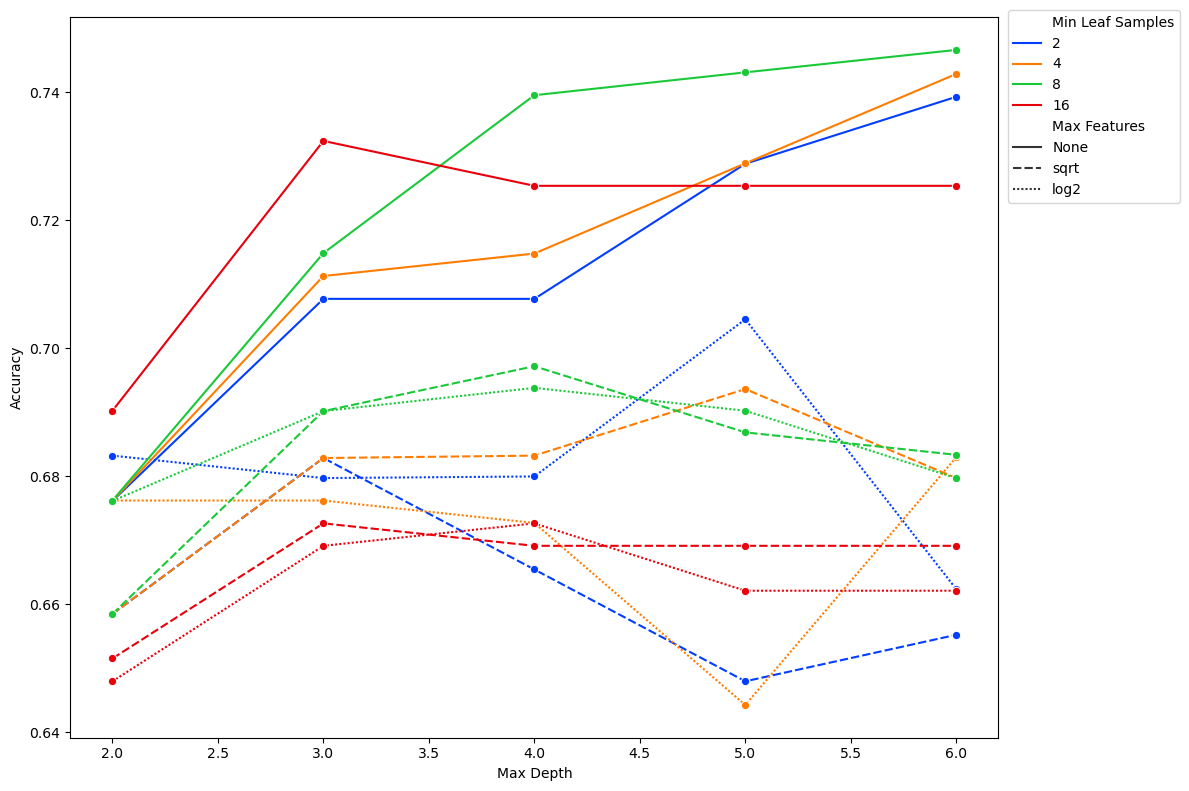

In [20]:
plt.figure(figsize = (12, 8))

gs_dt_plot1 = plot_grid_search(gs_results_dt_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('grid_search_results_dt_best.png')

We will now plot the results of the grid search whose `Splitter` value is `random` using the `plot_grid_search()` function that we wrote previously.  In the resulting line plot, we put `Max Depth` on the x-axis, determine the color of each line using the value of `Min Leaf Samples`, and determine the line style using the value of `Max Features`.  After we display the plot, we save it to a png file using the `plt.savefig()` function.

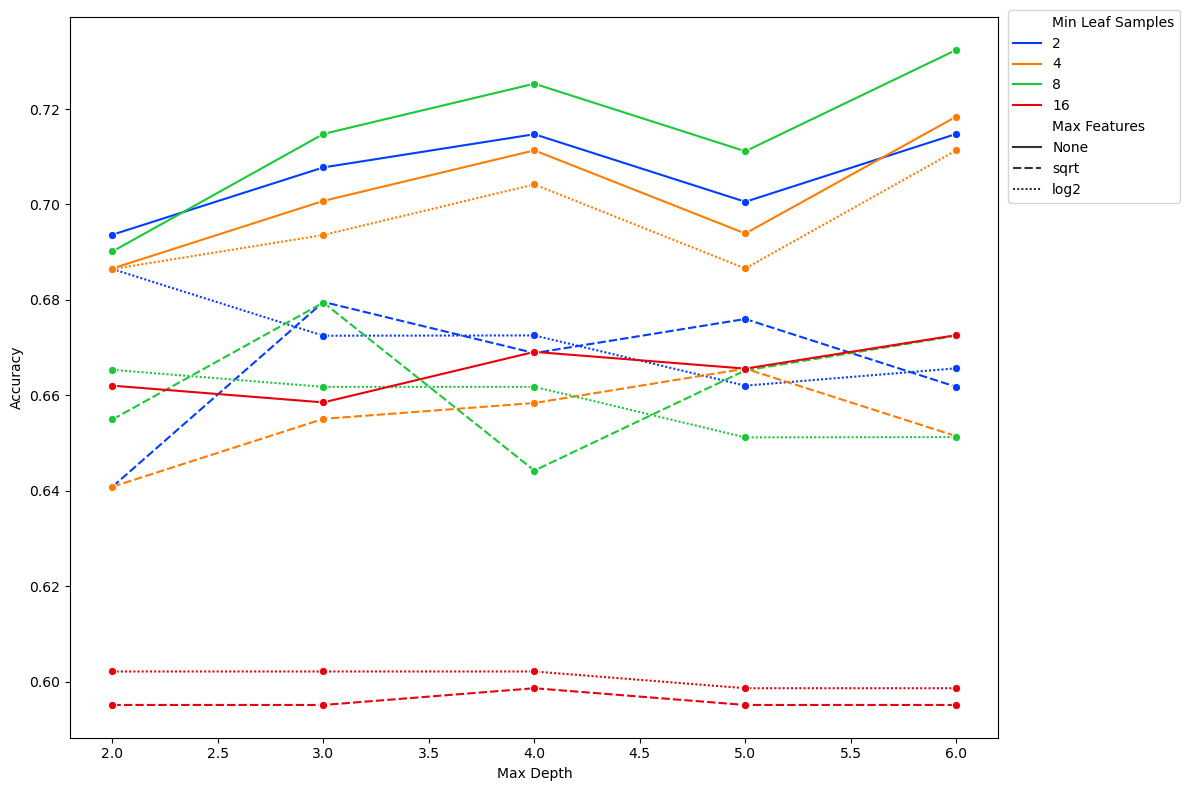

In [21]:
plt.figure(figsize = (12, 8))

gs_dt_plot2 = plot_grid_search(gs_results_dt_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('grid_serach_results_dt_random.png')

In order to determine the optimal hyperparameter values from grid search, we will sort the grid search results data frame by descending classification accuracy and display the resulting data frame.

In [22]:
gs_results_dt.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
100          6         None                 8     best  0.746617
76           5         None                 8     best  0.743108
98           6         None                 4     best  0.742857
52           4         None                 8     best  0.739536
96           6         None                 2     best  0.739286
..         ...          ...               ...      ...       ...
119          6         log2                16   random  0.598622
111          6         sqrt                16   random  0.595113
15           2         sqrt                16   random  0.595113
87           5         sqrt                16   random  0.595113
39           3         sqrt                16   random  0.595113

[120 rows x 5 columns]

We will now use randomized search to perform further hyperparameter tuning on the decision tree classifier pipeline.  In order to do so, we first create a dictionary of probability distributions over the hyperparameters.  Notice that we are putting a discrete uniform distribution over the maximum depth of the tree and the minimum number of samples in each leaf node.  The discrete uniform distribution over the maximum depth of the tree considers tree depths between $2$ and $6$, while the discrete uniform distribution over the minimum number of samples in each leaf node considers values between $2$ and $16$.  For the categorical hyperpameters maximum number of features and splitter, we provide a list of possible values.  The possible values for the maximum number of features are `None`, `sqrt`, and `log2` while the possible values for the splitter are `best` and `random`.  

We then use the `RandomizedSearchCV()` function to set up the randomized search procedure by passing it the decision tree classifier pipeline, setting the parameter distributions to the dictionary of values defined below, using the stratified 5-folds for cross-validation, setting the number of iterations of random search to $100$, and using the classification accuracy as the scoring metric.  We then fit the randomized search to the training data.

In [23]:
param_dist_dt = {
    'model__max_depth': stats.randint(2, 7),
    'model__min_samples_leaf': stats.randint(2, 17),
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__splitter': ['best', 'random']
}

random_search_dt = RandomizedSearchCV(decision_tree_pipe, param_distributions = param_dist_dt, cv = skf,
                                      n_iter = 100, scoring = 'accuracy', random_state = 20221031)

random_search_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=20221031))]),
                   n_iter=100,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f032c5f66a0>,
                                        'model__max_features': [None, 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f032cc59940>,
                                        'model__splitter': ['best', 'random']},
                   random_state=20221031, scoring='accuracy')

We will now use the `grid_search_results()` function to extract the randomized search results into a data frame, rename the columns of the data frame, and display the first $5$ rows of the randomizes search results data frame.

In [24]:
rs_results_dt = grid_search_results(random_search_dt)

rs_results_dt.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

rs_results_dt.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          6         sqrt                10   random  0.591541
1          6         log2                 6     best  0.658521
2          3         log2                 8   random  0.661779
3          2         None                 2   random  0.693672
4          6         None                 2   random  0.714787

We will now call `fix_none_vals()` to convert values of `None` to values of `'None'` in the data frame of randomized search results to make it easier to visualize these results.

In [25]:
rs_results_dt = fix_none_vals(rs_results_dt)

As before, we have too many hyperparameters in the randomized search to simply create a plot of all the randomized search results at once using seaborn so we will now use `split_results()` to create two smaller data frames of randomized search results.  The first data frame contains the randomized search results whose value of `Splitter` is `best` and the second data frame contains the randomized search results whose value of `Splitter` is `random`.

In [26]:
rs_results_dt_best, rs_results_dt_random = split_results(rs_results_dt, 'Splitter')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Splitter` value is `best`.  In this scatterplot, the values of `Max Depth` are on the x-axis, the hue of each point is determined by the value of `Min Leaf Samples`, and the size of each point is determined by the value of `Max Features`.  The cross-validation accuracy is shown on the y-axis and after displaying the scatterplot, we save it to a png file using the `plt.savefig()` function.

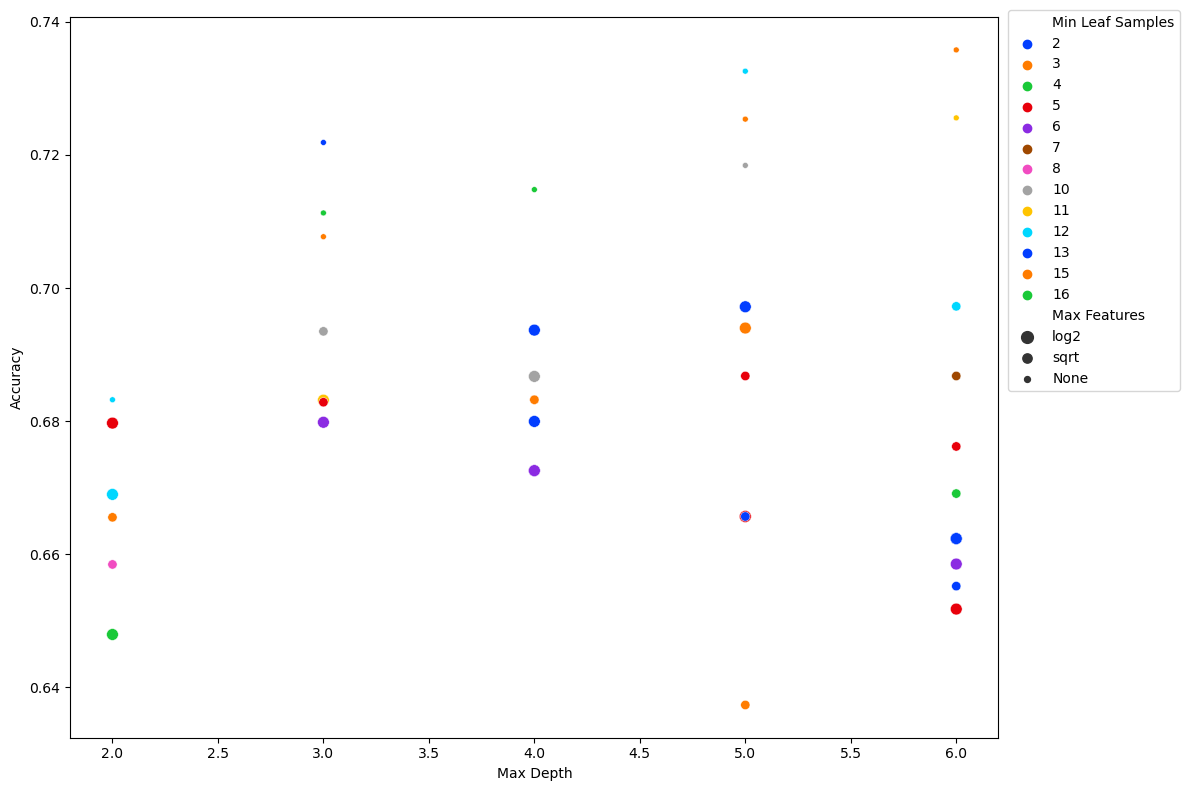

In [27]:
plt.figure(figsize = (12, 8))

rs_dt_plot1 = plot_random_search(rs_results_dt_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('random_search_results_dt_best.png')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Splitter` value is `random`.  In this scatterplot, the values of `Max Depth` are on the x-axis, the hue of each point is determined by the value of `Min Leaf Samples`, and the size of each point is determined by the value of `Max Features`.  The cross-validation accuracy is shown on the y-axis and after displaying the scatterplot, we save it to a png file using the `plt.savefig()` function.

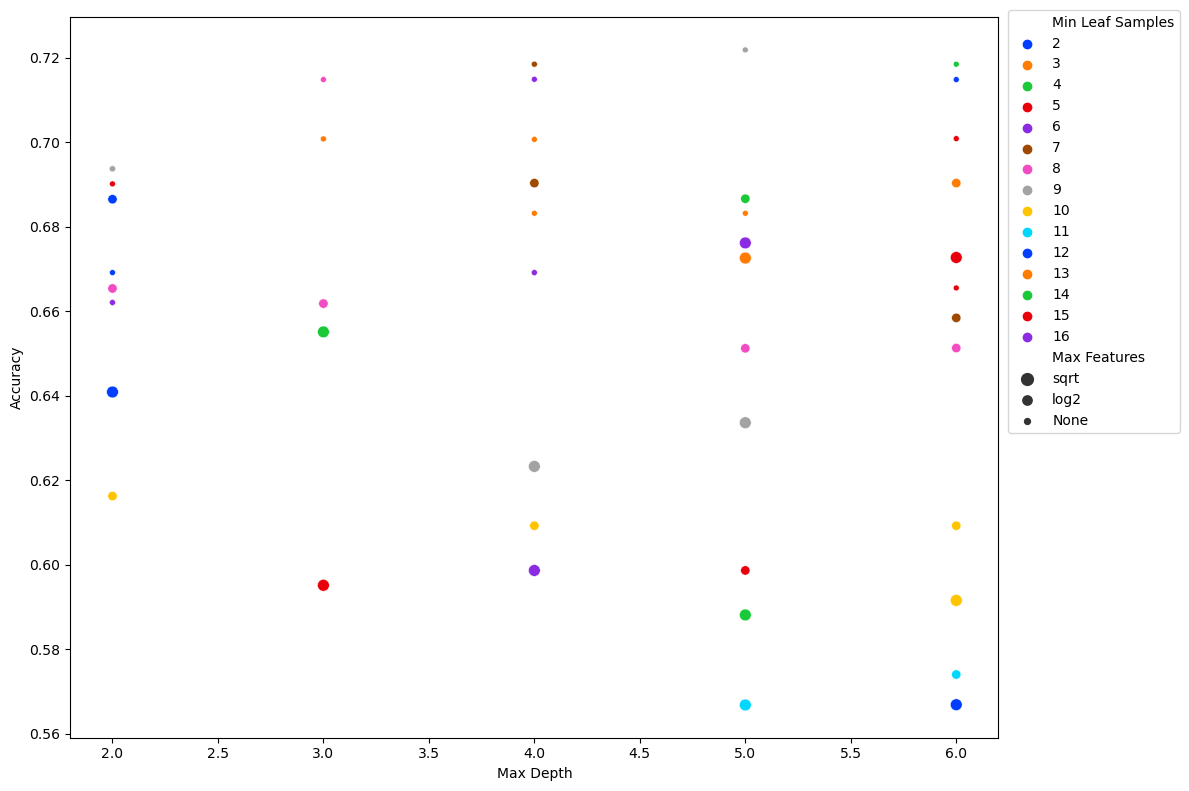

In [28]:
plt.figure(figsize = (12, 8))

rs_dt_plot2 = plot_random_search(rs_results_dt_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('random_search_results_dt_random.png')

We will now find the best combination of hyperparameter values from the randomized search procedure by sorting the values in the data frame of randomized search results in descending order according to their classification accuracy.

In [29]:
rs_results_dt.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
89          6         None                 3     best  0.735777
58          5         None                12     best  0.732581
11          6         None                11     best  0.725564
79          5         None                15     best  0.725376
9           3         None                13     best  0.721867
..        ...          ...               ...      ...       ...
0           6         sqrt                10   random  0.591541
33          5         sqrt                14   random  0.588095
95          6         log2                11   random  0.573997
46          6         sqrt                12   random  0.566855
57          5         sqrt                11   random  0.566792

[100 rows x 5 columns]

We will now use Bayes search to perform further hyperparameter tuning.  Notice that for Bayes search, we define a dictionary containing prior probability distributions over the hyperparameters.  Here, we put a discrete uniform prior distribution from $2$ to $6$ over the max depth and we put a discrete uniform prior distribution from $2$ to $16$ over the minimum number of samples in each leaf node.  We pick the maximum number of features from `None`, `sqrt`, and `log2` and we pick the splitter from `best` and `random`.  

Next, we use the `BayesSearchCV()` function to set up the Bayes search procedure.  For Bayes search, we perform $100$ iterations over the hyperparameter distributions using the decision tree pipeline from before.  We also use the stratified 5-fold for cross-validation from above and use scoring as the accuracy metric.  We then fit the Bayes search procedure to the training data.

In [17]:
bayes_dist_dt = {
    'model__max_depth': Integer(2, 6),
    'model__min_samples_leaf': Integer(2, 16),
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__splitter': ['best', 'random']
}

bayes_search_dt = BayesSearchCV(decision_tree_pipe, search_spaces = bayes_dist_dt, n_iter = 100, cv = skf,
                                scoring = 'accuracy', random_state = 20221031)

bayes_search_dt.fit(X_train, y_train)

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
              estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                        ('model',
                                         DecisionTreeClassifier(random_state=20221031))]),
              n_iter=100, random_state=20221031, scoring='accuracy',
              search_spaces={'model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'model__max_features': [None, 'sqrt', 'log2'],
                             'model__min_samples_leaf': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'model__splitter': ['best', 'random']})

We will now create a data frame of the Bayes search results and display the first $5$ rows.

In [18]:
bayes_results_dt = grid_search_results(bayes_search_dt)

bayes_results_dt.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

bayes_results_dt.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          4         log2                14   random  0.602130
1          4         sqrt                 3     best  0.676128
2          5         None                15   random  0.665602
3          5         None                 6     best  0.729010
4          4         sqrt                 7   random  0.669110

We will replace `None` values with `'None'` values in the data frame so that we can better visualize the results of the Bayes search procedure.

In [19]:
bayes_results_dt = fix_none_vals(bayes_results_dt)

We will now split the Bayes search results into two smaller data frames based on the value of the `Splitter` hyperparameter.

In [20]:
bayes_results_dt_best, bayes_results_dt_random = split_results(bayes_results_dt, 'Splitter')

We will now visualize the Bayes search results as scatterplots and save the images.

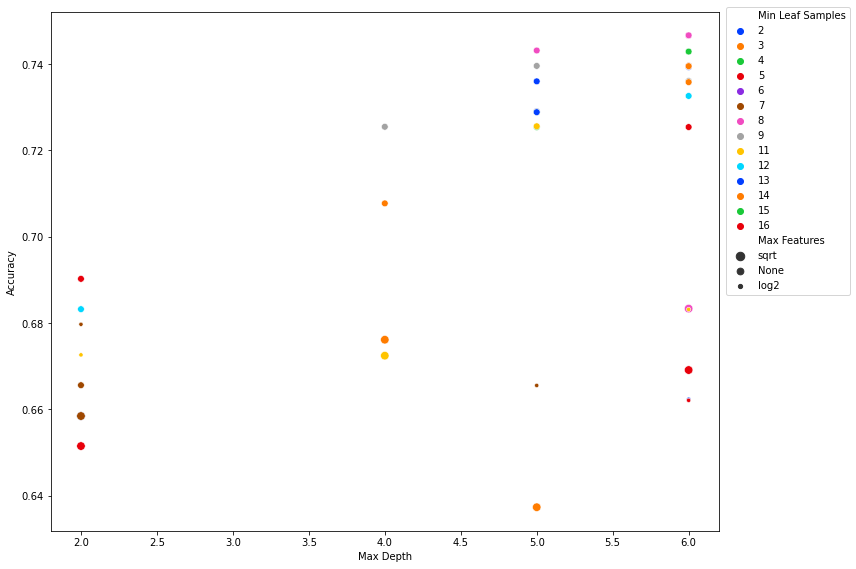

In [21]:
plt.figure(figsize = (12, 8))

bayes_plot1 = plot_random_search(bayes_results_dt_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('bayes_search_results_dt_best.png')

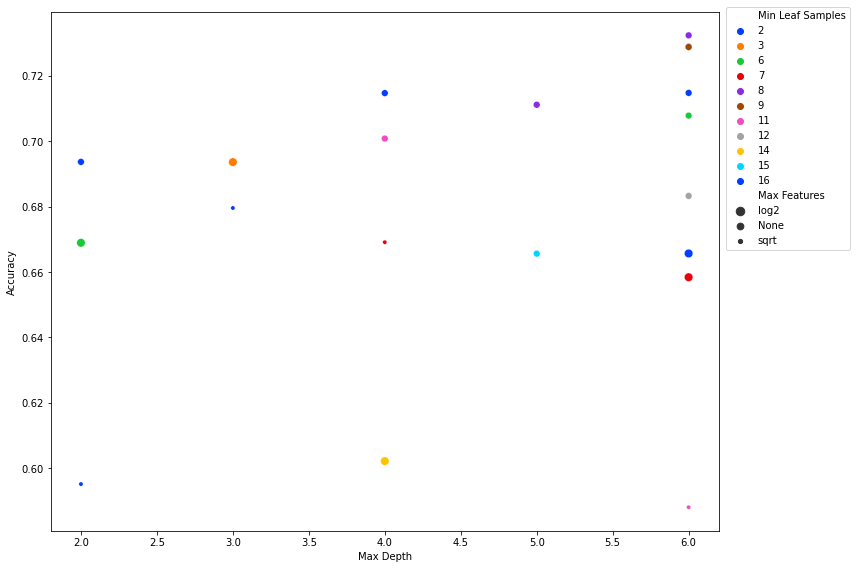

In [22]:
plt.figure(figsize = (12, 8))

bayes_plot2 = plot_random_search(bayes_results_dt_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('bayes_search_results_dt_random.png')

We will now sort the Bayes search results in order of descending classification accuracy in order to determine the best hyperparameters for the decision tree.

In [39]:
bayes_results_dt.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
50          6         None                 8     best  0.746617
59          6         None                 8     best  0.746617
89          6         None                 8     best  0.746617
45          6         None                 8     best  0.746617
46          6         None                 8     best  0.746617
..        ...          ...               ...      ...       ...
98          2         sqrt                16     best  0.651504
9           5         sqrt                 3     best  0.637343
0           4         log2                14   random  0.602130
16          2         sqrt                16   random  0.595113
94          6         sqrt                11   random  0.588033

[100 rows x 5 columns]

Based on the results from both the grid search and randomized search procedures, we see that the best combination of hyperparameter values is a maximum depth of $6$, no maximum number of features, a minimum of $8$ samples in each leaf node, and using the `best` splitter.  We will now use the `set_params()` function to set the hyperparameters of the decision tree classifier in the decision tree classifier pipeline to the aforementioned values.

In [30]:
decision_tree_pipe.set_params(**{'model__max_depth': 6, 'model__max_features': None, 
                                 'model__min_samples_leaf': 8, 'model__splitter': 'best'})

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=20221031))])

We will now fit the decision tree classifier pipeline with the optimal hyperparamter values found by performing both grid search and randomized search to the entire training dataset.

In [31]:
decision_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=8,
                                        random_state=20221031))])

Here, we will plot the best decision tree using the `plot_tree()` function, fill in the boxes in the plot, and save the plot to a pdf using the `plt.savefig()` function.

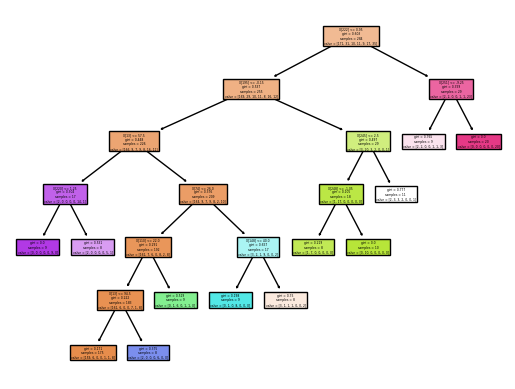

In [32]:
plot_tree(decision_tree_pipe[1], filled = True)

plt.savefig('arrhythmia_decision_tree.pdf')

We now want to determine which of the features from a patient's EKG data were important in predicting their arrhythmia diagnosis, meaning which of the features from a patient's EKG data had a nonzero feature importance.  In order to do so, we will first extract the feature importances from the decision tree classifier portion of the decision tree plipeline.  We will then use the `importance_df()` function to create a data frame from the feature importances in the decision tree classifier and we then display that data frame.

In [33]:
dt_importances = decision_tree_pipe[1].feature_importances_

importance_df_dt = importance_df(dt_importances, X_train.columns)

importance_df_dt

Feature Name  Feature Importance
0                 Heart Rate (bpm)            0.240291
6  V1 Amplitude *0.1 mV of R' Wave            0.228245
4  AVR Amplitude *0.1 mV of T Wave            0.205043
1                AVF Q Wave (msec)            0.109708
2                 V3 Q Wave (msec)            0.102103
7   V3 Amplitude *0.1 mV of T Wave            0.038107
9   V4 Amplitude *0.1 mV of S Wave            0.033755
3                 V6 S Wave (msec)            0.032546
5   V1 Amplitude *0.1 mV of R Wave            0.008872
8  V4 Amplitude *0.1 mV of JJ Wave            0.001330

Notice that there are $10$ features from a patient's EKG data that have a nonzero feature importance and are therefore important in predicting a patient's arrhythmia diagnosis.  Interestingly, we see that all but one of the features are lead-dependent, meaning they include data from only one location on a patient's body.  Observe that the most important feature in predicting a patient's arrhythmia diagnosis is their heart rate.

We will now use the `plot_feat_importances()` function to further visualize the most important features from a patient's EKG data.  This function returns a bar plot showing the feature importance on the y-axis and the name of the feature on the x-axis.  We will save this bar plot to a png file using the `plt.savefig()` function.

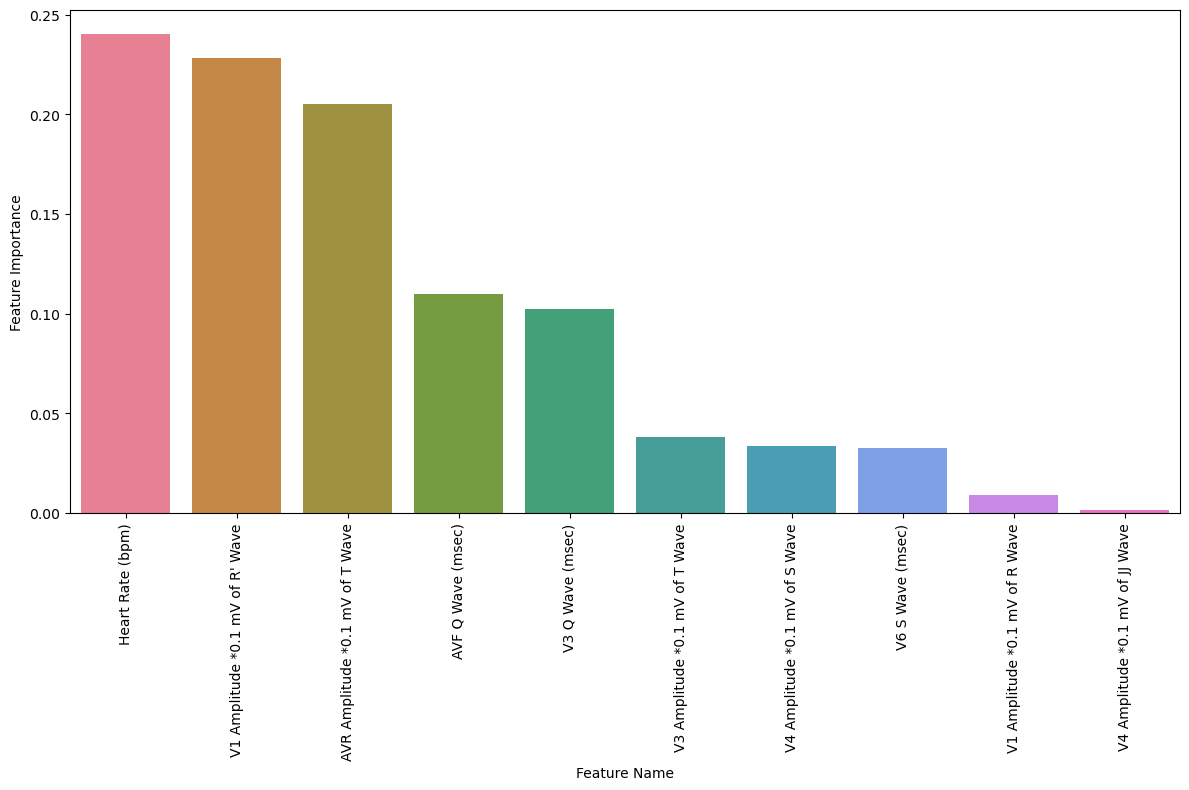

In [184]:
plt.figure(figsize = (12, 8))

feat_imp_plot = plot_feat_importances(importance_df_dt)

plt.tight_layout()

plt.savefig('dt_feat_imp_plot.png')

In order to determing whether the best decision tree classifier suffers from overfitting or underfitting, we will use the `learning_curve()` function that we pass the decision tree pipeline, the training data, the stratified 5-fold data, training sizes between $0.1$ and $1.0$ counting by $0.1$, and scoring on classification accuracy.

In [35]:
train_fractions = np.arange(0.1, 1.1, step = 0.1)

_, train_scores_dt, test_scores_dt = learning_curve(decision_tree_pipe, X_train, y_train, cv = skf, 
                                              scoring = 'accuracy', train_sizes = train_fractions, 
                                              return_times = False)

We will now use the `plot_learning_curve()` function to plot the results from the `learning_curve()` function and we save the plot to a png file using the `plt.savefig()` function.

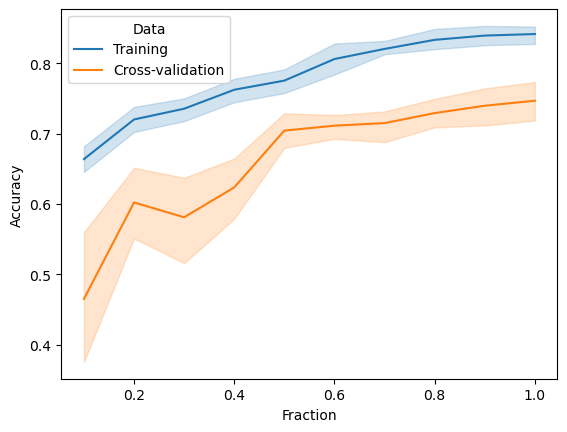

In [36]:
plot_learning_curve(train_fractions, train_scores_dt, test_scores_dt)

plt.savefig('learning_curve_dt.png')

We will now use the `score` method of the decision tree pipeline to find its training accuracy, which we then display.

In [37]:
train_acc_dt = decision_tree_pipe.score(X_train, y_train)

train_acc_dt

0.8415492957746479

Notice that the best decision tree classifier has a training accuracy of $0.8415$ which means that it correctly classifies $84.15\%$ of the instances in the training dataset.  

We will now create a confusion matrix for the training predictions of the best decision tree classifier by first generating predicted arrhythmia diagnoses for the instances in the training dataset, then creating a confusion matrix from those predictions and the actual diagnoses.  In the confusion matrix, we normalize by the true arrhythmia diagnosis so that more frequently occurring classes do not disproportionately impact the confusion matrix visualization.  We then produce a heatmap using seaborn of the confusion matrix so that we can more easily visualize the confusion matrix and we save it to a png file.

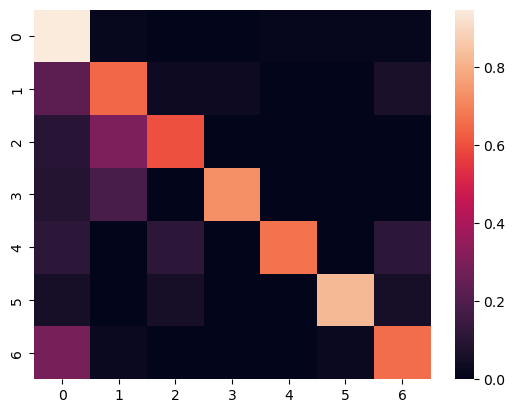

In [40]:
train_preds_dt = decision_tree_pipe.predict(X_train)

confmat_train_dt = confusion_matrix(y_train, train_preds_dt, normalize = 'true')

sb.heatmap(confmat_train_dt)

plt.savefig('confmat_train_dt.png')

Observe that the best decision tree classifier correctly predicts the arrhythmia diagnosis for all of the classes of actual arrhythmia diagnoses in the training set.  However, we see that the decision tree classifier will overpredict a normal diagnosis when the actual diagnosis is coronary artery disease or right bundle branch block.  Additionally, the decision tree classifier overpredicts coronary artery disease when the actual diagnosis is one of the two types of myocardial infarction.

We will now use the `score` method of the decision tree pipeline to calculate the test accuracy of the best decision tree classifier and we will then display the test accuracy.

In [41]:
test_acc_dt = decision_tree_pipe.score(X_test, y_test)

test_acc_dt

0.7886178861788617

From the output of the code shown above, we see that the test accuracy of the best decision tree is $0.7886$ which means that the best decision tree correctly classifies $78.86\%$ of the instances in the test set.

We will now use the decision tree pipeline to generate predicted arrhythmia diagnoses for each instance in the test set.  Then, we will create a confusion matrix using the predicted and actual arrhythmia diagnoses from the test set that is normalized according to the true diagnosis.  We will then use seaborn to create a heatmap from the confusion matrix in order to better visualize the classification mistakes that the best decision tree pipeline is making on the test set and we will save the plot to a png file.

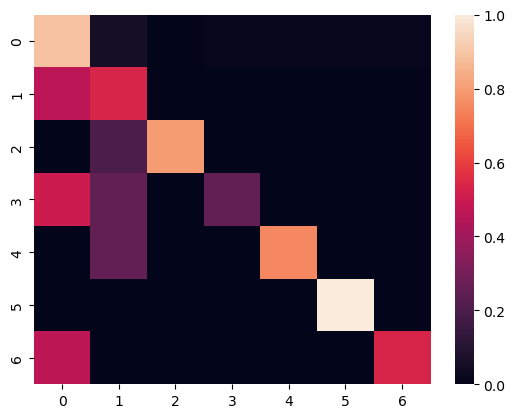

In [42]:
test_preds_dt = decision_tree_pipe.predict(X_test)

confmat_test_dt = confusion_matrix(y_test, test_preds_dt, normalize = 'true')

sb.heatmap(confmat_test_dt)

plt.savefig('confmat_test_dt.png')

Notice in the heatmap confusion matrix visualization shown above that the best decision tree classifier correctly predicts the diagnosis of most of the instances in the test set.  However, the best decision tree classifier overpredicts a normal diagnosis when the true diagnosis is coronary artery disease, old inferior myocardial infarction, or a right bundle branch block.  Additionally, the best decision tree classifier overpredicts a diagnosis of coronary artery disease when the actual diagnosis is an old anterior myocardial infarction, an old inferior myocardial infarction, or a sinus tachycardy.

# Random Forest

In this section, we will fit a random forest classifier to the data, perform hyperparameter tuning using both grid search and randomized search, update the hyperparameters of the random forest classifier to the best values from hyperparameter tuning, examine the important features from the random forest classifier, and evaluate the training and test performance of the best random forest classifier.

To start, we will define a random forest classifier that uses the `gini` criterion by using the `RandomForestClassifier()` function from scikit-learn.  We will then incorporate this random forest classifier into a pipeline that first performs K-nearest neighbors imputation and then fits a random forest classifier.

In [43]:
random_forest = RandomForestClassifier(criterion = 'gini', random_state = 20221031)

random_forest_pipe = Pipeline(steps = [('imputer', imputer), ('model', random_forest)])

We will now perform grid search for hyperparameter tuning.  This grid search will consider using $50$, $75$, $100$, and $125$ decision trees in the random forest, using decision trees with a maximum depth between $2$ and $6$ in the random forest, using decision trees with a minimum number of leaf samples of $2$, $4$, $8$, or $16$ in the random forest, and using a maximum number of features of `sqrt` or `log2` in each decision tree in the random forest.  

We then use the `GridSearchCV()` function to set up the grid search procedure.  Notice that we pass the grid search procedure the random forest pipeline, the parameter grid defined below, the stratified 5-fold that we defined previously, and we use classification accuracy as the scoring metric.  We then fit the grid search procedure to the training data.

In [44]:
param_grid_rf = {
    'model__n_estimators': [50, 75, 100, 125],
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_leaf': [2, 4, 8, 16],
    'model__max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(random_forest_pipe, param_grid = param_grid_rf, cv = skf, scoring = 'accuracy')

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('model',
                                        RandomForestClassifier(random_state=20221031))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 8, 16],
                         'model__n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

We will now extract the grid search results to a data frame using the `grid_search_results()` function, rename the columns of the data frame, and dislay the first $5$ grid search results.

In [45]:
gs_results_rf = grid_search_results(grid_search_rf)

gs_results_rf.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

gs_results_rf.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          2         sqrt                 2              50  0.637343
1          2         sqrt                 2              75  0.633772
2          2         sqrt                 2             100  0.637406
3          2         sqrt                 2             125  0.640852
4          2         sqrt                 4              50  0.637281

Now we will use the `split_results()` function to split the grid search results data frame into a data frame containing the grid search results whose `Max Features` value is `sqrt` and a data frame containing the grid search results whose `Max Features` value is `log2`.  

In [46]:
gs_results_rf_sqrt, gs_results_rf_log2 = split_results(gs_results_rf, 'Max Features')

We will now use the `plot_grid_search()` function to visualize the grid search results whose `Max Features` value is `sqrt` in a lineplot with `Max Depth` on the x-axis, `Min Leaf Samples` determining the line hue, and `Num Estimators` determining the line style.  We then save this lineplot to a png using the `plt.savefig()` function.

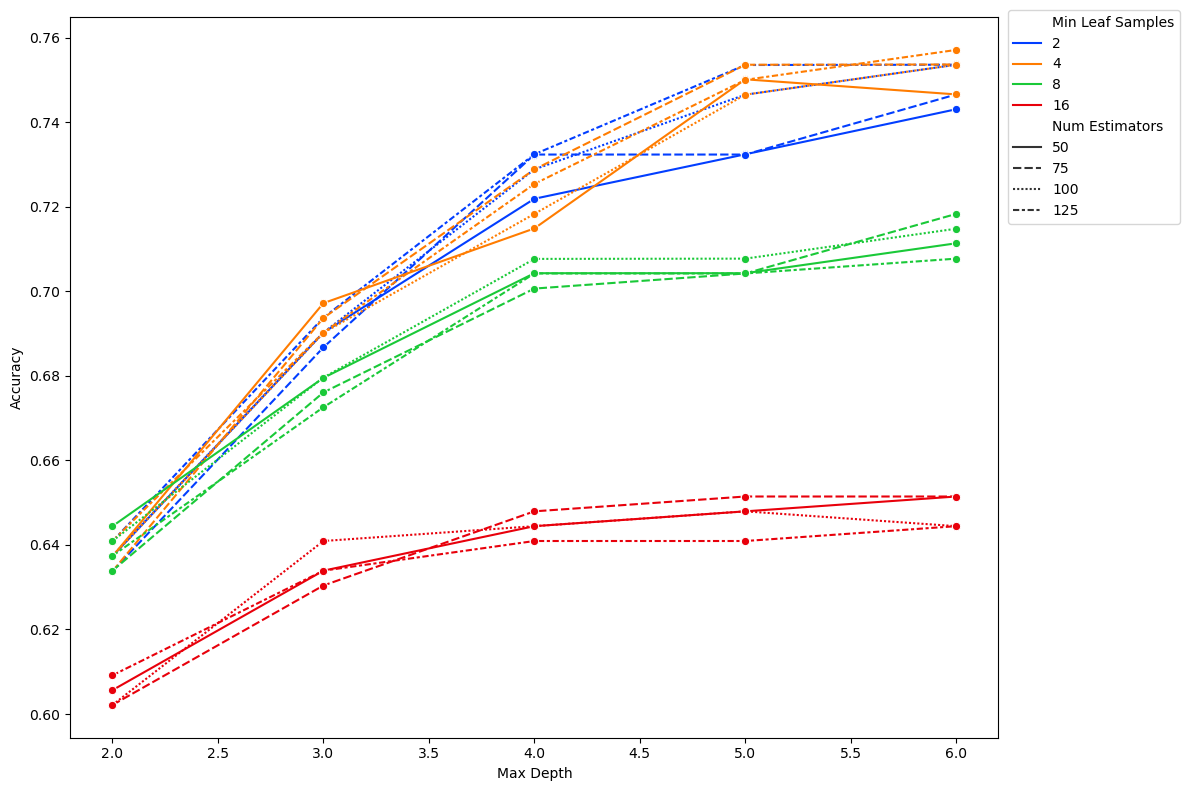

In [47]:
plt.figure(figsize = (12, 8))

gs_rf_plot1 = plot_grid_search(gs_results_rf_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('grid_search_results_rf_sqrt.png')

We will now use the `plot_grid_search()` function to visualize the grid search results whose `Max Features` value is `log2` in a lineplot with `Max Depth` on the x-axis, `Min Leaf Samples` determining the line hue, and `Num Estimators` determining the line style.  We then save this lineplot to a png using the `plt.savefig()` function.

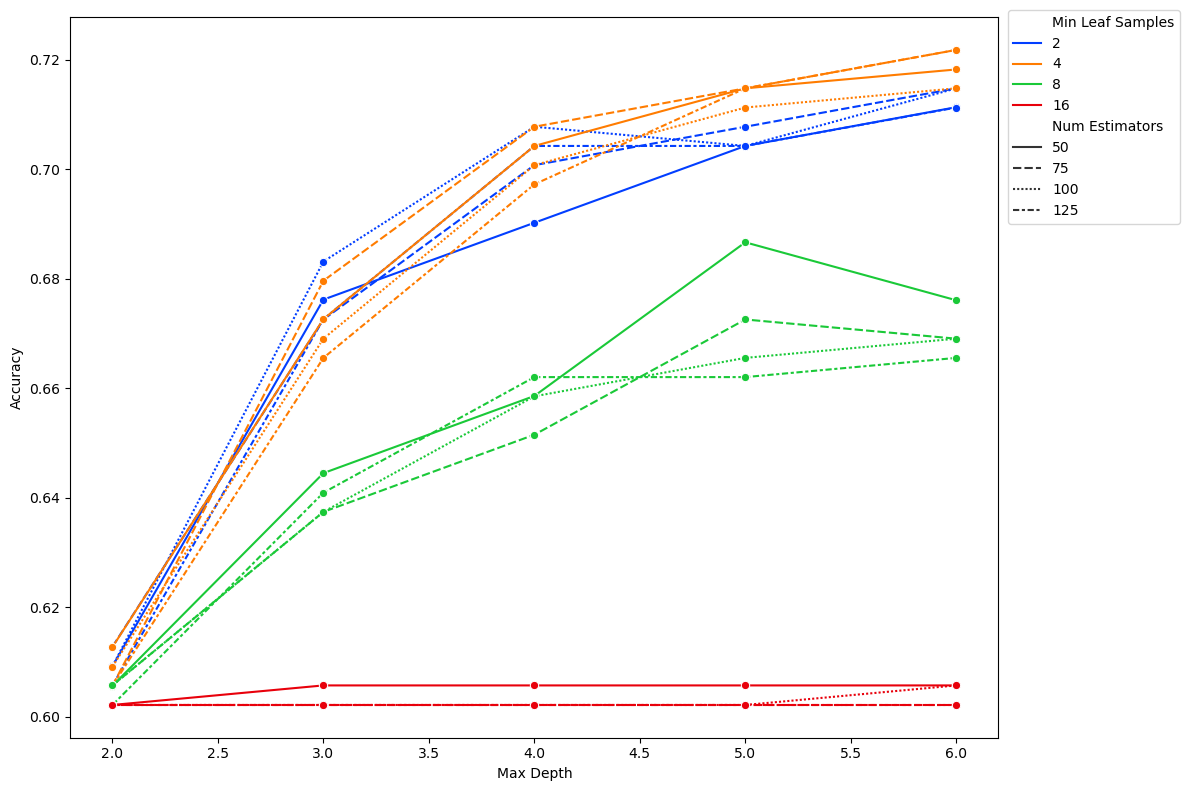

In [48]:
plt.figure(figsize = (12, 8))

gs_rf_plot2 = plot_grid_search(gs_results_rf_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('grid_search_results_rf_log2.png')

In order to find the best hyperparameter values from those considered during the grid search procedure, we will sort the values in the data frame containing the grid search results in descending order according to their classification accuracy.

In [49]:
gs_results_rf.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
135          6         sqrt                 4             125  0.757080
133          6         sqrt                 4              75  0.753634
101          5         sqrt                 4              75  0.753571
134          6         sqrt                 4             100  0.753571
130          6         sqrt                 2             100  0.753571
..         ...          ...               ...             ...       ...
61           3         log2                16              75  0.602130
62           3         log2                16             100  0.602130
63           3         log2                16             125  0.602130
93           4         log2                16              75  0.602130
159          6         log2                16             125  0.602130

[160 rows x 5 columns]

Now, we will use randomized search in order to further explore the hyperparameter space.  First, we will define a dictionary of probability distributions to place over the hyperparameter values.  We will place a discrete uniform distribution from $50$ to $125$ over the number of estimators hyperparameter.  Similarly, we place a discrete uniform distribution from $2$ to $6$ over the maximum depth of each decision tree in the random forest and we place a discrete uniform distribution from $2$ to $16$ over the number of minimum samples in each leaf node.  Finally, consider values of `sqrt`  and `log2` for the maximum number of features used when fitting each decision tree in the random forest since it is a categorical variable.  

After defining the dictionary of probability distributions over the hyperparameters, we use the `RandomizedSearchCV()` function to set up the randomized search procedure.  Observe that we use the random forest pipeline as the model to use in the randomized search, we set the parameter distributions to the dictionary defined below, we use the stratified 5-folds for cross-validation, we set the number of iterations of randomized search to $100$, and we use the classification accuracy as the scoring metric.  We then fit the randomized search procedure to the training data.

In [50]:
param_dist_rf = {
    'model__n_estimators': stats.randint(50, 126),
    'model__max_depth': stats.randint(2, 7),
    'model__min_samples_leaf': stats.randint(2, 17),
    'model__max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(random_forest_pipe, param_distributions = param_dist_rf, cv = skf, 
                                      n_iter = 100, scoring = 'accuracy', random_state = 20221031)

random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('model',
                                              RandomForestClassifier(random_state=20221031))]),
                   n_iter=100,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0314c5f520>,
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0314d9e970>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0314c429a0>},
                   random_state=20221031, scoring='accuracy')

We now use the `grid_search_results()` function to extract the randomized search results to a data frame, rename the columns of the resulting data frame, and display the first $5$ rows of randomized search results from the data frame.

In [51]:
rs_results_rf = grid_search_results(random_search_rf)

rs_results_rf.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

rs_results_rf.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          6         log2                10              77  0.662030
1          6         sqrt                 6             118  0.732456
2          3         sqrt                 8              87  0.683083
3          2         log2                 6              50  0.616228
4          6         sqrt                 2              63  0.750063

Since the data frame of randomized search results contains too many hyperparameters to display in a seaborn plot, we will first split the data frame of randomized search results into two smaller data frames of randomized search results.  In order to do so, we will use the `split_results()` function and split the data frame according to the value of the `Max Features` hyperparameter.  This results in a data frame containing the randomized search results whose value of `Max Features` is `sqrt` and a data frame containing the randomized search results whose value of `Max Features` is `log2`.

In [52]:
rs_results_rf_sqrt, rs_results_rf_log2 = split_results(rs_results_rf, 'Max Features')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Max Features` value is `sqrt` using seaborn.  In the scatterplot, `Max Depth` is placed on the x-axis, the hue of each of the points is determined by the value of `Min Leaf Samples`, and the size of each of the points is determined by the value of `Num Estimators`.  After creating and displaying the scatterplot, we save the figure as a png file using the `plt.savefig()` function.

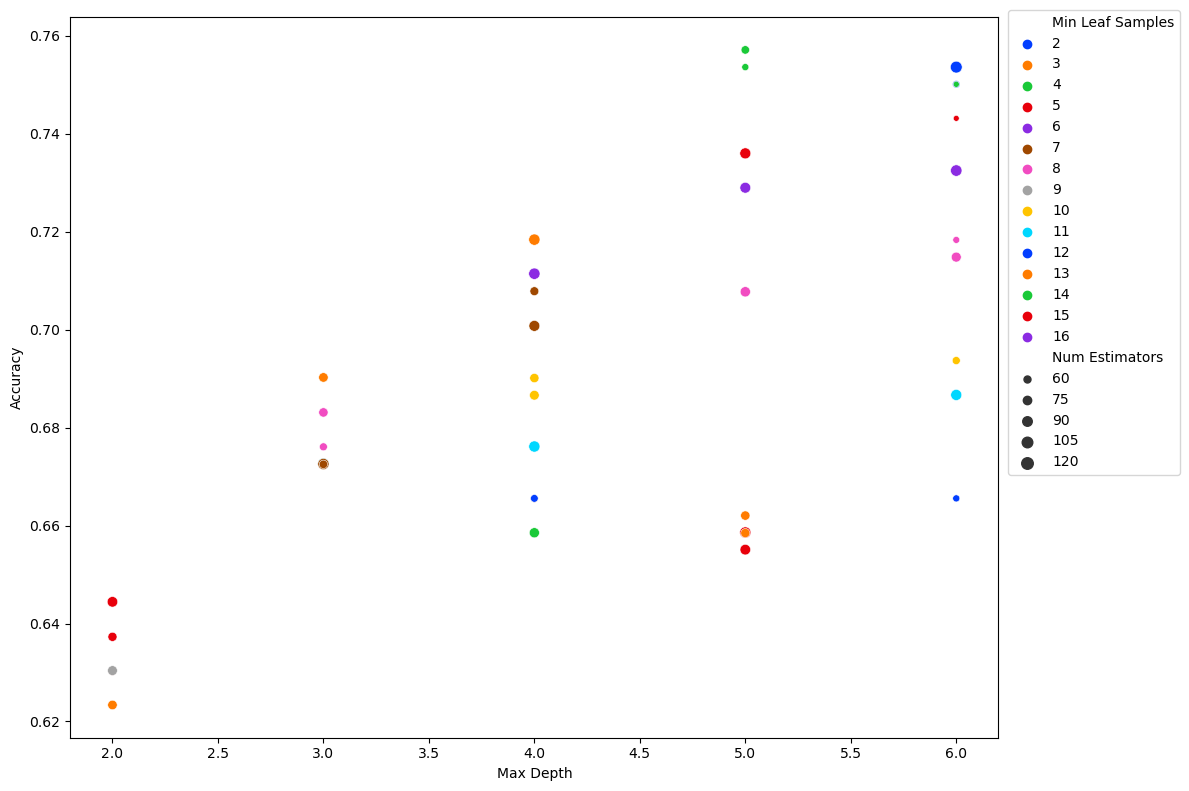

In [53]:
plt.figure(figsize = (12, 8))

rs_rf_plot1 = plot_random_search(rs_results_rf_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('random_search_results_rf_sqrt.png')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Max Features` value is `log2` using seaborn.  In the scatterplot, `Max Depth` is placed on the x-axis, the hue of each of the points is determined by the value of `Min Leaf Samples`, and the size of each of the points is determined by the value of `Num Estimators`.  After creating and displaying the scatterplot, we save the figure as a png file using the `plt.savefig()` function.

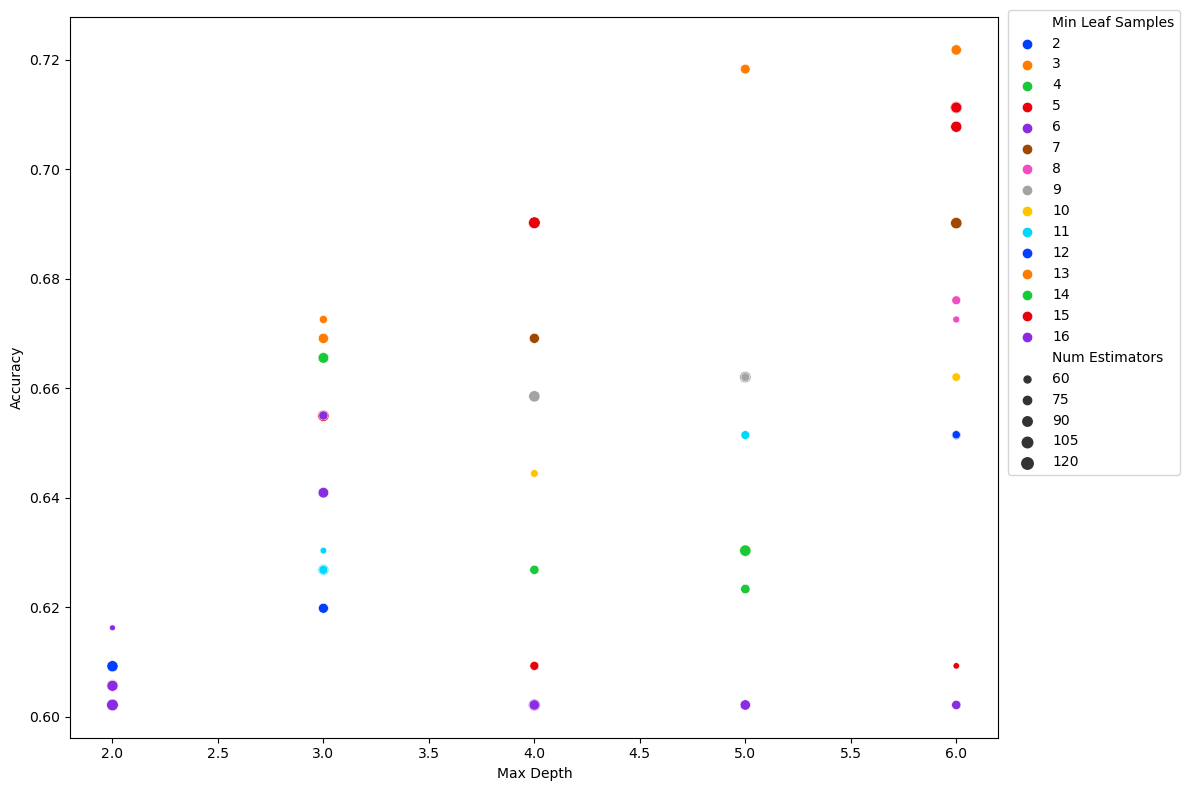

In [54]:
plt.figure(figsize = (12, 8))

rs_rf_plot2 = plot_random_search(rs_results_rf_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('random_search_results_rf_log2.png')

Although we have plotted all the results from the randomized search across two plots, we will now find the best hyperparameter values from the randomized search by sorting the values in the randomized search results for the random forest pipeline in descending order according to their classification accuracy.

In [55]:
rs_results_rf.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
72          5         sqrt                 4              76  0.757080
45          6         sqrt                 2             124  0.753571
81          5         sqrt                 4              61  0.753571
4           6         sqrt                 2              63  0.750063
71          6         sqrt                 4              51  0.750063
..        ...          ...               ...             ...       ...
15          2         log2                15              92  0.602130
87          2         log2                16             123  0.602130
18          2         log2                12              66  0.602130
25          4         log2                16             101  0.602130
74          5         log2                16             102  0.602130

[100 rows x 5 columns]

We will now use Bayes search to perform further hyperparameter tuning.  Notice that for Bayes search, we define a dictionary containing prior probability distributions over the hyperparameters.  Here, we put a discrete uniform prior distribution from $2$ to $6$ over the max depth, we put a discrete uniform prior distribution from $2$ to $16$ over the minimum number of samples in each leaf node, and we put a discrete uniform prior distribution from $50$ to $125$ over the number of estimators.  We also pick the maximum number of features from `sqrt`, and `log2`.  

Next, we use the `BayesSearchCV()` function to set up the Bayes search procedure.  For Bayes search, we perform $100$ iterations over the hyperparameter distributions using the random forest pipeline from before.  We also use the stratified 5-fold for cross-validation from above and use scoring as the accuracy metric.  We then fit the Bayes search procedure to the training data.

In [24]:
bayes_dist_rf = {
    'model__max_depth': Integer(2, 6),
    'model__min_samples_leaf': Integer(2, 16),
    'model__n_estimators': Integer(50, 125),
    'model__max_features': ['sqrt', 'log2']
}

bayes_search_rf = BayesSearchCV(random_forest_pipe, search_spaces = bayes_dist_rf, cv = skf, n_iter = 100,
                                scoring = 'accuracy', random_state = 20221031)

bayes_search_rf.fit(X_train, y_train)

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
              estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                        ('model',
                                         RandomForestClassifier(random_state=20221031))]),
              n_iter=100, random_state=20221031, scoring='accuracy',
              search_spaces={'model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'model__max_features': ['sqrt', 'log2'],
                             'model__min_samples_leaf': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=125, prior='uniform', transform='normalize')})

We will now convert the Bayes search results into a data frame and display the first $5$ rows of results.

In [25]:
bayes_search_results_rf = grid_search_results(bayes_search_rf)

bayes_search_results_rf.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

bayes_search_results_rf.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          4         sqrt                14             115  0.665602
1          4         sqrt                 3              69  0.728885
2          5         log2                15              99  0.609273
3          5         log2                 6              57  0.718358
4          4         log2                 7             111  0.662030

We will now split the Bayes search results into two smaller dataframes according to the `Max Features` value so that we can more easily visualize the results.

In [26]:
bayes_search_rf_sqrt, bayes_search_rf_log2 = split_results(bayes_search_results_rf, 'Max Features')

We will now create two scatterplots of the Bayes search results and save the images.

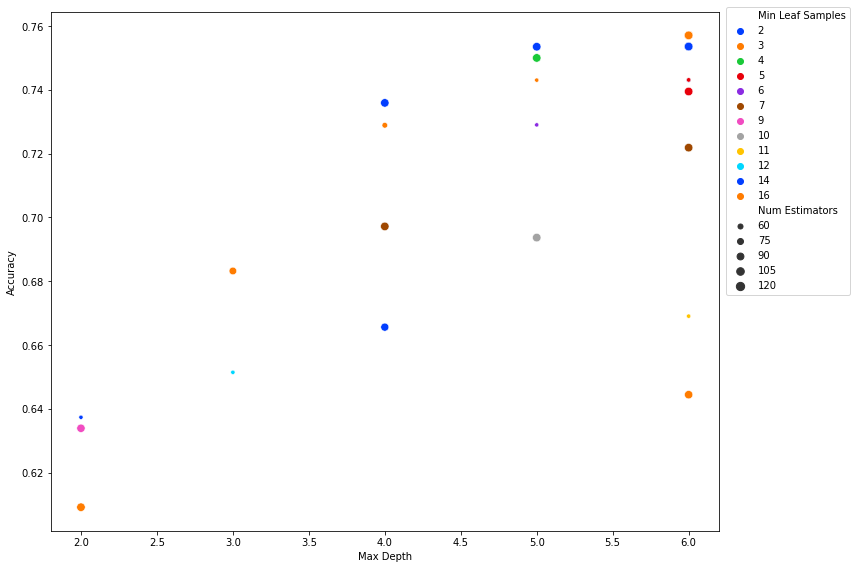

In [27]:
plt.figure(figsize = (12, 8))

bayes_rf_plot1 = plot_random_search(bayes_search_rf_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('bayes_search_results_rf_sqrt.png')

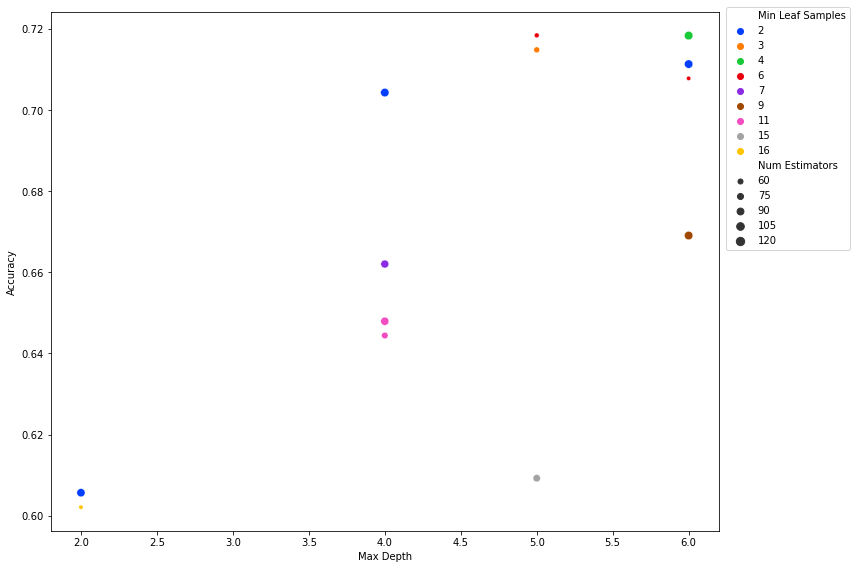

In [28]:
plt.figure(figsize = (12, 8))

bayes_rf_plot2 = plot_random_search(bayes_search_rf_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('bayes_search_results_rf_log2.png')

We will now sort the Bayes search results by order of descending classification accuracy in order to determine the best hyperparameters for the random forest found during Bayes search.

In [29]:
bayes_search_results_rf.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
50          6         sqrt                 3             125  0.757080
51          6         sqrt                 3             125  0.757080
74          6         sqrt                 3             125  0.757080
73          6         sqrt                 3             125  0.757080
72          6         sqrt                 3             125  0.757080
..        ...          ...               ...             ...       ...
30          2         sqrt                 9             121  0.633897
2           5         log2                15              99  0.609273
16          2         sqrt                16             125  0.609148
23          2         log2                 2             117  0.605702
32          2         log2                16              50  0.602130

[100 rows x 5 columns]

Observe that the best hyperparameters for the random forest classifier based on both the grid search and randomized search results are a maximum depth of $6$ for each of the decision trees in the random forest, a minimum of $4$ samples in each leaf node in each of the decision trees in the random forest, a maximum of `sqrt` features used to fit each of the decision trees in the random forest, and $125$ decision trees in the random forest.

We will now use the `set_params()` function to set the hyperparameters in the random forest classifier to the best hyperparameters determined by the grid search and randomized search results.

In [56]:
random_forest_pipe.set_params(**{'model__max_depth': 6, 'model__max_features': 'sqrt', 
                                 'model__min_samples_leaf': 4, 'model__n_estimators': 125})

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=4,
                                        n_estimators=125,
                                        random_state=20221031))])

Now, we will fit the best random forest classifier pipeline to the training data.  Observe that the best random forest classifier pipeline is the pipeline whose model is the random forest classifier whose hyperparameters are set to the best hyperparameter values from the hyperparameter tuning results.

In [57]:
random_forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=4,
                                        n_estimators=125,
                                        random_state=20221031))])

Here, we will extract the feature importances from the random forest classifier in the random forest pipeline.  We then use the `importance_df()` function and the feature importances from the random forest classifier to produce a data frame showing the feature importances for all the features whose feature importance is greater than $0$ and we display the data frame of feature importances from the random forest classifier.  

In [58]:
rf_importances = random_forest_pipe[1].feature_importances_

importance_df_rf = importance_df(rf_importances, X_train.columns)

importance_df_rf

Feature Name  Feature Importance
121                              V1 QRSA            0.049403
13                      Heart Rate (bpm)            0.046066
43    V1 Number of Intrinsic Deflections            0.043422
118      V1 Amplitude *0.1 mV of R' Wave            0.042607
42                     V1 R' Wave (msec)            0.042086
..                                   ...                 ...
93       AVR Amplitude *0.1 mV of S Wave            0.000384
94       AVR Amplitude *0.1 mV of P Wave            0.000379
29                    AVR R' Wave (msec)            0.000229
34   AVL Number of Intrinsic Deflections            0.000153
99       AVL Amplitude *0.1 mV of Q wave            0.000113

[164 rows x 2 columns]

Notice that there are $164$ features whose feature importance is greater than $0$ in the best random forest classifier, which means that there are $164$ features that are important in predicting a patient's arrhythmia diagnosis.  

In order to better visualize the features whose feature importances is greater than $0$, we will use the `plot_feat_importances()` function to produce a barplot showing the feature importances on the y-axis and the feature name on the x-axis.  We save the resulting barplot as a png file using the `plt.savefig()` function.

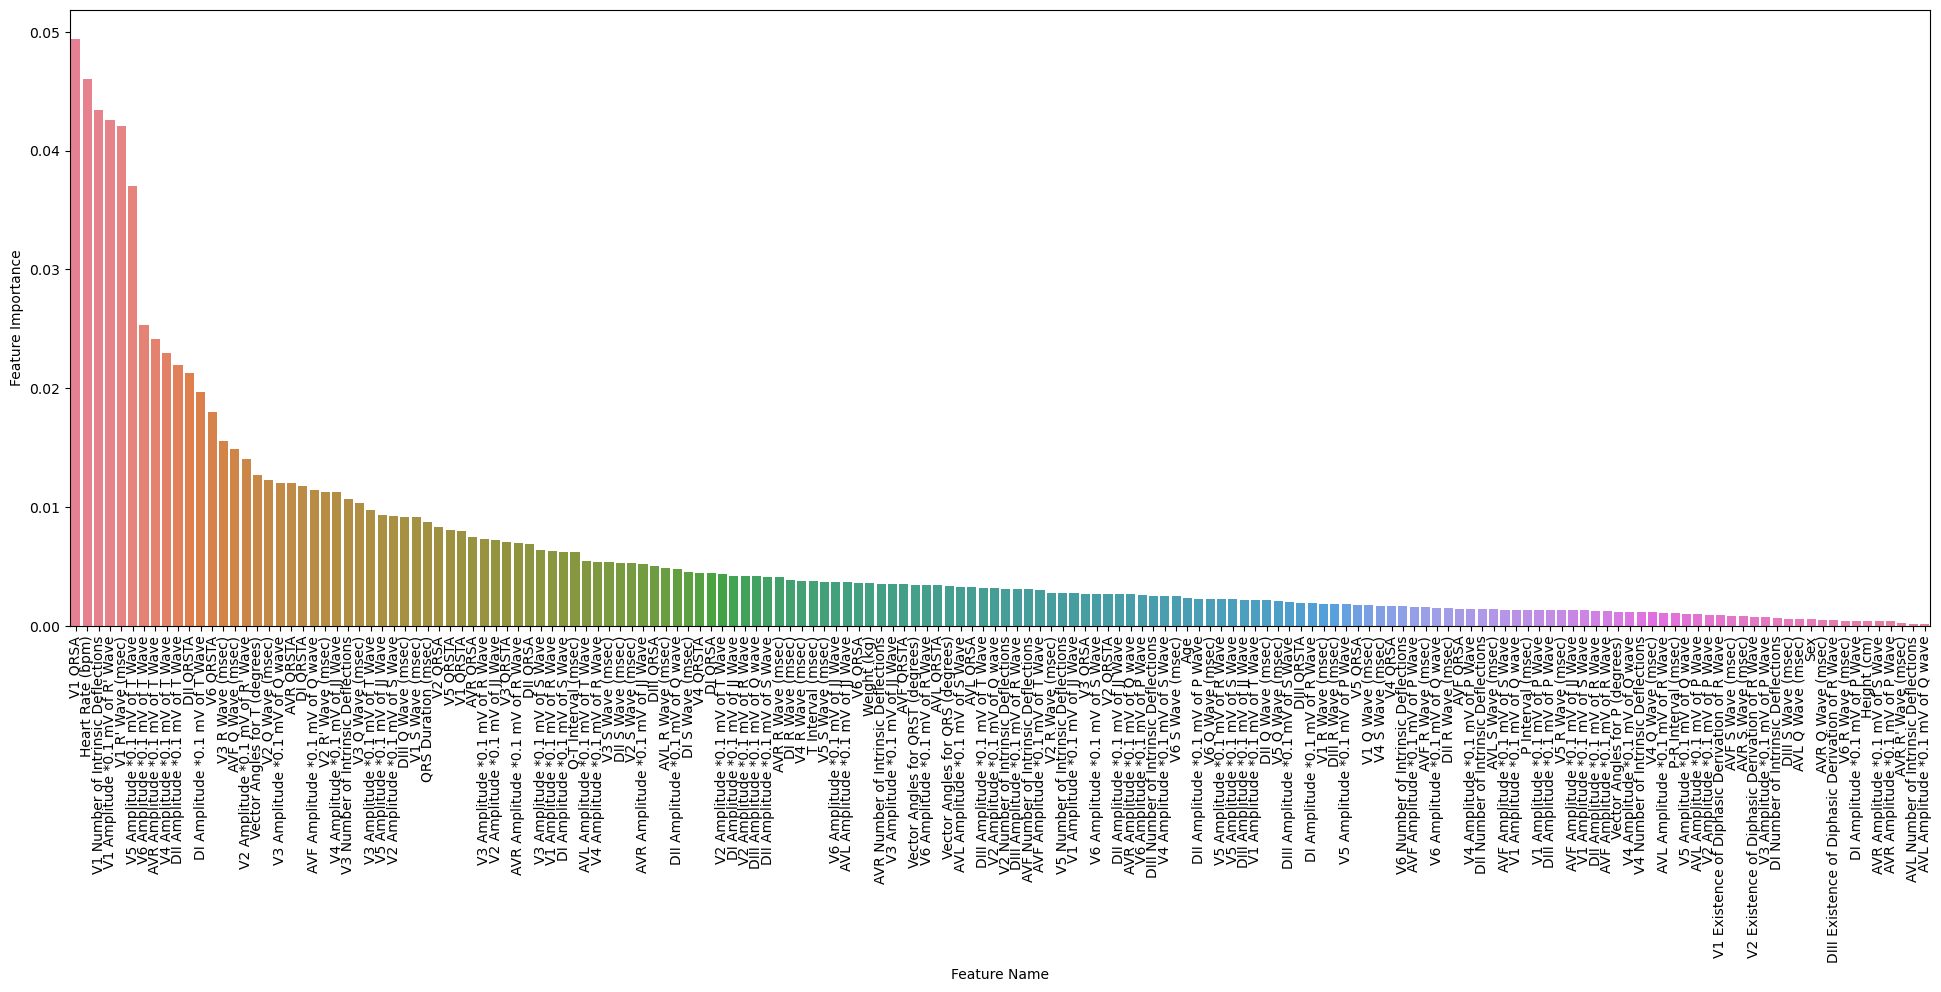

In [59]:
plt.figure(figsize = (24, 8))
rf_imp_plot = plot_feat_importances(importance_df_rf)
plt.savefig('rf_imp_plot.png')

Since there are $164$ features whose feature importance is greater than $0$ in the random forest classifier, it is very difficult to read and interpret the plot shown above.  As a result, we will now use the `plot_feat_importances()` function to create a barplot showing the feature importance on the y-axis and the feature name on the x-axis for only the top $15$ features from the random forest classifier.  We then save the resulting barplot as a png file using the `plt.savefig()` function.

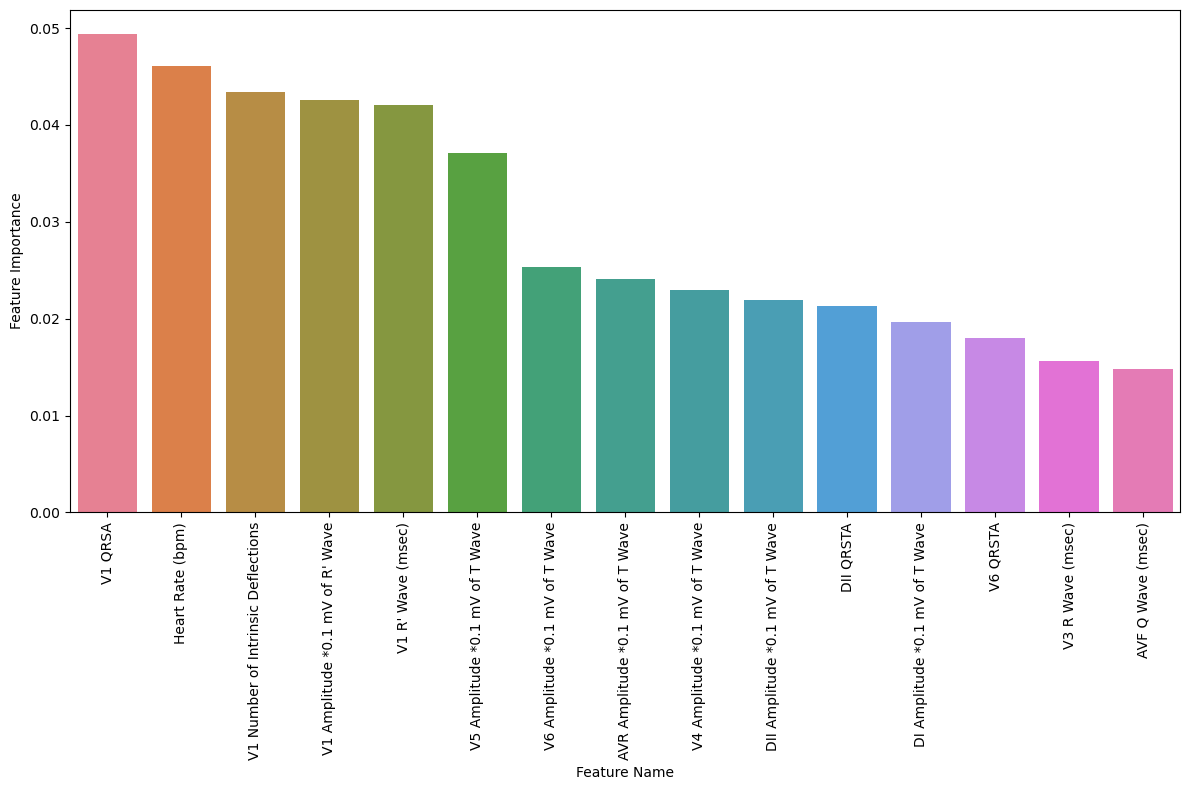

In [188]:
plt.figure(figsize = (12, 8))

rf_imp_plot_small = plot_feat_importances(importance_df_rf.iloc[0:15,:])

plt.tight_layout()

plt.savefig('rf_imp_plot_small.png')

From the barplot shown above, we see that the top $15$ most important features from the random forest classifier are almost all lead-dependent, meaning that we use the values from the EKG for only certain areas of the body. As with the best decision tree classifier, a patient's heart rate is the most important feature for predicting their arrhythmia diagnosis.

We will now use the `learning_curve()` function from scikit-learn to determine if the best random forest classifier is showing any signs of underfitting or overfitting the data.  When we call the `learning_curve()` function, we pass it the random forest pipeline, the training data, the stratified 5-folds for cross-validation, use train sizes between $0.1$ and $1.0$ counting by $0.1$, and use the classification accuracy as the scoring metric.

In [61]:
_, train_scores_rf, test_scores_rf = learning_curve(random_forest_pipe, X_train, y_train, cv = skf,
                                                    train_sizes = train_fractions, scoring = 'accuracy',
                                                    return_times = False)

Now that we have the results of the call to the `learning_curve()` function from scikit-learn for the random forest classifier, we will use the `plot_learning_curve()` function to visualize these results.  We will also save this plot as a png using the `plt.savefig()` function.

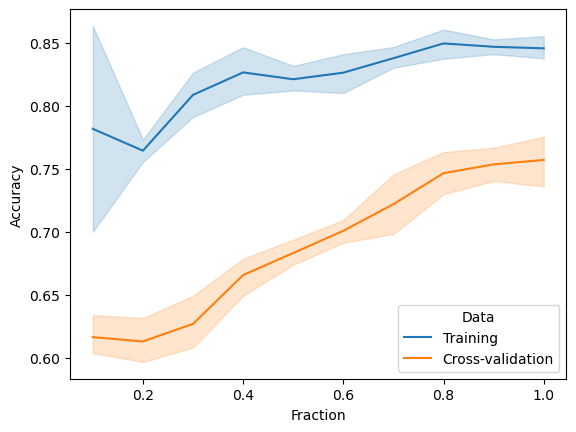

In [62]:
plot_learning_curve(train_fractions, train_scores_rf, test_scores_rf)

plt.savefig('learning_curve_rf.png')

We will now use the `score()` method on the random forest classifier pipeline in order to determine the training accuracy of the random forest classifier.  After obtaining the training accuracy of the random forest classifier, we also print its value.

In [63]:
train_acc_rf = random_forest_pipe.score(X_train, y_train)

train_acc_rf

0.8450704225352113

Based on the output of the code shown above, we see that the training accuracy for the random forest classifier is $0.8451$.  This means that the random forest classifier correctly predicts the arrhythmia diagnosis for $84.51\%$ of the training instances.

In the following code cell, we use the random forest pipeline to produce predicted arrhythmia diagnoses for all the training instances.  We then use the `confusion_matrix()` function to produce a confusion matrix for the predicted arrhythmia diagnoses for the training instances that is normalized by the true arrhythmia diagnosis.  Next, we use seaborn to produce a heatmap visualization of the confusion matrix and we save the heatmap figure to a png file.

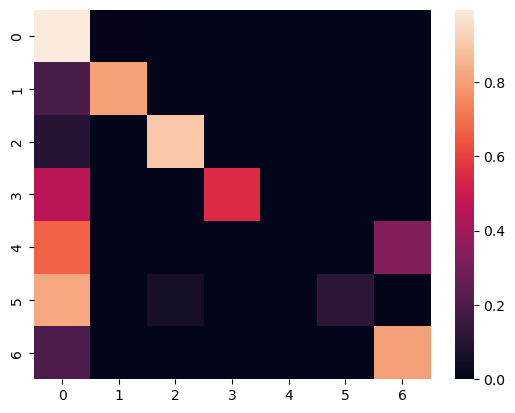

In [65]:
train_preds_rf = random_forest_pipe.predict(X_train)

confmat_train_rf = confusion_matrix(y_train, train_preds_rf, normalize = 'true')

sb.heatmap(confmat_train_rf)

plt.savefig('confmat_train_rf.png')

Notice that the random forest classifier does a poor job of predicting sinus tachycardy and sinus bradycardy diagnoses, but does a good job of predicting the other arrhythmia diagnoses.  That said, the random forest classifier overpredicts a normal diagnosis when the diagnosis is anything other than an old anterior myocardial infarction.  Additionally, the random forest classifier overpredicts a diagnosis of right bundle branch block when the actual diagnosis is sinus tachycardy.  


We will now use the `score` method of the random forest pipeline to calculate the test accuracy of the random forest classifier.

In [66]:
test_acc_rf = random_forest_pipe.score(X_test, y_test)

test_acc_rf

0.7154471544715447

From the output of the code shown above, we see that the test accuracy of the random forest classifier is $0.7154$ which means that the random forest classifier correctly predicts the arrhythmia diagnosis for $71.54\%$ of the instances in the test set.  

We will now use the `predict()` method of the random forest pipeline to predict the arrhythmia diagnosis for all the instances in the test set.  Next, we use the `confusion_matrix()` function to create a confusion matrix of the predicted arrhythmia diagnoses for the test set that is normalized according to the true arrhythmia diagnosis values.  We then use seaborn to produce a heatmap visualization of the confusion matrix and we save the resulting heatmap as a png file.

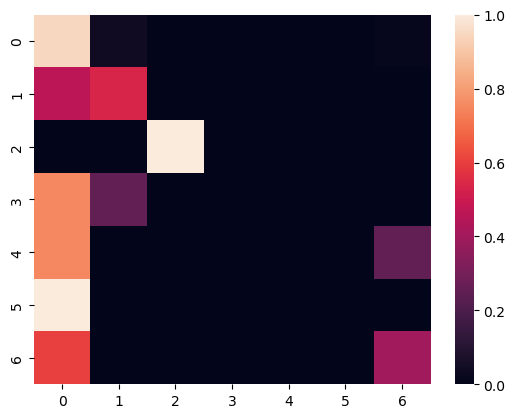

In [67]:
test_preds_rf = random_forest_pipe.predict(X_test)

confmat_test_rf = confusion_matrix(y_test, test_preds_rf, normalize = 'true')

sb.heatmap(confmat_test_rf)

plt.savefig('confmat_test_rf.png')

Observe in the confusion matrix above that the random forest classifier correctly predicts the majority of instances whose true arrhythmia diagnosis is normal, coronary artery disease, or old anterior myocardial.  Unfortunately, the random forest classifier fails to correctly predict the majority of, and in some cases, almost any of the instances whose true arrhythmia diagnosis is old inferior myocardial infarction, sinus tachycardy, sinus bradycardy, or right bundle branch block.  Notice that the random forest classifier overpredicts a diagnosis of normal when the true arrhythmia diagnosis is coronary artery disease, old inferior myocardial infarction, sinus tachycardy, sinus bradycardy, or right bundle branch block.  Additionally, notice that the random forest classifier overpredicts a diagnosis of right bundle branch block when the actual diagnosis is sinus tachycardy and the random forest classifier overpredicts a diagnosis of coronary artery disease when the true diagnosis is old inferior myocardial infarction.

# K Means Clustering

We will now perform K-means clustering and evaluate its performance on both the training and test sets.  In order to do so, we start by using the `KMeans()` function to define a K-means clusterer from scikit-learn.  We set the number of clusters for K-means clustering to $7$ since there are $7$ arrhythmia diagnoses in the dataset and we set its random state to `20221031`.  Next, we incorporate the K-means clusterer into a pipeline that first uses K-nearest neighbors to impute the missing values in the dataset, then uses the standard scaler to standardize the values in the dataset, and finally uses the K-means clusterer to perform K-means clustering.  Notice that we standardize the values because this makes K-means clustering more effective.

In [68]:
kmeans = KMeans(n_clusters = 7, random_state = 20221031)

kmeans_pipe = Pipeline(steps = [('imputer', imputer), ('scaler', scaler), ('model', kmeans)])

We will now fit the K-means clustering pipeline to the training data.

In [69]:
kmeans_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=7, random_state=20221031))])

In order to find the training accuracy of the K-means clustering pipeline, we will first use the `predict()` method to predict the arrhythmia diagnoses of all the instances in the training set.  Then, we will find the number of times that the predicted arrhythmia diagnosis matched the actual arrhythmia diagnosis for the instances in the training set and divide it by the number of instances in the training set and print the resulting training accuracy.

In [70]:
train_preds_kmeans = kmeans_pipe.predict(X_train) + 1

train_acc_kmeans = (len(np.where(train_preds_kmeans == y_train)[0]))/(len(y_train))

train_acc_kmeans

0.2992957746478873

From the output of the code shown above, we see that the training accuracy for the K-means clustering pipeline is $0.2993$, which means that the K-means clustering pipeline correctly predicted the arrhythmia diagnosis for $29.93\%$ of the instances in the training set.

We will now use the `confusion_matrix()` function to make a confusion matrix from the predicted arrhythmia diagnoses and actual arrhythmia diagnoses for the taining instances, normalized based on the actual arrythmia diagnoses.  Next, we use seaborn to create a heatmap visualization of the confusion matrix and save the visualization to a png file.

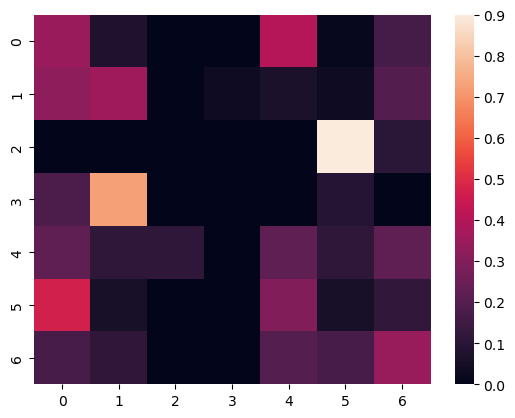

In [71]:
confmat_train_kmeans = confusion_matrix(y_train, train_preds_kmeans, normalize = 'true')

sb.heatmap(confmat_train_kmeans)

plt.savefig('confmat_train_kmeans.png')

Observe in the confusion matrix shown above that the K-means clustering pipeline seems to just randomly predict arrythmia diagnoses and does not appear to have learned any of the signal from the data.

We will now use the `predict()` method on the K-means clustering pipeline to generate predicted arrythmia diagnoses for all the instances in the test set.  As before, we then find the number of times that the predicted arrythmia diagnosis matched the actual arrythmia diagnosis from the test set and divide by the number of instances in the test set to find the test accuracy, which we then display.

In [72]:
test_preds_kmeans = kmeans_pipe.predict(X_test) + 1

test_acc_kmeans = (len(np.where(test_preds_kmeans == y_test)[0]))/(len(y_test))

test_acc_kmeans

0.25203252032520324

Based on the output of the code shown above, we see that the test acuracy of the K-means clustering pipeline is $0.2520$, which means that the K-means clustering pipeline predicted the correct arrhythmia diagnosis for $25.20\%$ of the instances in the test set.

Now, we will create a confusion matrix for the instances in the test set that is normalized based on the actual arrythmia diagnosis.  We then use seaborn to create a heatmap visualization of the confusion matrix and save it to a png file.

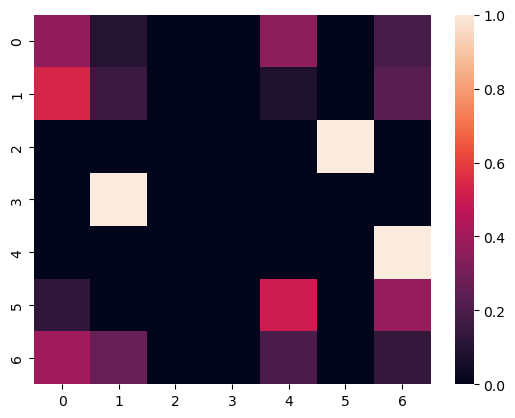

In [73]:
confmat_test_kmeans = confusion_matrix(y_test, test_preds_kmeans, normalize = 'true')

sb.heatmap(confmat_test_kmeans)

plt.savefig('confmat_test_kmeans.png')

Notice in the confusion matrix shown above that the K-means clustering pipeline is not picking up on any of the signal in the data and is predicting multiple arrhythmia diagnoses for any given arrhythmia diagnoses and very few of the predicted arrythmia diagnoses are correct.

# Feature Engineering Data Reading

In this section, we first import the cleaned arrhythmia data after feature engineering has been performed that is stored in the `arrhythmia_feat_eng.csv` file and display the first $5$ entries of the cleaned arrhythmia data with feature engineering.  We store the cleaned arrhythmia data with feature engineering in the `arrhythmia_feat_eng` variable.

In [74]:
arrhythmia_feat_eng = pd.read_csv('arrhythmia_feat_eng.csv')

arrhythmia_feat_eng.head()

Age  Sex  Height (cm)  Weight (kg)  QRS Duration (msec)  \
0   56    1          165           64                   81   
1   54    0          172           95                  138   
2   55    0          175           94                  100   
3   40    1          160           52                   77   
4   49    1          162           54                   78   

   P-R Interval (msec)  Q-T Interval (msec)  T Interval (msec)  \
0                  174                  401                149   
1                  163                  386                185   
2                  202                  380                179   
3                  129                  377                133   
4                    0                  376                157   

   P Interval (msec)  Vector Angles for QRS (degrees)  ...  \
0                 39                               25  ...   
1                102                               96  ...   
2                143                               28  ...   
3                 77                               77  ...   
4                 70                               67  ...   

   Amplitude *0.1 mV of JJ Wave  Amplitude *0.1 mV of Q Wave  \
0                      0.098915                    -0.911507   
1                      0.098915                    -0.911507   
2                      0.098915                    -0.911507   
3                      0.098915                    -0.911507   
4                      0.098915                    -0.911507   

   Amplitude *0.1 mV of R Wave  Amplitude *0.1 mV of S Wave  \
0                     5.976065                    -3.657985   
1                     5.976065                    -3.657985   
2                     5.976065                    -3.657985   
3                     5.976065                    -3.657985   
4                     5.976065                    -3.657985   

   Amplitude *0.1 mV of R' Wave  Amplitude *0.1 mV of S' Wave  \
0                      0.080979                     -0.006306   
1                      0.080979                     -0.006306   
2                      0.080979                     -0.006306   
3                      0.080979                     -0.006306   
4                      0.080979                     -0.006306   

   Amplitude *0.1 mV of P Wave  Amplitude *0.1 mV of T Wave      QRSA  \
0                     0.308559                     1.211609  3.695762   
1                     0.308559                     1.211609  3.695762   
2                     0.308559                     1.211609  3.695762   
3                     0.308559                     1.211609  3.695762   
4                     0.308559                     1.211609  3.695762   

       QRSTA  
0  14.802457  
1  14.802457  
2  14.802457  
3  14.802457  
4  14.802457  

[5 rows x 37 columns]

# Feature Engineering Data Preparation

We will now extract the feature values from the cleaned arrhythmia data with feature engineering by dropping the response value, Arrhythmia Class, from the `arrhythmia_feat_eng` data frame.  These feature values are stored in the variable `X_feat_eng`.  Similarly, we extract the response values from the cleaned arrhythmia data with feature engineering into the variable `y_feat_eng` by extracting the Arrhythmia Class column from the `arrhythmia_feat_eng` data frame.  

We then split the data into a training and test set using the `train_test_split()` function.  For this project, the training set will contain $70\%$ of the cleaned arrhythmia data with feature engineering and the test set will contain $30\%$ of the cleaned arrhythmia data with feature engineering.  When we split the data into a training and test set, we will stratify the data in both the training and test set according to the arrhythmia class labels stored in the variable `y_feat_eng`.  We also set the random state to `20221031` to ensure that the results are reproducible.

Note that the feature values from the training set are stored in `X_train_fe`, the feature values from the test set are stored in `X_test_fe`, the response values from the training set are stored in `y_train_fe`, and the feature values from the test set are stored in `y_test_fe`.  

In [75]:
X_feat_eng = arrhythmia_feat_eng.drop(['Arrhythmia Class'], axis = 1)

y_feat_eng = arrhythmia_feat_eng['Arrhythmia Class']

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_feat_eng, y_feat_eng, test_size = 0.3,
                                                                random_state = 20221031, stratify = y_feat_eng)

# Feature Engineering Data Pipeline

We will now define instances of data processing methods that will be used in the following sections.  First, since we have missing data, we will need to impute the missing data.  This missing data imputation will be performed using K-nearest neighbors imputation with the `KNNImputer()` from scikit-learn.  The `KNNImputer()` that we will use is stored in the `imputer_fe` variable.  

For using K-means clustering, we will need to first standardize our feature values, which will be done using the `StandardScaler()` from scikit-learn.  This instance of `StandardScaler()` is stored in the `scaler_fe` variable. 

We will also use the `StratifiedKFold()` function to set-up 5-fold cross-validation for hyperparameter tuning later in this section.  For 5-fold cross_validation, we set `n_splits = 5`, `shuffle = True`, and `random_state = 20221031` to shuffle the data before splitting it into $5$ folds for 5-fold cross-validation.  Since we are using `StratifiedKFold()`, the $5$ folds will be stratified by arrhythmia class so that each fold has the same proportion of arrhythmia class labels as the original training data set. We store the resulting object in the `skf_fe` variable.

In [76]:
imputer_fe = KNNImputer()

scaler_fe = StandardScaler()

skf_fe = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20221031)

# Feature Engineering Decision Tree

In this section, we will create a pipeline to impute the missing data and fit a decision tree classifier, perform extensive hyperparameter tuning using both grid search and randomized search, update the hyperparameter values of the decision tree classifier to match those with the highest accuracy across the hyperparameter tuning searches, train the decision tree classifier to the entire training dataset, examine its feature importances, and examine its performance on both the training and test sets.

First, we will create a decision tree classifier that uses `gini` as its criterion using the `DecisionTreeClassifier` from scikit-learn.  We then incorporate this decision tree classifier into a pipeline that first uses the `KNNImputer` defined earlier to impute the missing data using K-nearest neighbors imputation and then uses the decision tree classsifier.

In [77]:
decision_tree_fe = DecisionTreeClassifier(criterion = 'gini', random_state = 20221031)

decision_tree_pipe_fe = Pipeline(steps = [('imputer', imputer_fe), ('model', decision_tree_fe)])

We will now define a parameter grid over which to perform grid search for hyperparameter tuning.  In this parameter grid, we consider a maximum tree depth between $2$ and $6$, minimum numbers of samples in each leaf node of $2$, $4$, $8$, or $16$, the `best` and `random` splitters, and a maximum number of features to use when fitting the decision tree of `None`, `sqrt`, or `log2`.  

We then use `GridSearchCV` to perform hyperparameter tuning on the pipeline that includes the decision tree classifier with the parameter grid that we specify below, using the stratified 5-fold for cross-validation that we set up previously, and scoring the cross-validation results on classification accuracy.  We then fit the grid search object to the training data.

In [78]:
param_grid_dt_fe = {
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_leaf': [2, 4, 8, 16],
    'model__splitter': ['best', 'random'],
    'model__max_features': [None, 'sqrt', 'log2']
}

grid_search_dt_fe = GridSearchCV(decision_tree_pipe_fe, param_grid = param_grid_dt_fe, cv = skf_fe,
                                 scoring = 'accuracy')

grid_search_dt_fe.fit(X_train_fe, y_train_fe)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=20221031))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6],
                         'model__max_features': [None, 'sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 8, 16],
                         'model__splitter': ['best', 'random']},
             scoring='accuracy')

After performing grid search to perform hyperparameter tuning on the decision tree classifier pipeline, we will first use the `grid_search_results()` function that we wrote earlier to extract the results from the grid search to a data frame, then rename the columns of the grid search results data frame, and display the first $5$ entries of the grid search results data frame.

In [79]:
gs_results_dt_fe = grid_search_results(grid_search_dt_fe)

gs_results_dt_fe.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

gs_results_dt_fe.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          2         None                 2     best  0.644361
1          2         None                 2   random  0.602193
2          2         None                 4     best  0.626692
3          2         None                 4   random  0.602193
4          2         None                 8     best  0.637281

We will now use the `fix_none_vals()` function that we wrote earlier to convert `None` values to `'None'` values in the data frame of grid search results.  This is done so that we can better visualize the grid search results using seaborn.

In [80]:
gs_results_dt_fe = fix_none_vals(gs_results_dt_fe)

Since we used too many hyperparameters during grid search to create a plot of the results in seaborn, we will now use the `split_results()` function to split the data frame of grid search results into two smaller dataframes of grid search results which were split on the value of the `Splitter` hyperparameter in grid search.  The first data frame contains the grid search results whose `Splitter` value is `best` and the second data frame contains the grid search results whose `Splitter` values is `random`.

In [81]:
gs_results_dt_fe_best, gs_results_dt_fe_random = split_results(gs_results_dt_fe, 'Splitter')

We will now plot the results of the grid search whose `Splitter` value is `best` using the `plot_grid_search()` function that we wrote previously.  In the resulting line plot, we put `Max Depth` on the x-axis, determine the color of each line using the value of `Min Leaf Samples`, and determine the line style using the value of `Max Features`.  After we display the plot, we save it to a png file using the `plt.savefig()` function.

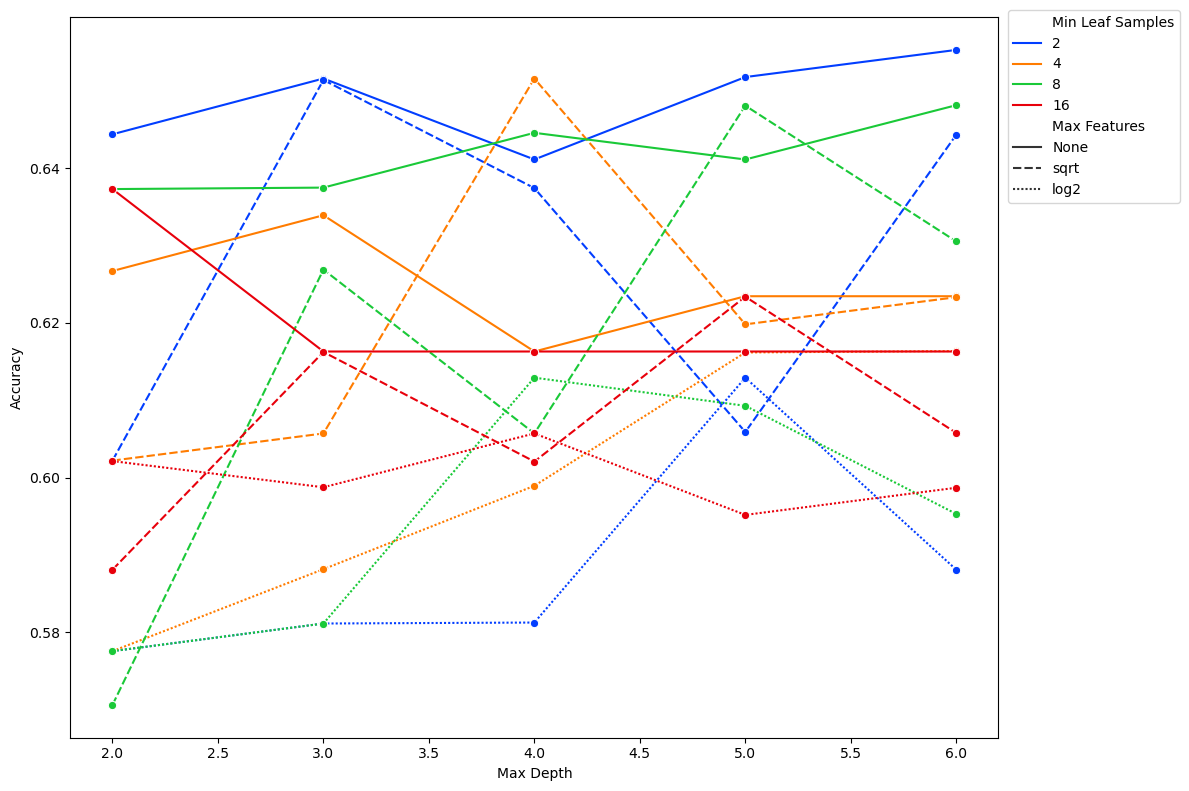

In [82]:
plt.figure(figsize = (12, 8))

gs_dt_fe_plot1 = plot_grid_search(gs_results_dt_fe_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('grid_search_results_dt_fe_best.png')

We will now plot the results of the grid search whose `Splitter` value is `random` using the `plot_grid_search()` function that we wrote previously.  In the resulting line plot, we put `Max Depth` on the x-axis, determine the color of each line using the value of `Min Leaf Samples`, and determine the line style using the value of `Max Features`.  After we display the plot, we save it to a png file using the `plt.savefig()` function.

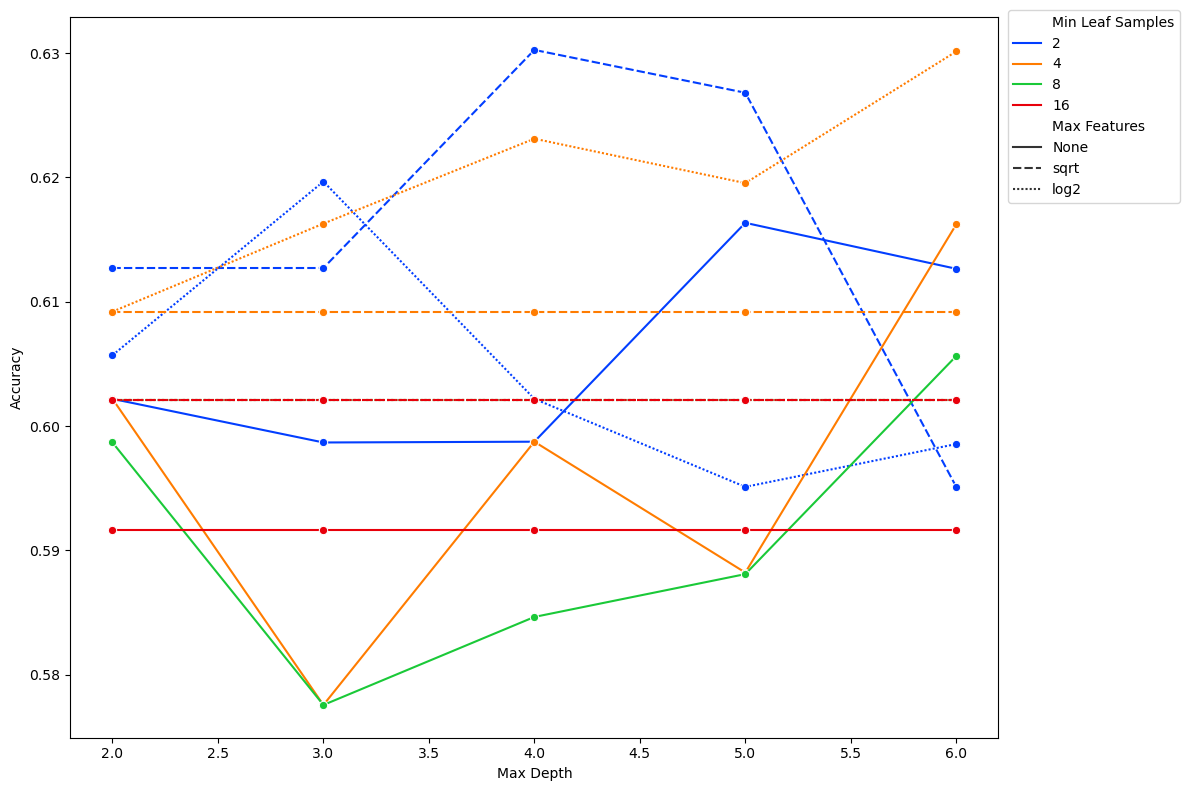

In [83]:
plt.figure(figsize = (12, 8))

gs_dt_fe_plot2 = plot_grid_search(gs_results_dt_fe_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('grid_search_results_dt_fe_random.png')

In order to determine the optimal hyperparameter values from grid search, we will sort the grid search results data frame by descending classification accuracy and display the resulting data frame.

In [84]:
gs_results_dt_fe.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
96          6         None                 2     best  0.655263
72          5         None                 2     best  0.651754
58          4         sqrt                 4     best  0.651566
24          3         None                 2     best  0.651566
32          3         sqrt                 2     best  0.651378
..        ...          ...               ...      ...       ...
27          3         None                 4   random  0.577569
29          3         None                 8   random  0.577569
18          2         log2                 4     best  0.577569
16          2         log2                 2     best  0.577569
12          2         sqrt                 8     best  0.570614

[120 rows x 5 columns]

We will now use randomized search to perform further hyperparameter tuning on the decision tree classifier pipeline.  In order to do so, we first create a dictionary of probability distributions over the hyperparameters.  Notice that we are putting a discrete uniform distribution over the maximum depth of the tree and the minimum number of samples in each leaf node.  The discrete uniform distribution over the maximum depth of the tree considers tree depths between $2$ and $6$, while the discrete uniform distribution over the minimum number of samples in each leaf node considers values between $2$ and $16$.  For the categorical hyperpameters maximum number of features and splitter, we provide a list of possible values.  The possible values for the maximum number of features are `None`, `sqrt`, and `log2` while the possible values for the splitter are `best` and `random`.  

We then use the `RandomizedSearchCV()` function to set up the randomized search procedure by passing it the decision tree classifier pipeline, setting the parameter distributions to the dictionary of values defined below, using the stratified 5-folds for cross-validation, setting the number of iterations of random search to $100$, and using the classification accuracy as the scoring metric.  We then fit the randomized search to the training data.

In [85]:
param_dist_dt_fe = {
    'model__max_depth': stats.randint(2, 7),
    'model__min_samples_leaf': stats.randint(2, 17),
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__splitter': ['best', 'random']
}

random_search_dt_fe = RandomizedSearchCV(decision_tree_pipe_fe, param_distributions = param_dist_dt_fe,
                                         cv = skf_fe, n_iter = 100, scoring = 'accuracy', random_state = 20221031)

random_search_dt_fe.fit(X_train_fe, y_train_fe)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=20221031))]),
                   n_iter=100,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f03141ef0d0>,
                                        'model__max_features': [None, 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f03141155e0>,
                                        'model__splitter': ['best', 'random']},
                   random_state=20221031, scoring='accuracy')

We will now use the `grid_search_results()` function to extract the randomized search results into a data frame, rename the columns of the data frame, and display the first $5$ rows of the randomizes search results data frame.

In [86]:
rs_results_dt_fe = grid_search_results(random_search_dt_fe)

rs_results_dt_fe.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

rs_results_dt_fe.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          6         sqrt                10   random  0.602130
1          6         log2                 6     best  0.591667
2          3         log2                 8   random  0.602130
3          2         None                 2   random  0.602193
4          6         None                 2   random  0.612657

We will now call `fix_none_vals()` to convert values of `None` to values of `'None'` in the data frame of randomized search results to make it easier to visualize these results.

In [87]:
rs_results_dt_fe = fix_none_vals(rs_results_dt_fe)

As before, we have too many hyperparameters in the randomized search to simply create a plot of all the randomized search results at once using seaborn so we will now use `split_results()` to create two smaller data frames of randomized search results.  The first data frame contains the randomized search results whose value of `Splitter` is `best` and the second data frame contains the randomized search results whose value of `Splitter` is `random`.

In [88]:
rs_results_dt_fe_best, rs_results_dt_fe_random = split_results(rs_results_dt_fe, 'Splitter')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Splitter` value is `best`.  In this scatterplot, the values of `Max Depth` are on the x-axis, the hue of each point is determined by the value of `Min Leaf Samples`, and the size of each point is determined by the value of `Max Features`.  The cross-validation accuracy is shown on the y-axis and after displaying the scatterplot, we save it to a png file using the `plt.savefig()` function.

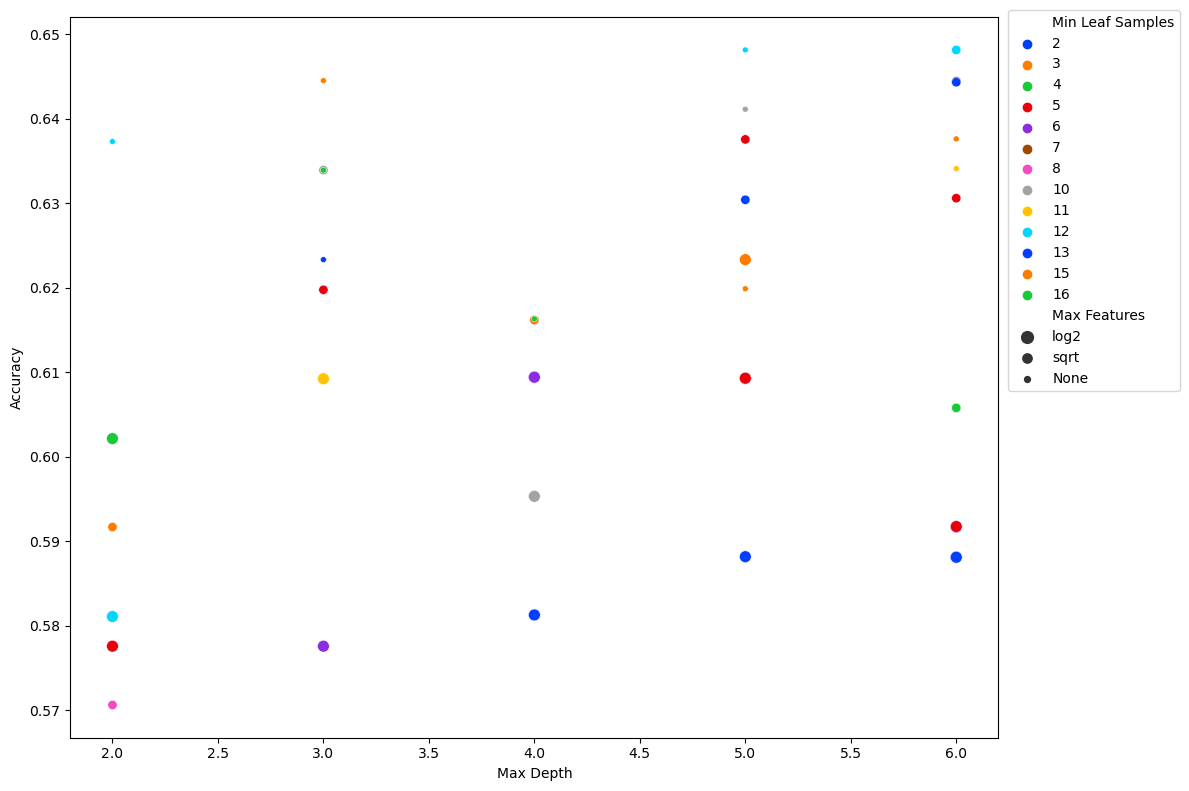

In [89]:
plt.figure(figsize = (12, 8))

rs_dt_fe_plot1 = plot_random_search(rs_results_dt_fe_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('random_search_results_dt_fe_best.png')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Splitter` value is `random`.  In this scatterplot, the values of `Max Depth` are on the x-axis, the hue of each point is determined by the value of `Min Leaf Samples`, and the size of each point is determined by the value of `Max Features`.  The cross-validation accuracy is shown on the y-axis and after displaying the scatterplot, we save it to a png file using the `plt.savefig()` function.

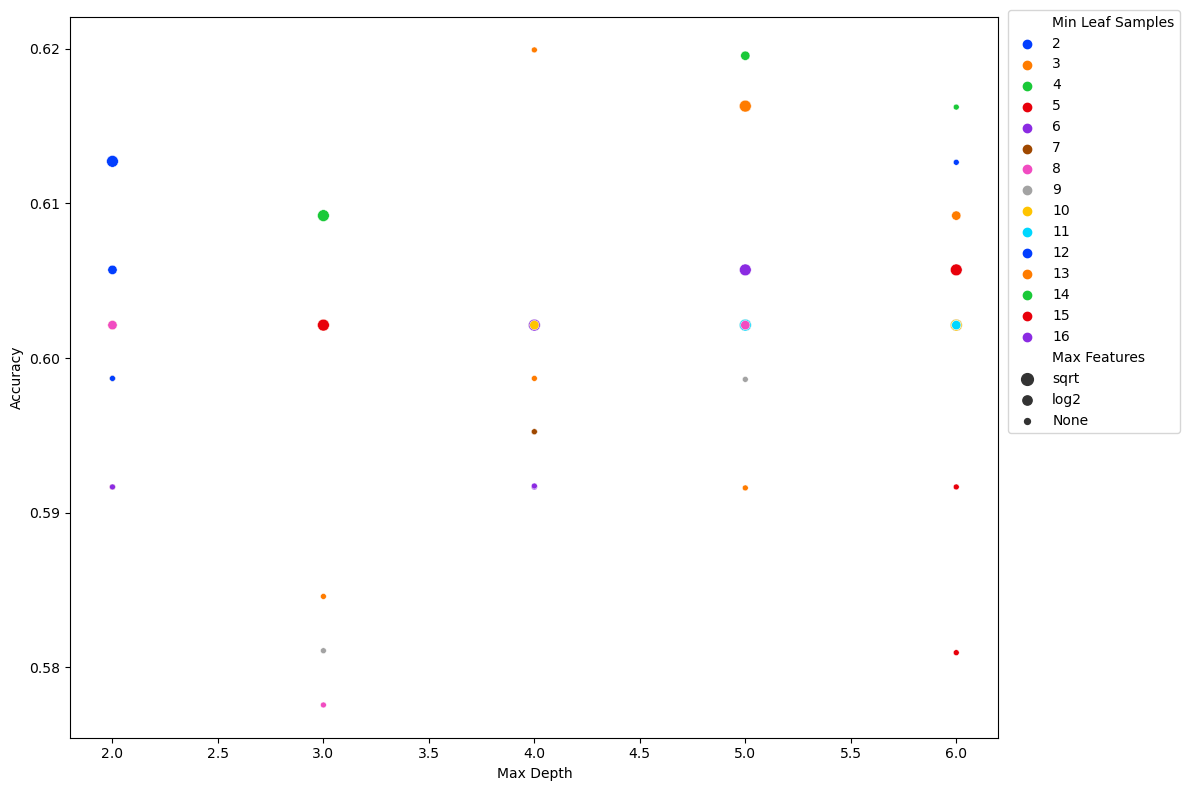

In [90]:
plt.figure(figsize = (12, 8))

rs_dt_fe_plot2 = plot_random_search(rs_results_dt_fe_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('random_search_results_dt_fe_random.png')

We will now find the best combination of hyperparameter values from the randomized search procedure by sorting the values in the data frame of randomized search results in descending order according to their classification accuracy.

In [91]:
rs_results_dt_fe.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
58          5         None                12     best  0.648120
71          6         sqrt                12     best  0.648120
18          3         None                 3     best  0.644486
24          6         sqrt                 7     best  0.644424
74          6         sqrt                 2     best  0.644298
..        ...          ...               ...      ...       ...
15          6         None                 5   random  0.580952
56          3         None                 8   random  0.577569
85          2         log2                 5     best  0.577569
96          3         log2                 6     best  0.577569
6           2         sqrt                 8     best  0.570614

[100 rows x 5 columns]

We will now use Bayes search to perform further hyperparameter tuning.  Notice that for Bayes search, we define a dictionary containing prior probability distributions over the hyperparameters.  Here, we put a discrete uniform prior distribution from $2$ to $6$ over the max depth and we put a discrete uniform prior distribution from $2$ to $16$ over the minimum number of samples in each leaf node.  We pick the maximum number of features from `None`, `sqrt`, and `log2` and we pick the splitter from `best` and `random`.  

Next, we use the `BayesSearchCV()` function to set up the Bayes search procedure.  For Bayes search, we perform $100$ iterations over the hyperparameter distributions using the decision tree pipeline from before.  We also use the stratified 5-fold for cross-validation from above and use scoring as the accuracy metric.  We then fit the Bayes search procedure to the training data.

In [34]:
bayes_dist_dt_fe = {
    'model__max_depth': Integer(2, 6),
    'model__min_samples_leaf': Integer(2, 16),
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__splitter': ['best', 'random']
}

bayes_search_dt_fe = BayesSearchCV(decision_tree_pipe_fe, search_spaces = bayes_dist_dt_fe, cv = skf_fe,
                                   scoring = 'accuracy', n_iter = 100, random_state = 20221031)

bayes_search_dt_fe.fit(X_train_fe, y_train_fe)

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
              estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                        ('model',
                                         DecisionTreeClassifier(random_state=20221031))]),
              n_iter=100, random_state=20221031, scoring='accuracy',
              search_spaces={'model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'model__max_features': [None, 'sqrt', 'log2'],
                             'model__min_samples_leaf': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'model__splitter': ['best', 'random']})

We will now create a data frame containing the results from the Bayes search and display the first $5$ entries of this data frame.

In [35]:
bayes_results_dt_fe = grid_search_results(bayes_search_dt_fe)

bayes_results_dt_fe.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

bayes_results_dt_fe.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          4         log2                14   random  0.602130
1          4         sqrt                 3     best  0.647932
2          5         None                15   random  0.591667
3          5         None                 6     best  0.644612
4          4         sqrt                 7   random  0.602130

We will now convert values of `None` to values of `'None'` in the data frame of Bayes search results so that we can better visualize these results later.

In [36]:
bayes_results_dt_fe = fix_none_vals(bayes_results_dt_fe)

Now, we will split the data frame containing the Bayes search results into two smaller data frames based on the value of the `Splitter` hyperparameter.  This will allow us to more easily visualize the Bayes search results.

In [37]:
bayes_results_dt_fe_best, bayes_results_dt_fe_random = split_results(bayes_results_dt_fe, 'Splitter')

We will now produce two scatterplots showing the Bayes search results and save these figures.

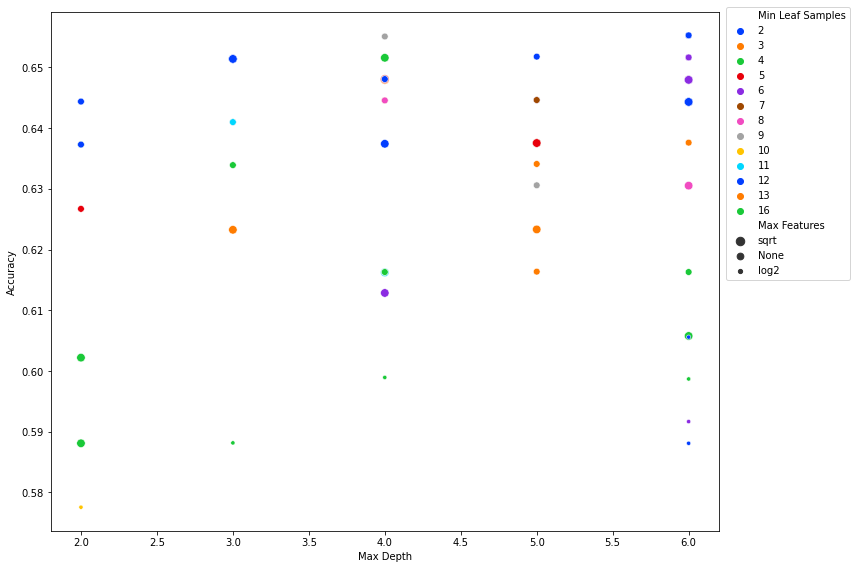

In [38]:
plt.figure(figsize = (12, 8))

bayes_dt_fe_plot1 = plot_random_search(bayes_results_dt_fe_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('bayes_search_results_dt_fe_best.png')

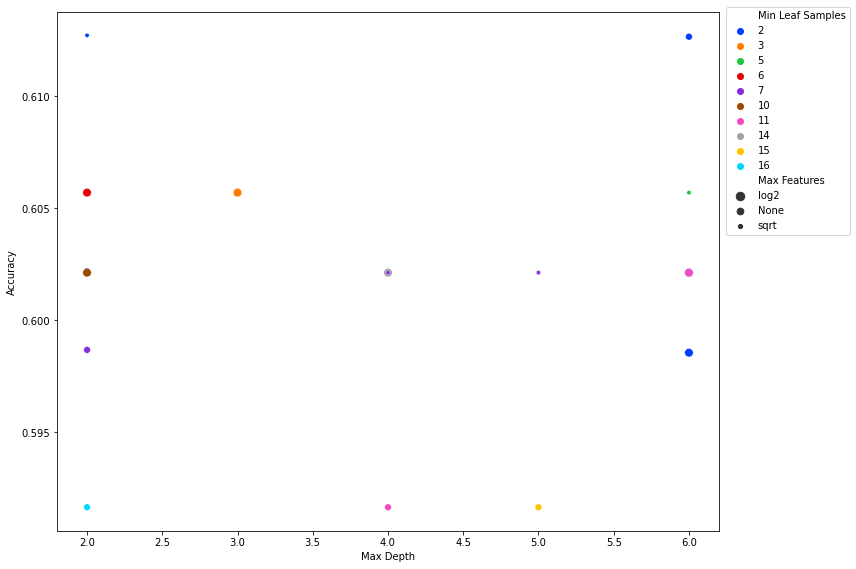

In [39]:
plt.figure(figsize = (12, 8))

bayes_dt_fe_plot2 = plot_random_search(bayes_results_dt_fe_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('bayes_search_results_dt_fe_random.png')

We will now sort the data frame containing the Bayes search results in descending order of classification accuracy so that we can see the best results from the Bayes search.

In [40]:
bayes_results_dt_fe.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
57          6         None                 2     best  0.655263
87          6         None                 2     best  0.655263
59          6         None                 2     best  0.655263
95          6         None                 2     best  0.655263
94          6         None                 2     best  0.655263
..        ...          ...               ...      ...       ...
42          6         log2                 6     best  0.591667
26          3         log2                 4     best  0.588158
41          2         sqrt                16     best  0.588095
91          6         log2                 2     best  0.588095
70          2         log2                10     best  0.577569

[100 rows x 5 columns]

Based on the results from both the grid search and randomized search procedures, we see that the best combination of hyperparameter values is a maximum depth of $6$, a maximum number of features of `None`, a minimum of $2$ samples in each leaf node, and using the `best` splitter.  We will now use the `set_params()` function to set the hyperparameters of the decision tree classifier in the decision tree classifier pipeline to the aforementioned values.

In [92]:
decision_tree_pipe_fe.set_params(**{'model__max_depth': 6, 'model__min_samples_leaf': 2, 
                                    'model__max_features': None, 'model__splitter': 'best'})

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=2,
                                        random_state=20221031))])

We will now fit the decision tree classifier pipeline with the optimal hyperparamter values found by performing both grid search and randomized search to the entire training dataset.

In [93]:
decision_tree_pipe_fe.fit(X_train_fe, y_train_fe)

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=2,
                                        random_state=20221031))])

Here, we will plot the best decision tree using the `plot_tree()` function, fill in the boxes in the plot, and save the plot to a pdf using the `plt.savefig()` function.

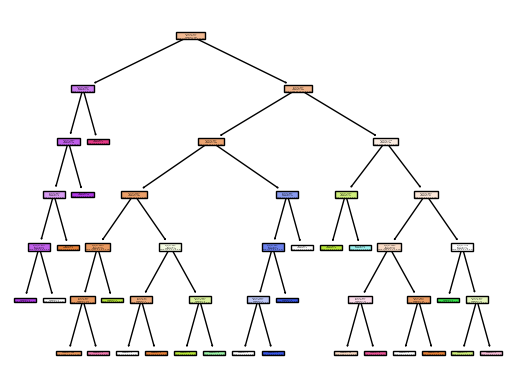

In [94]:
plot_tree(decision_tree_pipe_fe[1], filled = True)

plt.savefig('arrhythmia_decision_tree_fe.pdf')

We now want to determine which of the features from a patient's EKG data were important in predicting their arrhythmia diagnosis, meaning which of the features from a patient's EKG data had a nonzero feature importance.  In order to do so, we will first extract the feature importances from the decision tree classifier portion of the decision tree plipeline.  We will then use the `importance_df()` function to create a data frame from the feature importances in the decision tree classifier and we then display that data frame.

In [95]:
importances_dt_fe = decision_tree_pipe_fe[1].feature_importances_

importance_df_dt_fe = importance_df(importances_dt_fe, X_train_fe.columns)

importance_df_dt_fe

Feature Name  Feature Importance
10                 Heart Rate (bpm)            0.294884
2               QRS Duration (msec)            0.211674
7   Vector Angles for QRS (degrees)            0.145440
8     Vector Angles for T (degrees)            0.105379
3               P-R Interval (msec)            0.064901
1                       Height (cm)            0.051294
5                 T Interval (msec)            0.044681
6                 P Interval (msec)            0.034722
4               Q-T Interval (msec)            0.034365
9     Vector Angles for P (degrees)            0.007234
0                               Sex            0.005425

Notice that there are $11$ features from a patient's EKG data that have a nonzero feature importance and are therefore important in predicting a patient's arrhythmia diagnosis.  Further notice that most of these features concern the duration of various intervals in a patient's EKG and that two demographic features are very important in predicting a patient's arrhythmia diagnosis: height and sex.  Observe that the most important feature in predicting a patient's arrhythmia diagnosis is their heart rate.

We will now use the `plot_feat_importances()` function to further visualize the most important features from a patient's EKG data.  This function returns a bar plot showing the feature importance on the y-axis and the name of the feature on the x-axis.  We will save this bar plot to a png file using the `plt.savefig()` function.

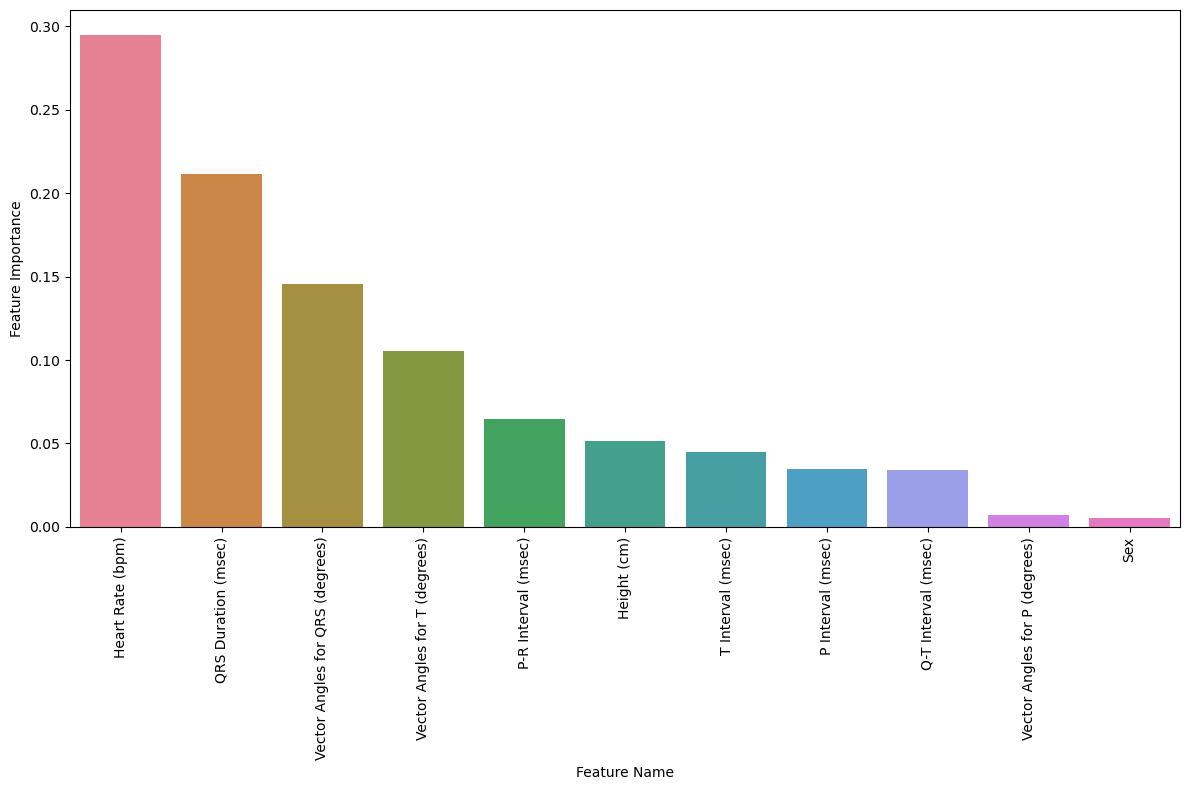

In [186]:
plt.figure(figsize = (12, 8))

dt_fe_feat_imp_plot = plot_feat_importances(importance_df_dt_fe)

plt.tight_layout()

plt.savefig('dt_fe_feat_imp_plot.png')

In order to determing whether the best decision tree classifier suffers from overfitting or underfitting, we will use the `learning_curve()` function that we pass the decision tree pipeline, the training data, the stratified 5-fold data, training sizes between $0.1$ and $1.0$ counting by $0.1$, and scoring on classification accuracy.

In [97]:
_, train_scores_dt_fe, test_scores_dt_fe = learning_curve(decision_tree_pipe_fe, X_train_fe, y_train_fe,
                                                          scoring = 'accuracy', train_sizes = train_fractions,
                                                          cv = skf_fe, return_times = False)

We will now use the `plot_learning_curve()` function to plot the results from the `learning_curve()` function and we save the plot to a png file using the `plt.savefig()` function.

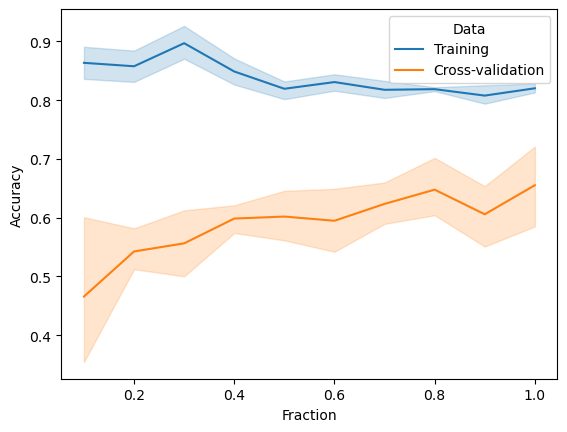

In [98]:
plot_learning_curve(train_fractions, train_scores_dt_fe, test_scores_dt_fe)

plt.savefig('learning_curve_dt_fe.png')

We will now use the `score` method of the decision tree pipeline to find its training accuracy, which we then display.

In [99]:
train_acc_dt_fe = decision_tree_pipe_fe.score(X_train_fe, y_train_fe)

train_acc_dt_fe

0.8204225352112676

Notice that the best decision tree classifier has a training accuracy of $0.8204$ which means that it correctly classifies $82.04\%$ of the instances in the training dataset.  

We will now create a confusion matrix for the training predictions of the best decision tree classifier by first generating predicted arrhythmia diagnoses for the instances in the training dataset, then creating a confusion matrix from those predictions and the actual diagnoses.  In the confusion matrix, we normalize by the true arrhythmia diagnosis so that more frequently occurring classes do not disproportionately impact the confusion matrix visualization.  We then produce a heatmap using seaborn of the confusion matrix so that we can more easily visualize the confusion matrix and we save it to a png file.

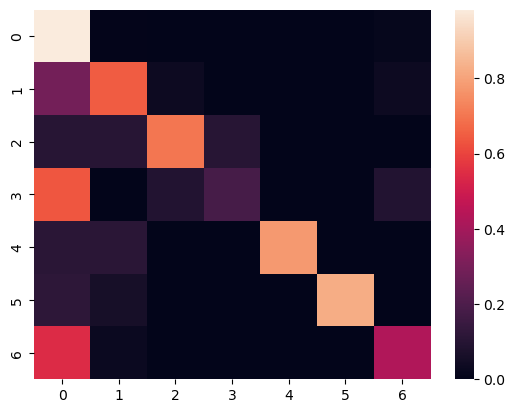

In [100]:
train_preds_dt_fe = decision_tree_pipe_fe.predict(X_train_fe)

confmat_train_dt_fe = confusion_matrix(y_train_fe, train_preds_dt_fe, normalize = 'true')

sb.heatmap(confmat_train_dt_fe)

plt.savefig('confmat_train_dt_fe.png')

Observe that the best decision tree classifier does a good job of predicting the diagnoses of the instances in the training set overall.  Notice that the best decision tree classifier correctly predicts the arrhythmia diagnosis for the vast majority of instances whose true arrythmia diagnosis is normal, coronary artery disease, old anterior myocardial infarction, sinus tachycardy, and sinus bradycardy.  However, we see that the decision tree classifier will overpredict a normal diagnosis when the actual diagnosis is coronary artery disease, old inferior myocardial infarction, or right bundle branch block.  Notice that the decision tree classifier has especially poor performance when the actual arrythmia diagnosis is an old inferior myocardial infarction or a right bundle branch block since it predicts a diagnosis of normal for the majority of these instances.

We will now use the `score` method of the decision tree pipeline to calculate the test accuracy of the best decision tree classifier and we will then display the test accuracy.

In [101]:
test_acc_dt_fe = decision_tree_pipe_fe.score(X_test_fe, y_test_fe)

test_acc_dt_fe

0.6097560975609756

From the output of the code shown above, we see that the test accuracy of the best decision tree is $0.6098$ which means that the best decision tree correctly classifies $60.98\%$ of the instances in the test set.

We will now use the decision tree pipeline to generate predicted arrhythmia diagnoses for each instance in the test set.  Then, we will create a confusion matrix using the predicted and actual arrhythmia diagnoses from the test set that is normalized according to the true diagnosis.  We will then use seaborn to create a heatmap from the confusion matrix in order to better visualize the classification mistakes that the best decision tree pipeline is making on the test set and we will save the plot to a png file.

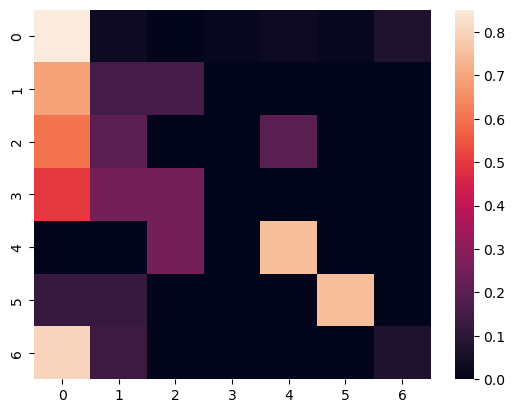

In [102]:
test_preds_dt_fe = decision_tree_pipe_fe.predict(X_test_fe)

confmat_test_dt_fe = confusion_matrix(y_test_fe, test_preds_dt_fe, normalize = 'true')

sb.heatmap(confmat_test_dt_fe)

plt.savefig('confmat_test_dt_fe.png')

Notice in the heatmap confusion matrix visualization shown above that the best decision tree classifier correctly predicts the diagnosis of most of the instances whose actual arrhythmia diagnosis is normal, sinus tachycardy, or sinus bradycardy.  However, the best decision tree classifier predicts a normal diagnosis for the majority of instances when the true diagnosis is coronary artery disease, old inferior myocardial infarction, old inferior myocardial infarction, or a right bundle branch block.  Additionally, the best decision tree classifier overpredicts a diagnosis of coronary artery disease or sinus tachycardy when the actual arrhythmia diagnosis is old anterior myocardial infarction and the best decision tree classifier overpredicts a diagnosis of coronary artery disease or old anterior myocardial infarction when the actual diagnosis is old inferior myocardial infarction.  Finally, the best decision tree classifier overpredicts a diagnosis of old anterior myocardial infarction when the actual diagnosis is sinus tachycardy.

# Feature Engineering Random Forest

In this section, we will fit a random forest classifier to the data, perform hyperparameter tuning using both grid search, randomized search, and Bayes search, update the hyperparameters of the random forest classifier to the best values from hyperparameter tuning, examine the important features from the random forest classifier, and evaluate the training and test performance of the best random forest classifier.

To start, we will define a random forest classifier that uses the `gini` criterion by using the `RandomForestClassifier()` function from scikit-learn.  We will then incorporate this random forest classifier into a pipeline that first performs K-nearest neighbors imputation and then fits a random forest classifier.

In [103]:
random_forest_fe = RandomForestClassifier(criterion = 'gini', random_state = 20221031)

random_forest_pipe_fe = Pipeline(steps = [('imputer', imputer_fe), ('model', random_forest_fe)])

We will now perform grid search for hyperparameter tuning.  This grid search will consider using $50$, $75$, $100$, and $125$ decision trees in the random forest, using decision trees with a maximum depth between $2$ and $6$ in the random forest, using decision trees with a minimum number of leaf samples of $2$, $4$, $8$, or $16$ in the random forest, and using a maximum number of features of `sqrt` or `log2` in each decision tree in the random forest.  

We then use the `GridSearchCV()` function to set up the grid search procedure.  Notice that we pass the grid search procedure the random forest pipeline, the parameter grid defined below, the stratified 5-fold that we defined previously, and we use classification accuracy as the scoring metric.  We then fit the grid search procedure to the training data.

In [104]:
param_grid_rf_fe = {
    'model__n_estimators': [50, 75, 100, 125],
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_leaf': [2, 4, 8, 16],
    'model__max_features': ['sqrt', 'log2']
}

grid_search_rf_fe = GridSearchCV(random_forest_pipe_fe, param_grid = param_grid_rf_fe, cv = skf_fe, 
                                 scoring = 'accuracy')

grid_search_rf_fe.fit(X_train_fe, y_train_fe)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('model',
                                        RandomForestClassifier(random_state=20221031))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 8, 16],
                         'model__n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

We will now create a data frame of the grid search results and display the first $5$ entries.

In [105]:
gs_results_rf_fe = grid_search_results(grid_search_rf_fe)

gs_results_rf_fe.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

gs_results_rf_fe.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          2         sqrt                 2              50   0.60213
1          2         sqrt                 2              75   0.60213
2          2         sqrt                 2             100   0.60213
3          2         sqrt                 2             125   0.60213
4          2         sqrt                 4              50   0.60213

We will now split the grid search results into two data frames based on the value of the `Max Features` hyperparameter so that we can visualize these results.

In [106]:
gs_results_rf_fe_sqrt, gs_results_rf_fe_log2 = split_results(gs_results_rf_fe, 'Max Features')

We will now produce two lineplots of the grid search results and save the images.

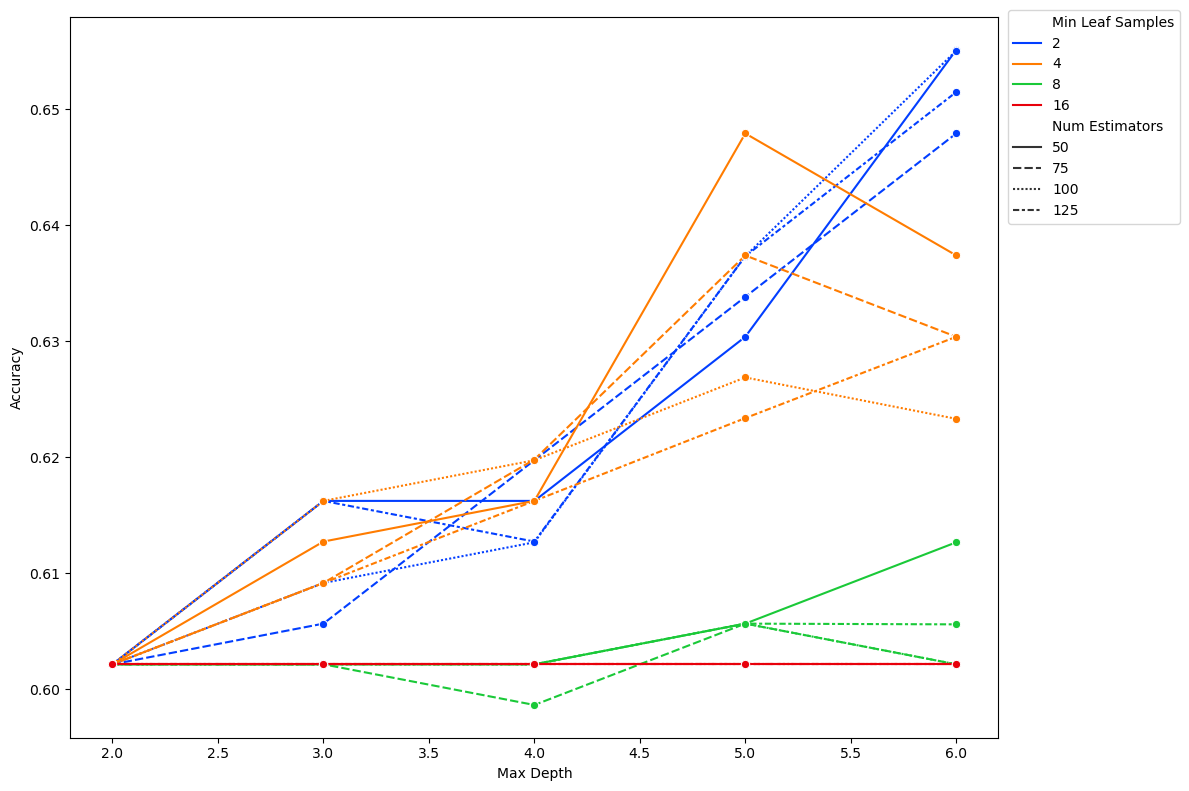

In [107]:
plt.figure(figsize = (12, 8))

gs_rf_fe_plot1 = plot_grid_search(gs_results_rf_fe_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('grid_search_results_rf_fe_sqrt.png')

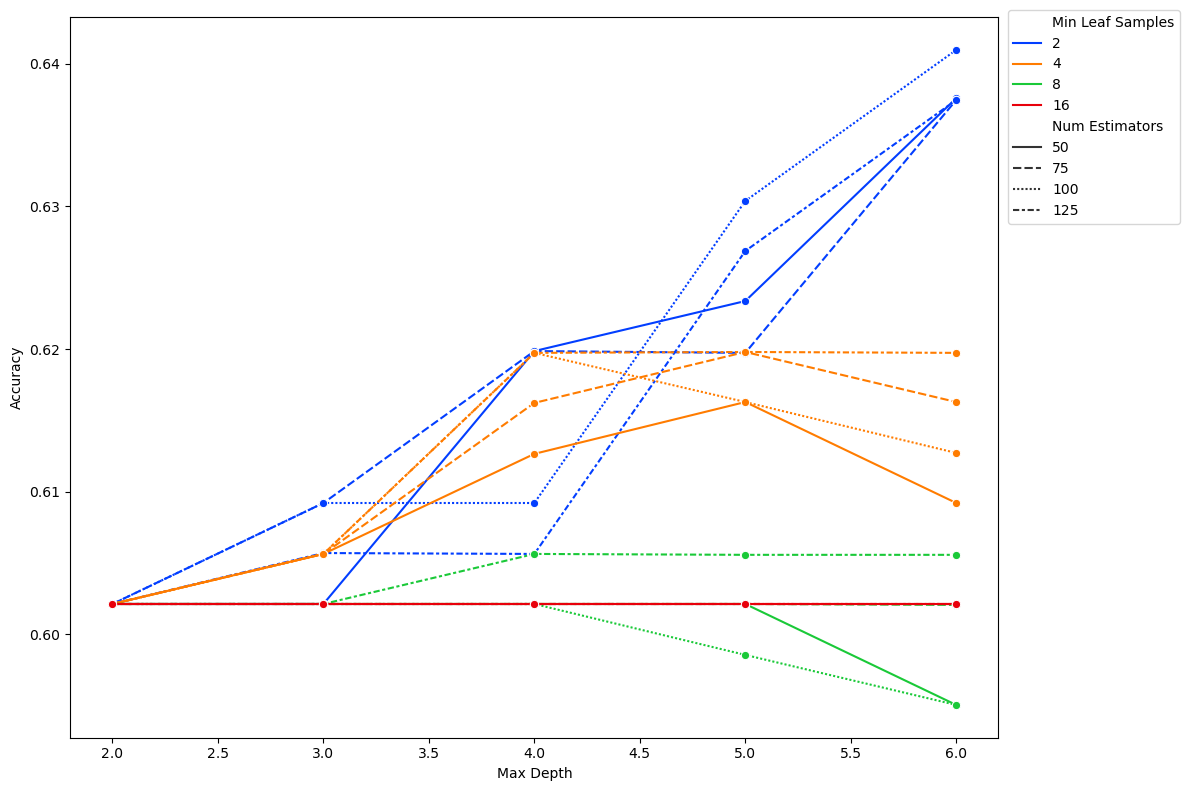

In [108]:
plt.figure(figsize = (12, 8))

gs_rf_fe_plot2 = plot_grid_search(gs_results_rf_fe_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('grid_search_results_rf_fe_log2.png')

We will now sort the grid search results in order of descending classification accuracy in order to determine the best hyperparameters for the random forest.

In [109]:
gs_results_rf_fe.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
128          6         sqrt                 2              50  0.655138
130          6         sqrt                 2             100  0.655075
131          6         sqrt                 2             125  0.651504
129          6         sqrt                 2              75  0.647932
100          5         sqrt                 4              50  0.647932
..         ...          ...               ...             ...       ...
153          6         log2                 8              75  0.602068
73           4         sqrt                 8              75  0.598622
122          5         log2                 8             100  0.598559
152          6         log2                 8              50  0.595050
154          6         log2                 8             100  0.595050

[160 rows x 5 columns]

Now, we will use randomized search in order to further explore the hyperparameter space.  First, we will define a dictionary of probability distributions to place over the hyperparameter values.  We will place a discrete uniform distribution from $50$ to $125$ over the number of estimators hyperparameter.  Similarly, we place a discrete uniform distribution from $2$ to $6$ over the maximum depth of each decision tree in the random forest and we place a discrete uniform distribution from $2$ to $16$ over the number of minimum samples in each leaf node.  Finally, consider values of `sqrt`  and `log2` for the maximum number of features used when fitting each decision tree in the random forest since it is a categorical variable.  

After defining the dictionary of probability distributions over the hyperparameters, we use the `RandomizedSearchCV()` function to set up the randomized search procedure.  Observe that we use the random forest pipeline as the model to use in the randomized search, we set the parameter distributions to the dictionary defined below, we use the stratified 5-folds for cross-validation, we set the number of iterations of randomized search to $100$, and we use the classification accuracy as the scoring metric.  We then fit the randomized search procedure to the training data.

In [110]:
param_dist_rf_fe = {
    'model__n_estimators': stats.randint(50, 126),
    'model__max_depth': stats.randint(2, 7),
    'model__min_samples_leaf': stats.randint(2, 17),
    'model__max_features': ['sqrt', 'log2']
}

random_search_rf_fe = RandomizedSearchCV(random_forest_pipe_fe, param_distributions = param_dist_rf_fe,
                                         cv = skf_fe, n_iter = 100, scoring = 'accuracy', random_state = 20221031)

random_search_rf_fe.fit(X_train_fe, y_train_fe)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('model',
                                              RandomForestClassifier(random_state=20221031))]),
                   n_iter=100,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f03143e0be0>,
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f03143c3340>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f03143c3370>},
                   random_state=20221031, scoring='accuracy')

We will now create a data frame containing the randomized search results and display the first $5$ entries.

In [111]:
rs_results_rf_fe = grid_search_results(random_search_rf_fe)

rs_results_rf_fe.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

rs_results_rf_fe.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          6         log2                10              77  0.602130
1          6         sqrt                 6             118  0.630263
2          3         sqrt                 8              87  0.602130
3          2         log2                 6              50  0.602130
4          6         sqrt                 2              63  0.651504

We will now split the randomized search results into two smaller data frames based on the value of the `Max Features` hyperparameter so that we can more easily visualize these results.

In [112]:
rs_results_rf_fe_sqrt, rs_results_rf_fe_log2 = split_results(rs_results_rf_fe, 'Max Features')

We will now produce two scatterplots showing the randomized search results and save the resulting images.

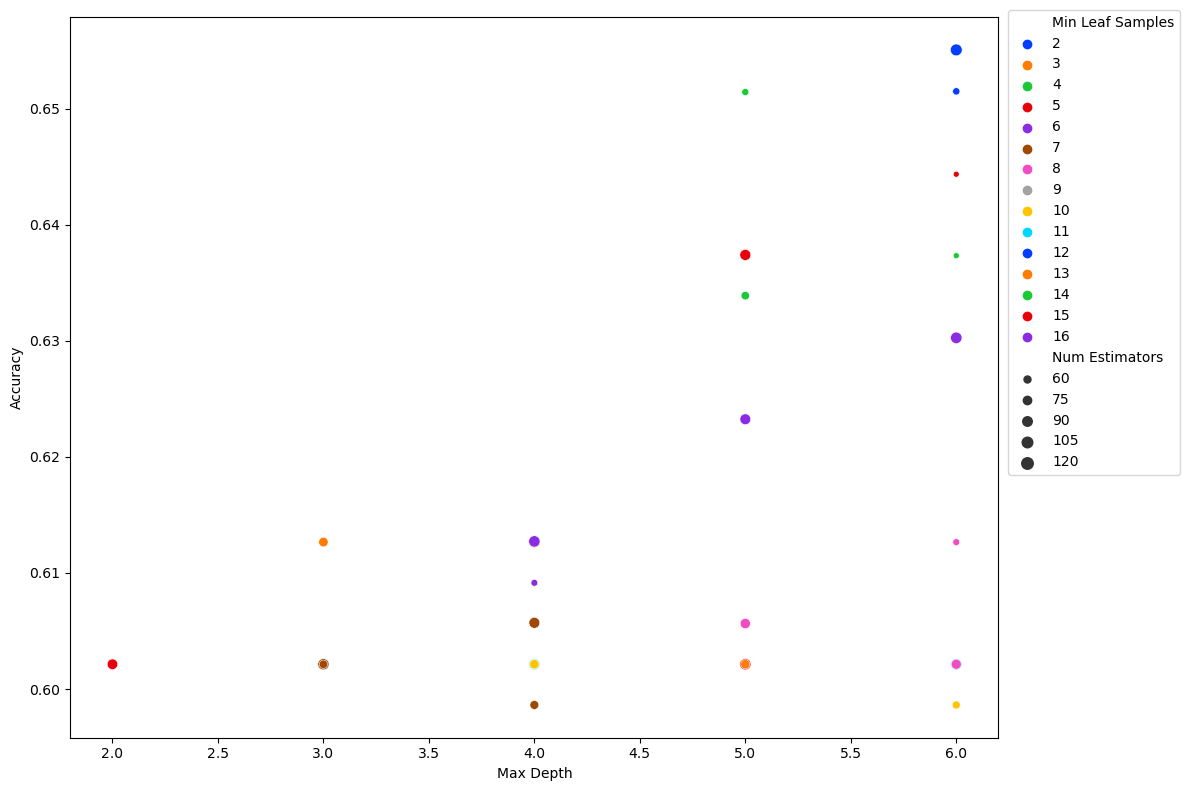

In [113]:
plt.figure(figsize = (12, 8))

rs_rf_fe_plot1 = plot_random_search(rs_results_rf_fe_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('random_search_results_rf_fe_sqrt.png')

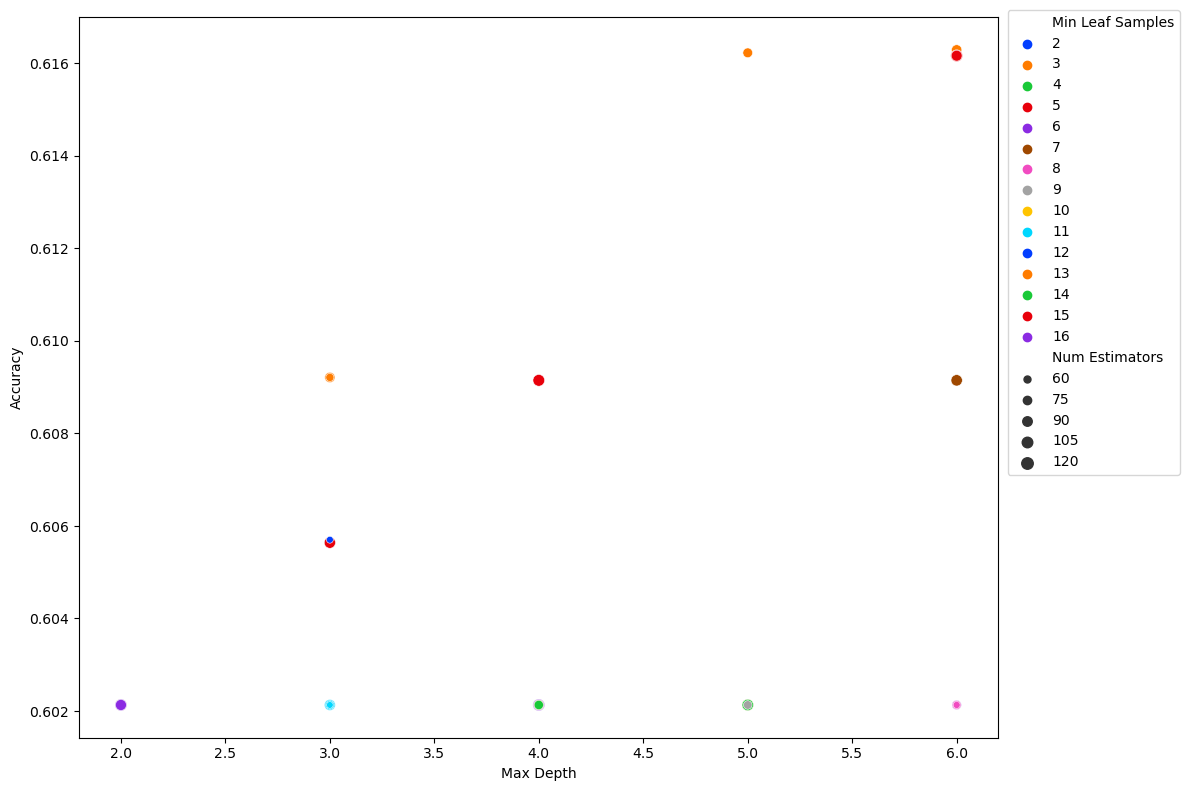

In [114]:
plt.figure(figsize = (12, 8))

rs_rf_fe_plot2 = plot_random_search(rs_results_rf_fe_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('random_search_results_rf_fe_log2.png')

We will now sort the randomized search values in order of descending classification accuracy to find the best results from the randomized search.

In [115]:
rs_results_rf_fe.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
45          6         sqrt                 2             124  0.655075
4           6         sqrt                 2              63  0.651504
81          5         sqrt                 4              61  0.651441
16          6         sqrt                 5              50  0.644361
33          5         sqrt                 5             111  0.637406
..        ...          ...               ...             ...       ...
31          4         sqrt                11             114  0.602130
30          5         log2                14              89  0.602130
55          2         sqrt                 9              93  0.602130
59          4         sqrt                 7              81  0.598622
79          6         sqrt                10              71  0.598622

[100 rows x 5 columns]

We will now use Bayes search to perform further hyperparameter tuning.  Notice that for Bayes search, we define a dictionary containing prior probability distributions over the hyperparameters.  Here, we put a discrete uniform prior distribution from $2$ to $6$ over the max depth, we put a discrete uniform prior distribution from $2$ to $16$ over the minimum number of samples in each leaf node, and we put a discrete uniform prior distribution from $50$ to $125$ over the number of estimators.  We also pick the maximum number of features from `sqrt`, and `log2`.  

Next, we use the `BayesSearchCV()` function to set up the Bayes search procedure.  For Bayes search, we perform $100$ iterations over the hyperparameter distributions using the random forest pipeline from before.  We also use the stratified 5-fold for cross-validation from above and use scoring as the accuracy metric.  We then fit the Bayes search procedure to the training data.

In [42]:
bayes_dist_rf_fe = {
    'model__max_depth': Integer(2, 6),
    'model__min_samples_leaf': Integer(2, 16),
    'model__n_estimators': Integer(50, 125),
    'model__max_features': ['sqrt', 'log2']
}

bayes_search_rf_fe = BayesSearchCV(random_forest_pipe_fe, search_spaces = bayes_dist_rf_fe, cv = skf_fe, 
                                   scoring = 'accuracy', n_iter = 100, random_state = 20221031)

bayes_search_rf_fe.fit(X_train_fe, y_train_fe)

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
              estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                        ('model',
                                         RandomForestClassifier(random_state=20221031))]),
              n_iter=100, random_state=20221031, scoring='accuracy',
              search_spaces={'model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'model__max_features': ['sqrt', 'log2'],
                             'model__min_samples_leaf': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=125, prior='uniform', transform='normalize')})

We will now extract the Bayes search results to a data frame and display the first $5$ rows.

In [43]:
bayes_results_rf_fe = grid_search_results(bayes_search_rf_fe)

bayes_results_rf_fe.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

bayes_results_rf_fe.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          4         sqrt                14             115  0.602130
1          4         sqrt                 3              69  0.616165
2          5         log2                15              99  0.602130
3          5         log2                 6              57  0.609148
4          4         log2                 7             111  0.612657

We will now split the data frame of Bayes search results into two smaller data frames based on the value of the `Max Features` hyperparameter to make it easier to visualize these results.

In [44]:
bayes_results_rf_fe_sqrt, bayes_results_rf_fe_log2 = split_results(bayes_results_rf_fe, 'Max Features')

We will now generate two scatterplots showing the Bayes search results and save the images.

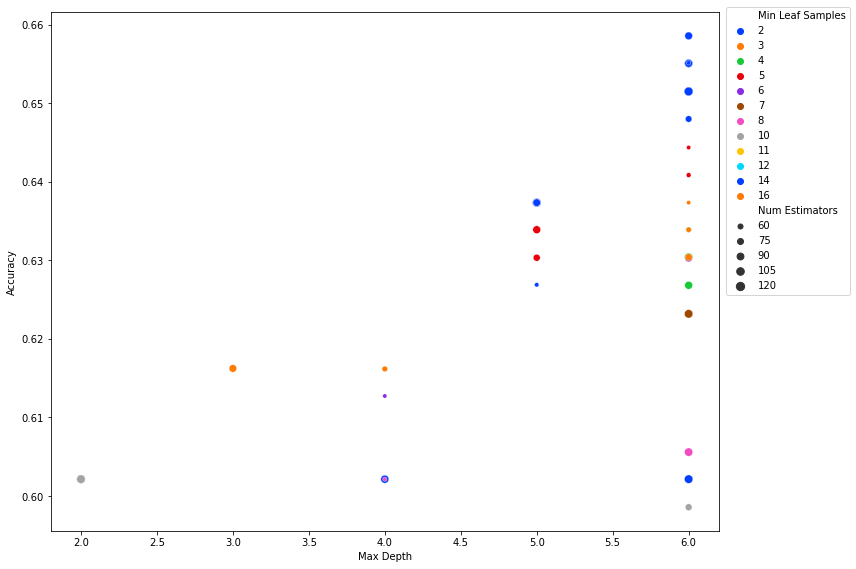

In [45]:
plt.figure(figsize = (12, 8))

bayes_rf_fe_plot1 = plot_random_search(bayes_results_rf_fe_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('bayes_search_results_rf_fe_sqrt.png')

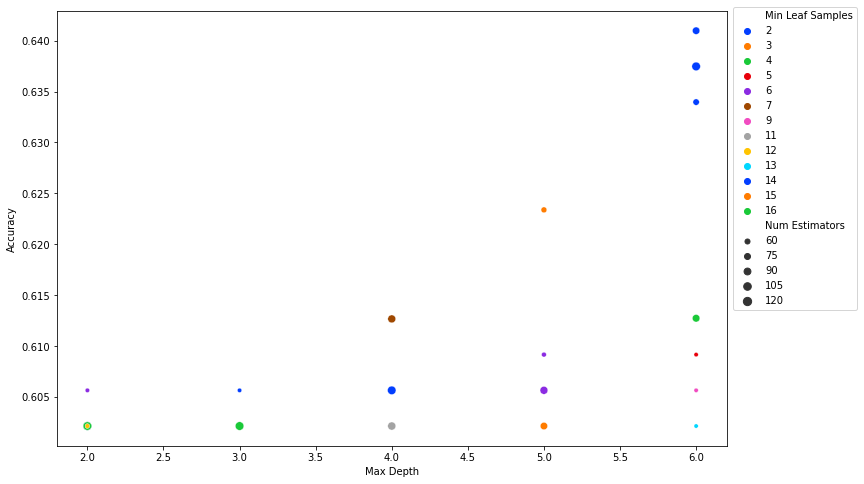

In [46]:
plt.figure(figsize = (12, 8))

bayes_rf_fe_plot2 = plot_random_search(bayes_results_rf_fe_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout

plt.savefig('bayes_search_results_rf_fe_log2.png')

We will now sort the Bayes search results in order of descending classification accuracy in order to see the best results from Bayes search.

In [47]:
bayes_results_rf_fe.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
24          6         sqrt                 2              52  0.658647
23          6         sqrt                 2              51  0.658647
83          6         sqrt                 2             104  0.658584
52          6         sqrt                 2             104  0.658584
91          6         sqrt                 2              50  0.655138
..        ...          ...               ...             ...       ...
67          2         sqrt                 2              86  0.602130
69          3         log2                16             125  0.602130
74          6         sqrt                14             125  0.602130
0           4         sqrt                14             115  0.602130
92          6         sqrt                10              89  0.598559

[100 rows x 5 columns]

Observe that the hyperparameters that yield the best cross-validation results are a maximum depth of $6$, a minimum of $2$ leaf samples, $52$ estimators, and using `sqrt` as the value for the maximum number of features.  

We will now set the hyperparameters of the random forest pipeline to these best values.

In [116]:
random_forest_pipe_fe.set_params(**{'model__max_depth': 6, 'model__min_samples_leaf': 2, 
                                    'model__n_estimators': 52, 'model__max_features': 'sqrt'})

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=2,
                                        n_estimators=52,
                                        random_state=20221031))])

We will now fit the random forest pipeline with the best hyperparameter values to the training data.

In [117]:
random_forest_pipe_fe.fit(X_train_fe, y_train_fe)

Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=2,
                                        n_estimators=52,
                                        random_state=20221031))])

We will now extract the feature importances from the random forest pipeline and create a data frame displaying the name and importance of each feature with a nonzero feature importance.

In [118]:
importances_rf_fe = random_forest_pipe_fe[1].feature_importances_

importance_df_rf_fe = importance_df(importances_rf_fe, X_train_fe.columns)

importance_df_rf_fe

Feature Name  Feature Importance
13                  Heart Rate (bpm)            0.177549
10     Vector Angles for T (degrees)            0.137870
4                QRS Duration (msec)            0.100493
7                  T Interval (msec)            0.095324
12  Vector Angles for QRST (degrees)            0.087585
6                Q-T Interval (msec)            0.072968
9    Vector Angles for QRS (degrees)            0.067972
3                        Weight (kg)            0.055563
0                                Age            0.050013
2                        Height (cm)            0.040896
8                  P Interval (msec)            0.038102
5                P-R Interval (msec)            0.034639
11     Vector Angles for P (degrees)            0.030216
1                                Sex            0.010810

We will now produce a barplot showing the nonzero feature importances from the random forest pipeline and save the image.

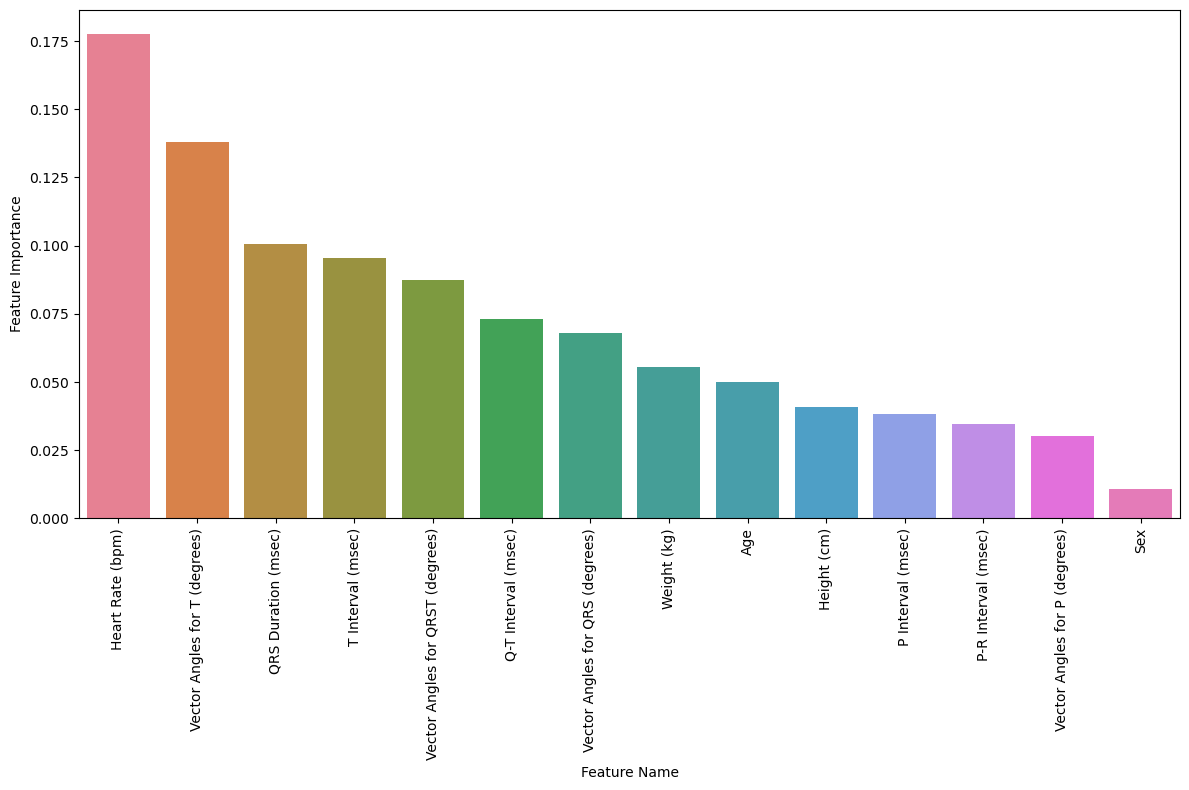

In [187]:
plt.figure(figsize = (12, 8))

rf_fe_imp_plot = plot_feat_importances(importance_df_rf_fe)

plt.tight_layout()

plt.savefig('rf_fe_feat_imp_plot.png')

We will now plot the results of the `learning_curve()` function in order to see whether the random forest is underfitting or overfitting the data.

In [120]:
_, train_scores_rf_fe, test_scores_rf_fe = learning_curve(random_forest_pipe_fe, X_train_fe, y_train_fe,
                                                          scoring = 'accuracy', cv = skf_fe, 
                                                          train_sizes = train_fractions, return_times = False)

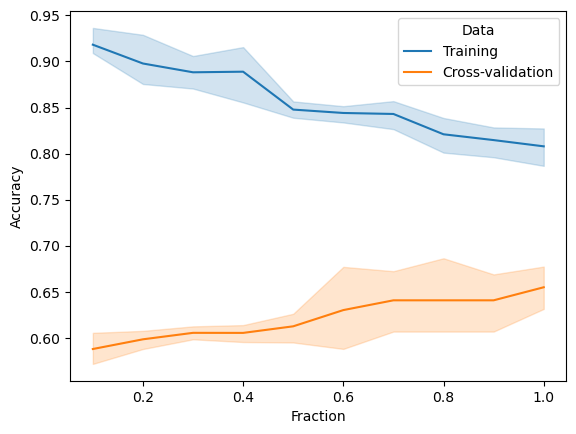

In [121]:
plot_learning_curve(train_fractions, train_scores_rf_fe, test_scores_rf_fe)

plt.savefig('learning_curve_rf_fe.png')

We will now calculate and display the training accuracy of the random forest.

In [122]:
train_acc_rf_fe = random_forest_pipe_fe.score(X_train_fe, y_train_fe)

train_acc_rf_fe

0.8028169014084507

Observe that the training accuracy of the random forest is $0.8028$, which means that the random forest correctly predicted the arrhythmia diagnosis for $80.28\%$ of the training instances.  

We will now make a heatmap showing the confusion matrix for the training predictions of the random forest model.

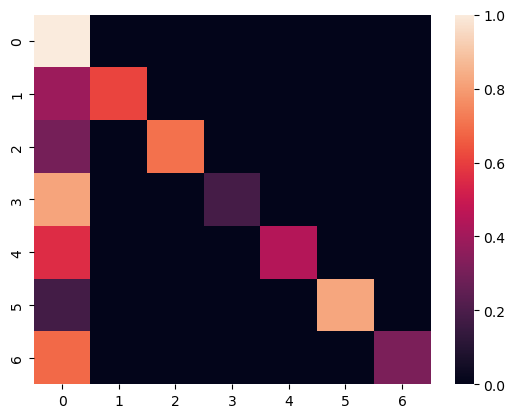

In [123]:
train_preds_rf_fe = random_forest_pipe_fe.predict(X_train_fe)

confmat_train_rf_fe = confusion_matrix(y_train_fe, train_preds_rf_fe, normalize = 'true')

sb.heatmap(confmat_train_rf_fe)

plt.savefig('confmat_train_rf_fe.png')

We will now calculate and display the test accuracy of the random forest model.  

In [124]:
test_acc_rf_fe = random_forest_pipe_fe.score(X_test_fe, y_test_fe)

test_acc_rf_fe

0.6747967479674797

Notice that the test accuracy of the random forest model is $0.6748$, which means that the random forest correctly predicted the arrhythmia diagnosis of $67.48\%$ of the instances in the test set.

We will now make a heatmap showing the confusion matrix for the test predictions of the random forest model.

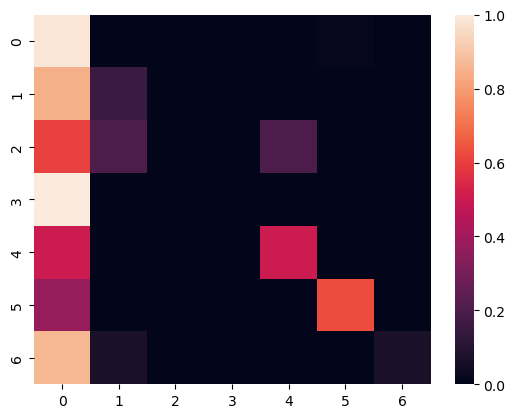

In [125]:
test_preds_rf_fe = random_forest_pipe_fe.predict(X_test_fe)

confmat_test_rf_fe = confusion_matrix(y_test_fe, test_preds_rf_fe, normalize = 'true')

sb.heatmap(confmat_test_rf_fe)

plt.savefig('confmat_test_rf_fe.png')

# Feature Engineering K Means Clustering

We will now perform K-means clustering and evaluate its performance on both the training and test sets.  In order to do so, we start by using the `KMeans()` function to define a K-means clusterer from scikit-learn.  We set the number of clusters for K-means clustering to $7$ since there are $7$ arrhythmia diagnoses in the dataset and we set its random state to `20221031`.  Next, we incorporate the K-means clusterer into a pipeline that first uses K-nearest neighbors to impute the missing values in the dataset, then uses the standard scaler to standardize the values in the dataset, and finally uses the K-means clusterer to perform K-means clustering.  Notice that we standardize the values because this makes K-means clustering more effective.

In [126]:
kmeans_fe = KMeans(n_clusters = 7, random_state = 20221031)

kmeans_pipe_fe = Pipeline(steps = [('imputer', imputer_fe), ('scaler', scaler_fe), ('model', kmeans_fe)])

We will now fit the K-means clustering pipeline to the training data.

In [127]:
kmeans_pipe_fe.fit(X_train_fe, y_train_fe)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=7, random_state=20221031))])

In order to find the training accuracy of the K-means clustering pipeline, we will first use the `predict()` method to predict the arrhythmia diagnoses of all the instances in the training set.  Then, we will find the number of times that the predicted arrhythmia diagnosis matched the actual arrhythmia diagnosis for the instances in the training set and divide it by the number of instances in the training set and print the resulting training accuracy.

In [128]:
train_preds_kmeans_fe = kmeans_pipe_fe.predict(X_train_fe) + 1

train_acc_kmeans_fe = (len(np.where(train_preds_kmeans_fe == y_train_fe)[0]))/(len(y_train_fe))

train_acc_kmeans_fe

0.16901408450704225

From the output of the code shown above, we see that the training accuracy for the K-means clustering pipeline is $0.1690$, which means that the K-means clustering pipeline correctly predicted the arrhythmia diagnosis for $16.90\%$ of the instances in the training set.

We will now use the `confusion_matrix()` function to make a confusion matrix from the predicted arrhythmia diagnoses and actual arrhythmia diagnoses for the taining instances, normalized based on the actual arrythmia diagnoses.  Next, we use seaborn to create a heatmap visualization of the confusion matrix and save the visualization to a png file.

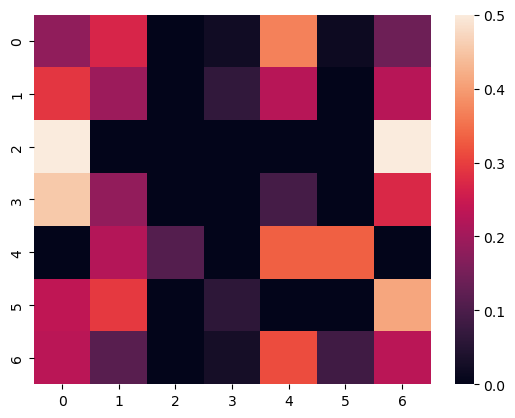

In [129]:
confmat_train_kmeans_fe = confusion_matrix(y_train_fe, train_preds_kmeans_fe, normalize = 'true')

sb.heatmap(confmat_train_kmeans_fe)

plt.savefig('confmat_train_kmeans_fe.png')

Observe in the confusion matrix shown above that the K-means clustering pipeline seems to just randomly predict arrythmia diagnoses and does not appear to have learned any of the signal from the data.

We will now use the `predict()` method on the K-means clustering pipeline to generate predicted arrythmia diagnoses for all the instances in the test set.  As before, we then find the number of times that the predicted arrythmia diagnosis matched the actual arrythmia diagnosis from the test set and divide by the number of instances in the test set to find the test accuracy, which we then display.

In [130]:
test_preds_kmeans_fe = kmeans_pipe_fe.predict(X_test_fe) + 1

test_acc_kmeans_fe = (len(np.where(test_preds_kmeans_fe == y_test_fe)[0]))/(len(y_test_fe))

test_acc_kmeans_fe

0.22764227642276422

Based on the output of the code shown above, we see that the test acuracy of the K-means clustering pipeline is $0.2276$, which means that the K-means clustering pipeline predicted the correct arrhythmia diagnosis for $22.76\%$ of the instances in the test set.

Now, we will create a confusion matrix for the instances in the test set that is normalized based on the actual arrythmia diagnosis.  We then use seaborn to create a heatmap visualization of the confusion matrix and save it to a png file.

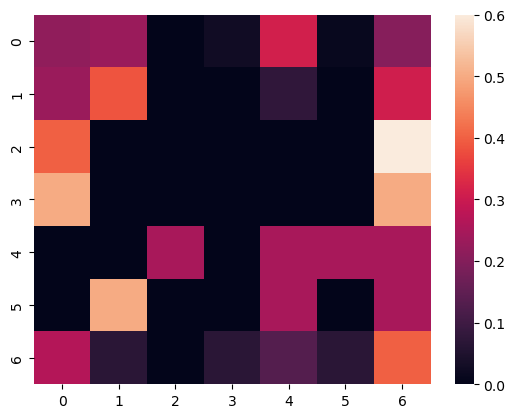

In [131]:
confmat_test_kmeans_fe = confusion_matrix(y_test_fe, test_preds_kmeans_fe, normalize = 'true')

sb.heatmap(confmat_test_kmeans_fe)

plt.savefig('confmat_test_kmeans_fe.png')

# Feature Selection with PCA

We will now define instances of data processing methods that will be used in the following sections.  First, we will define the principal component analysis (PCA) that we will use in this section using the `PCA()` function from scikit-learn. In order to more easily compare the results from feature engineering and feature selection with PCA, we will select the top 36 components using PCA.  This PCA procedure is stored in the `pca` variable.  

Recall that since we have missing data, we will need to impute the missing data.  This missing data imputation will be performed using K-nearest neighbors imputation with the `KNNImputer()` from scikit-learn.  The `KNNImputer()` that we will use is stored in the `imputer_pca` variable.  

In order to use PCA, we will need to first standardize our feature values, which will be done using the `StandardScaler()` from scikit-learn.  This instance of `StandardScaler()` is stored in the `scaler_pca` variable. 

We will also use the `StratifiedKFold()` function to set-up 5-fold cross-validation for hyperparameter tuning later in this section.  For 5-fold cross_validation, we set `n_splits = 5`, `shuffle = True`, and `random_state = 20221031` to shuffle the data before splitting it into $5$ folds for 5-fold cross-validation.  Since we are using `StratifiedKFold()`, the $5$ folds will be stratified by arrhythmia class so that each fold has the same proportion of arrhythmia class labels as the original training data set. We store the resulting object in the `skf_pca` variable.

In [132]:
pca = PCA(n_components = 36, random_state = 20221031)

imputer_pca = KNNImputer()

scaler_pca = StandardScaler()

skf_pca = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 20221031)

# Feature Selection Decision Tree

In this section, we will create a pipeline to impute the missing data and fit a decision tree classifier, perform extensive hyperparameter tuning using both grid search and randomized search, update the hyperparameter values of the decision tree classifier to match those with the highest accuracy across the hyperparameter tuning searches, train the decision tree classifier to the entire training dataset, examine its feature importances, and examine its performance on both the training and test sets.

First, we will create a decision tree classifier that uses `gini` as its criterion using the `DecisionTreeClassifier` from scikit-learn.  We then incorporate this decision tree classifier into a pipeline that first uses the `KNNImputer` defined earlier to impute the missing data using K-nearest neighbors imputation and then uses the decision tree classsifier.

In [133]:
decision_tree_pca = DecisionTreeClassifier(criterion = 'gini', random_state = 20221031)

decision_tree_pipe_pca = Pipeline(steps = [('imputer', imputer_pca), ('scaler', scaler_pca), 
                                           ('pca', pca), ('model', decision_tree_pca)])

We will now define a parameter grid over which to perform grid search for hyperparameter tuning.  In this parameter grid, we consider a maximum tree depth between $2$ and $6$, minimum numbers of samples in each leaf node of $2$, $4$, $8$, or $16$, the `best` and `random` splitters, and a maximum number of features to use when fitting the decision tree of `None`, `sqrt`, or `log2`.  

We then use `GridSearchCV` to perform hyperparameter tuning on the pipeline that includes the decision tree classifier with the parameter grid that we specify below, using the stratified 5-fold for cross-validation that we set up previously, and scoring the cross-validation results on classification accuracy.  We then fit the grid search object to the training data.

In [134]:
param_grid_dt_pca = {
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_leaf': [2, 4, 8, 16],
    'model__splitter': ['best', 'random'],
    'model__max_features': [None, 'sqrt', 'log2']
}

grid_search_dt_pca = GridSearchCV(decision_tree_pipe_pca, param_grid = param_grid_dt_pca, cv = skf_pca,
                                  scoring = 'accuracy')

grid_search_dt_pca.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=36,
                                            random_state=20221031)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=20221031))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6],
                         'model__max_features': [None, 'sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 8, 16],
                         'model__splitter': ['best', 'random']},
             scoring='accuracy')

After performing grid search to perform hyperparameter tuning on the decision tree classifier pipeline, we will first use the `grid_search_results()` function that we wrote earlier to extract the results from the grid search to a data frame, then rename the columns of the grid search results data frame, and display the first $5$ entries of the grid search results data frame.

In [135]:
gs_results_dt_pca = grid_search_results(grid_search_dt_pca)

gs_results_dt_pca.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

gs_results_dt_pca.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          2         None                 2     best  0.658584
1          2         None                 2   random  0.605639
2          2         None                 4     best  0.658584
3          2         None                 4   random  0.595113
4          2         None                 8     best  0.662093

We will now use the `fix_none_vals()` function that we wrote earlier to convert `None` values to `'None'` values in the data frame of grid search results.  This is done so that we can better visualize the grid search results using seaborn.

In [136]:
gs_results_dt_pca = fix_none_vals(gs_results_dt_pca)

Since we used too many hyperparameters during grid search to create a plot of the results in seaborn, we will now use the `split_results()` function to split the data frame of grid search results into two smaller dataframes of grid search results which were split on the value of the `Splitter` hyperparameter in grid search.  The first data frame contains the grid search results whose `Splitter` value is `best` and the second data frame contains the grid search results whose `Splitter` values is `random`.

In [137]:
gs_dt_pca_best, gs_dt_pca_random = split_results(gs_results_dt_pca, 'Splitter')

We will now plot the results of the grid search whose `Splitter` value is `best` using the `plot_grid_search()` function that we wrote previously.  In the resulting line plot, we put `Max Depth` on the x-axis, determine the color of each line using the value of `Min Leaf Samples`, and determine the line style using the value of `Max Features`.  After we display the plot, we save it to a png file using the `plt.savefig()` function.

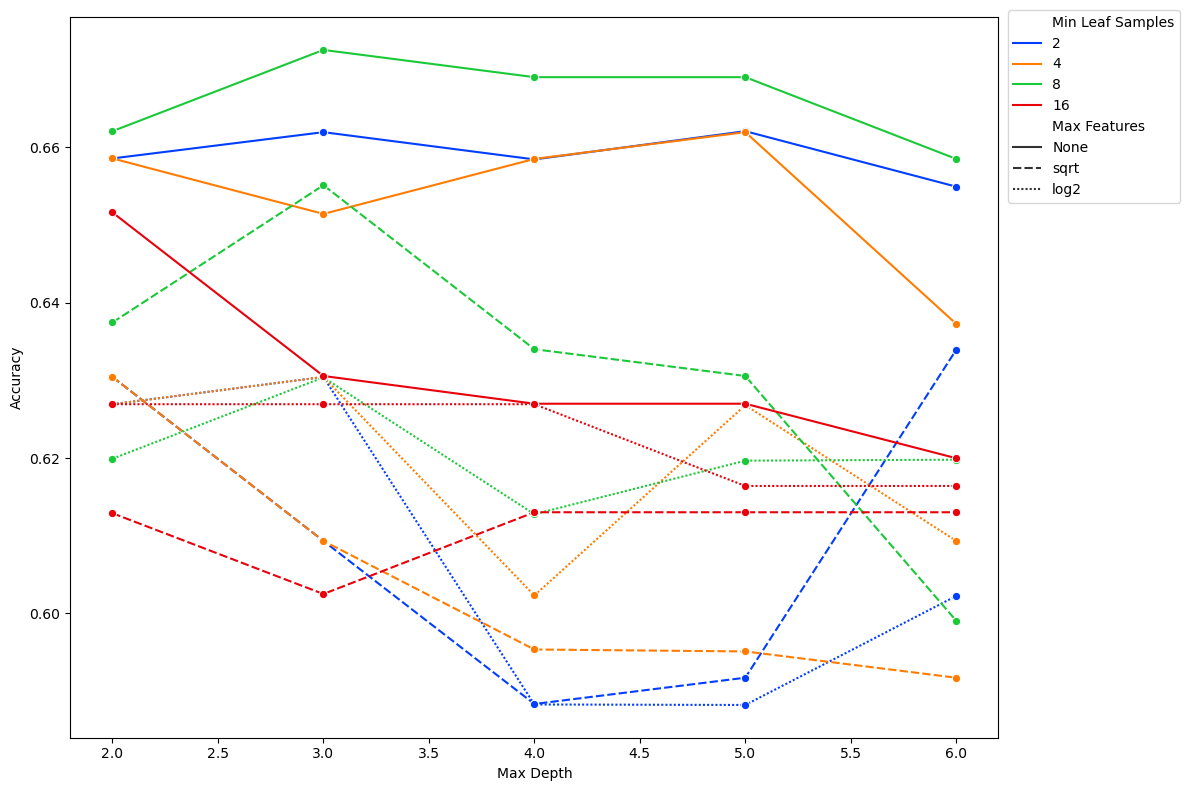

In [138]:
plt.figure(figsize = (12, 8))

gs_dt_pca_plot1 = plot_grid_search(gs_dt_pca_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('grid_search_results_dt_pca_best.png')

We will now plot the results of the grid search whose `Splitter` value is `random` using the `plot_grid_search()` function that we wrote previously.  In the resulting line plot, we put `Max Depth` on the x-axis, determine the color of each line using the value of `Min Leaf Samples`, and determine the line style using the value of `Max Features`.  After we display the plot, we save it to a png file using the `plt.savefig()` function.

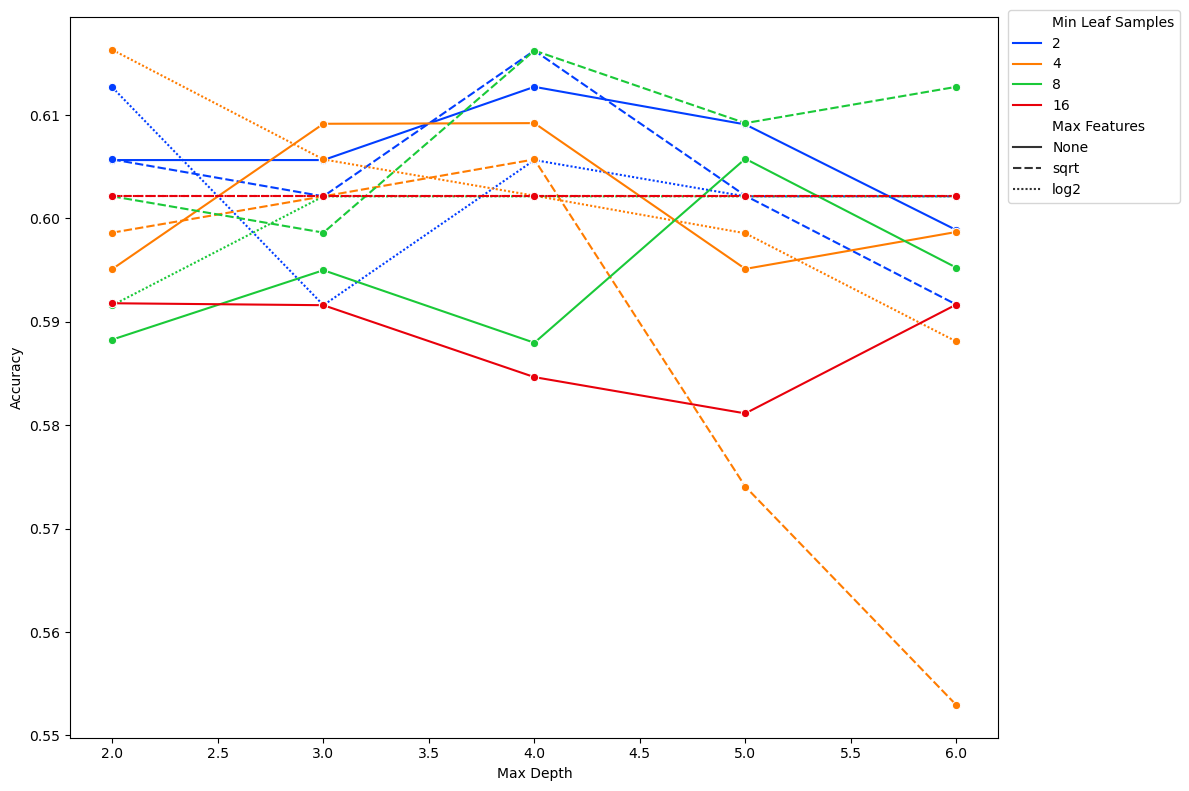

In [139]:
plt.figure(figsize = (12, 8))

gs_dt_pca_plot2 = plot_grid_search(gs_dt_pca_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('grid_search_results_dt_pca_random.png')

In order to determine the optimal hyperparameter values from grid search, we will sort the grid search results data frame by descending classification accuracy and display the resulting data frame.

In [140]:
gs_results_dt_pca.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
28           3         None                 8     best  0.672556
76           5         None                 8     best  0.669048
52           4         None                 8     best  0.669048
4            2         None                 8     best  0.662093
72           5         None                 2     best  0.662093
..         ...          ...               ...      ...       ...
53           4         None                 8   random  0.587970
55           4         None                16   random  0.584649
79           5         None                16   random  0.581140
83           5         sqrt                 4   random  0.574060
107          6         sqrt                 4   random  0.552945

[120 rows x 5 columns]

We will now use randomized search to perform further hyperparameter tuning on the decision tree classifier pipeline.  In order to do so, we first create a dictionary of probability distributions over the hyperparameters.  Notice that we are putting a discrete uniform distribution over the maximum depth of the tree and the minimum number of samples in each leaf node.  The discrete uniform distribution over the maximum depth of the tree considers tree depths between $2$ and $6$, while the discrete uniform distribution over the minimum number of samples in each leaf node considers values between $2$ and $16$.  For the categorical hyperpameters maximum number of features and splitter, we provide a list of possible values.  The possible values for the maximum number of features are `None`, `sqrt`, and `log2` while the possible values for the splitter are `best` and `random`.  

We then use the `RandomizedSearchCV()` function to set up the randomized search procedure by passing it the decision tree classifier pipeline, setting the parameter distributions to the dictionary of values defined below, using the stratified 5-folds for cross-validation, setting the number of iterations of random search to $100$, and using the classification accuracy as the scoring metric.  We then fit the randomized search to the training data.

In [141]:
param_dist_dt_pca = {
    'model__max_depth': stats.randint(2, 6),
    'model__min_samples_leaf': stats.randint(2, 16),
    'model__splitter': ['best', 'random'],
    'model__max_features': [None, 'sqrt', 'log2']
}

random_search_dt_pca = RandomizedSearchCV(decision_tree_pipe_pca, param_distributions = param_dist_dt_pca,
                                          cv = skf_pca, n_iter = 100, scoring = 'accuracy', 
                                          random_state = 20221031)

random_search_dt_pca.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('pca',
                                              PCA(n_components=36,
                                                  random_state=20221031)),
                                             ('model',
                                              DecisionTreeClassifier(random_state=20221031))]),
                   n_iter=100,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0311087b20>,
                                        'model__max_features': [None, 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f03110881c0>,
                                        'model__splitter': ['best', 'random']},
                   random_state=20221031, scoring='accuracy')

We will now use the `grid_search_results()` function to extract the randomized search results into a data frame, rename the columns of the data frame, and display the first $5$ rows of the randomizes search results data frame.

In [142]:
rs_results_dt_pca = grid_search_results(random_search_dt_pca)

rs_results_dt_pca.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

rs_results_dt_pca.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          4         log2                14   random  0.602130
1          2         None                 4     best  0.658584
2          2         sqrt                 4     best  0.630451
3          3         None                13     best  0.658584
4          2         None                 6     best  0.658584

We will now call `fix_none_vals()` to convert values of `None` to values of `'None'` in the data frame of randomized search results to make it easier to visualize these results.

In [143]:
rs_results_dt_pca = fix_none_vals(rs_results_dt_pca)

As before, we have too many hyperparameters in the randomized search to simply create a plot of all the randomized search results at once using seaborn so we will now use `split_results()` to create two smaller data frames of randomized search results.  The first data frame contains the randomized search results whose value of `Splitter` is `best` and the second data frame contains the randomized search results whose value of `Splitter` is `random`.

In [144]:
rs_results_dt_pca_best, rs_results_dt_pca_random = split_results(rs_results_dt_pca, 'Splitter')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Splitter` value is `best`.  In this scatterplot, the values of `Max Depth` are on the x-axis, the hue of each point is determined by the value of `Min Leaf Samples`, and the size of each point is determined by the value of `Max Features`.  The cross-validation accuracy is shown on the y-axis and after displaying the scatterplot, we save it to a png file using the `plt.savefig()` function.

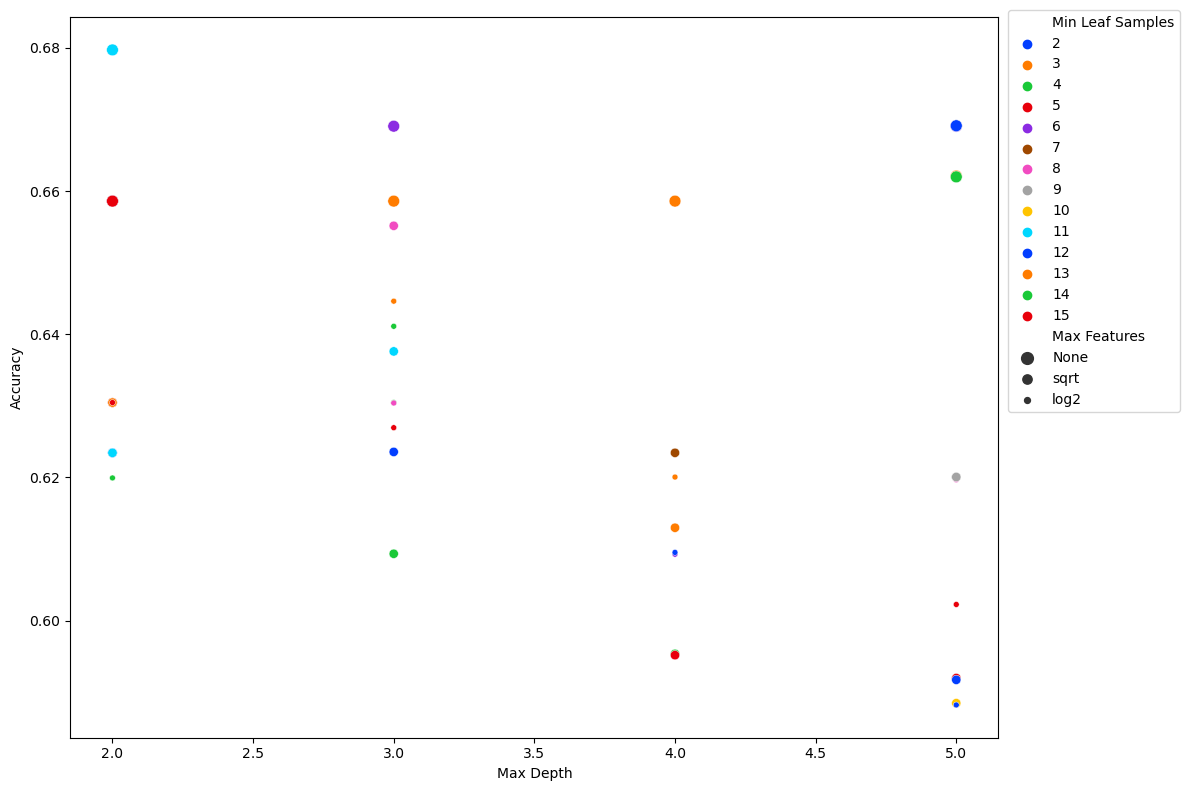

In [145]:
plt.figure(figsize = (12, 8))

rs_dt_pca_plot1 = plot_random_search(rs_results_dt_pca_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('random_search_results_dt_pca_best.png')

We will now use the `plot_random_search()` function to create a scatterplot of the randomized search results whose `Splitter` value is `random`.  In this scatterplot, the values of `Max Depth` are on the x-axis, the hue of each point is determined by the value of `Min Leaf Samples`, and the size of each point is determined by the value of `Max Features`.  The cross-validation accuracy is shown on the y-axis and after displaying the scatterplot, we save it to a png file using the `plt.savefig()` function.

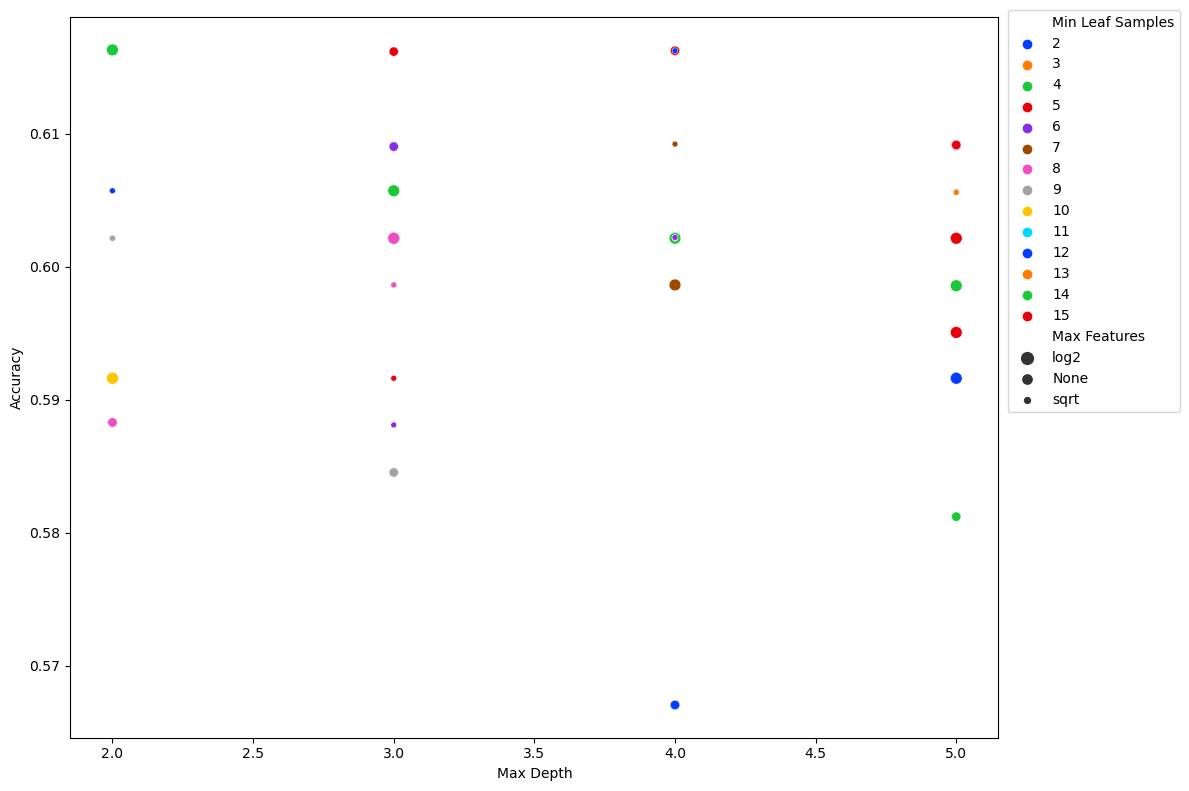

In [146]:
plt.figure(figsize = (12, 8))

rs_dt_pca_plot2 = plot_random_search(rs_results_dt_pca_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('random_search_results_dt_pca_random.png')

We will now find the best combination of hyperparameter values from the randomized search procedure by sorting the values in the data frame of randomized search results in descending order according to their classification accuracy.

In [147]:
rs_results_dt_pca.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
14          2         None                11     best  0.679699
66          5         None                12     best  0.669110
35          5         None                 9     best  0.669110
84          3         None                 6     best  0.669048
41          5         None                 6     best  0.669048
..        ...          ...               ...      ...       ...
15          3         None                 9   random  0.584524
48          5         None                14   random  0.581203
16          4         None                12   random  0.567043
52          4         None                12   random  0.567043
31          4         None                12   random  0.567043

[100 rows x 5 columns]

We will now use Bayes search to perform further hyperparameter tuning.  Notice that for Bayes search, we define a dictionary containing prior probability distributions over the hyperparameters.  Here, we put a discrete uniform prior distribution from $2$ to $6$ over the max depth and we put a discrete uniform prior distribution from $2$ to $16$ over the minimum number of samples in each leaf node.  We pick the maximum number of features from `None`, `sqrt`, and `log2` and we pick the splitter from `best` and `random`.  

Next, we use the `BayesSearchCV()` function to set up the Bayes search procedure.  For Bayes search, we perform $100$ iterations over the hyperparameter distributions using the decision tree pipeline from before.  We also use the stratified 5-fold for cross-validation from above and use scoring as the accuracy metric.  We then fit the Bayes search procedure to the training data.

In [50]:
bayes_dist_dt_pca = {
    'model__max_depth': Integer(2, 6),
    'model__min_samples_leaf': Integer(2, 16),
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__splitter': ['best', 'random']
}

bayes_search_dt_pca = BayesSearchCV(decision_tree_pipe_pca, search_spaces = bayes_dist_dt_pca, cv = skf_pca,
                                    n_iter = 100, scoring = 'accuracy', random_state = 20221031)

bayes_search_dt_pca.fit(X_train, y_train)

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
              estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                        ('scaler', StandardScaler()),
                                        ('pca',
                                         PCA(n_components=36,
                                             random_state=20221031)),
                                        ('model',
                                         DecisionTreeClassifier(random_state=20221031))]),
              n_iter=100, random_state=20221031, scoring='accuracy',
              search_spaces={'model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'model__max_features': [None, 'sqrt', 'log2'],
                             'model__min_samples_leaf': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'model__splitter': ['best', 'random']})

We will now create a data frame containing the Bayes search results and display the first $5$ result entries.

In [51]:
bayes_results_dt_pca = grid_search_results(bayes_search_dt_pca)

bayes_results_dt_pca.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Splitter', 'Accuracy']

bayes_results_dt_pca.head()

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
0          4         log2                14   random  0.602130
1          4         sqrt                 3     best  0.602381
2          5         None                15   random  0.563409
3          5         None                 6     best  0.669048
4          4         sqrt                 7   random  0.609211

We will now convert values of `None` to `'None'` in the data frame of Bayes results so that we can better visualize these results.

In [52]:
bayes_results_dt_pca = fix_none_vals(bayes_results_dt_pca)

We will now split the data frame of Bayes results into two smaller data frames according to the value of the `Splitter` hyperparameter so that we can more easily visualize these results.

In [53]:
bayes_results_dt_pca_best, bayes_results_dt_pca_random = split_results(bayes_results_dt_pca, 'Splitter')

We will now create two scatterplots showing the Bayes search results and save the images.

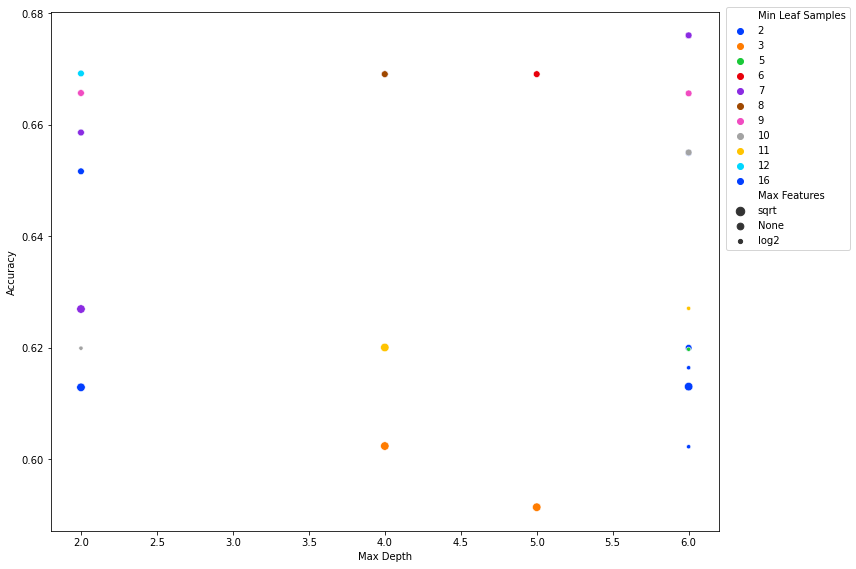

In [54]:
plt.figure(figsize = (12, 8))

bayes_dt_pca_plot1 = plot_random_search(bayes_results_dt_pca_best, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('bayes_search_results_dt_pca_best.png')

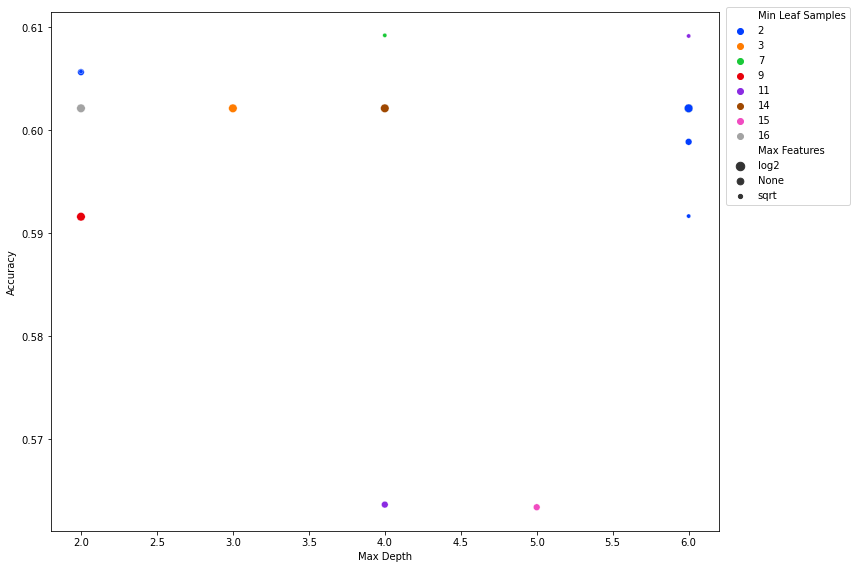

In [55]:
plt.figure(figsize = (12, 8))

bayes_dt_pca_plot2 = plot_random_search(bayes_results_dt_pca_random, 'Max Depth', 'Min Leaf Samples', 'Max Features')

plt.tight_layout()

plt.savefig('bayes_search_results_dt_pca_random.png')

We will now sort the Bayes search results in order of descending accuracy in order to see the best results from Bayes search more easily.

In [56]:
bayes_results_dt_pca.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples Splitter  Accuracy
50          6         None                 7     best  0.676003
64          6         None                 7     best  0.676003
74          6         None                 7     best  0.676003
73          6         None                 7     best  0.676003
72          6         None                 7     best  0.676003
..        ...          ...               ...      ...       ...
29          6         sqrt                 2   random  0.591667
43          2         log2                 9   random  0.591604
9           5         sqrt                 3     best  0.591416
8           4         None                11   random  0.563659
2           5         None                15   random  0.563409

[100 rows x 5 columns]

Based on the results from both the grid search and randomized search procedures, we see that the best combination of hyperparameter values is a maximum depth of $2$, no maximum number of features, a minimum of $11$ samples in each leaf node, and using the `best` splitter.  We will now use the `set_params()` function to set the hyperparameters of the decision tree classifier in the decision tree classifier pipeline to the aforementioned values.

In [148]:
decision_tree_pipe_pca.set_params(**{'model__max_depth': 2, 'model__min_samples_leaf': 11, 
                                     'model__max_features': None, 'model__splitter': 'best'})

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=36, random_state=20221031)),
                ('model',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=11,
                                        random_state=20221031))])

We will now fit the decision tree classifier pipeline with the optimal hyperparamter values found by performing both grid search and randomized search to the entire training dataset.

In [149]:
decision_tree_pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=36, random_state=20221031)),
                ('model',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=11,
                                        random_state=20221031))])

Here, we will plot the best decision tree using the `plot_tree()` function, fill in the boxes in the plot, and save the plot to a pdf using the `plt.savefig()` function.

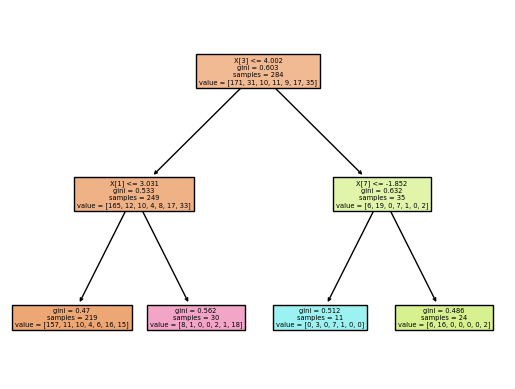

In [150]:
plot_tree(decision_tree_pipe_pca[3], filled = True)

plt.savefig('arrhythmia_decision_tree_pca.pdf')

In order to determing whether the best decision tree classifier suffers from overfitting or underfitting, we will use the `learning_curve()` function that we pass the decision tree pipeline, the training data, the stratified 5-fold data, training sizes between $0.1$ and $1.0$ counting by $0.1$, and scoring on classification accuracy.

In [151]:
_, train_scores_dt_pca, test_scores_dt_pca = learning_curve(decision_tree_pipe_pca, X_train, y_train,
                                                            scoring = 'accuracy', cv = skf_pca, 
                                                            train_sizes = train_fractions, return_times = False)

We will now use the `plot_learning_curve()` function to plot the results from the `learning_curve()` function and we save the plot to a png file using the `plt.savefig()` function.

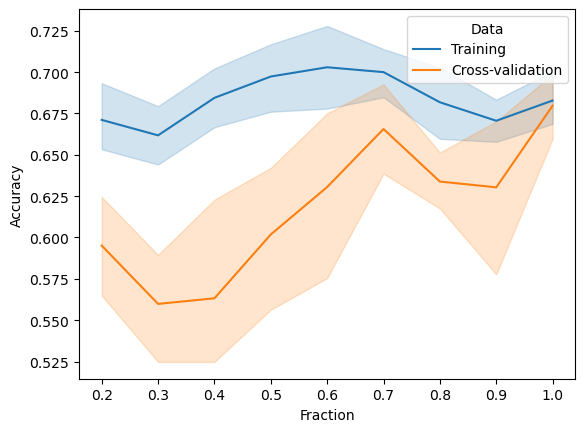

In [152]:
plot_learning_curve(train_fractions, train_scores_dt_pca, test_scores_dt_pca)

plt.savefig('learning_curve_dt_pca.png')

We will now use the `score` method of the decision tree pipeline to find its training accuracy, which we then display.

In [153]:
train_acc_dt_pca = decision_tree_pipe_pca.score(X_train, y_train)

train_acc_dt_pca

0.6971830985915493

Notice that the best decision tree classifier has a training accuracy of $0.7535$ which means that it correctly classifies $75.35\%$ of the instances in the training dataset.  

We will now create a confusion matrix for the training predictions of the best decision tree classifier by first generating predicted arrhythmia diagnoses for the instances in the training dataset, then creating a confusion matrix from those predictions and the actual diagnoses.  In the confusion matrix, we normalize by the true arrhythmia diagnosis so that more frequently occurring classes do not disproportionately impact the confusion matrix visualization.  We then produce a heatmap using seaborn of the confusion matrix so that we can more easily visualize the confusion matrix and we save it to a png file.

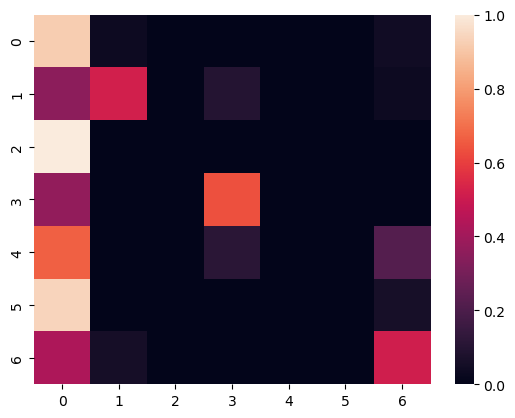

In [154]:
train_preds_dt_pca = decision_tree_pipe_pca.predict(X_train)

confmat_train_dt_pca = confusion_matrix(y_train, train_preds_dt_pca, normalize = 'true')

sb.heatmap(confmat_train_dt_pca)

plt.savefig('confmat_train_dt_pca.png')

Observe that the best decision tree classifier correctly predicts the arrhythmia diagnosis of the majority of the instances whose actual arrhythmia diagnosis is normal, coronary artery disease, old anterior myocardial infarction, and old inferior myocardial infarction .  However, we see that the decision tree classifier will overpredict a normal diagnosis for all of the arrhythmia diagnoses that are not normal.  Additionally, the decision tree classifier fails to correctly predict the arrythmia diagnosis of nearly any of the instances whose actual arrhythmia diagnosis is sinus tachycardy or sinus bradycardy and correctly predicts the arrhythmia diagnosis of under half of the instances whose actual arrhythmia diagnosis is right bundle branch block.

We will now use the `score` method of the decision tree pipeline to calculate the test accuracy of the best decision tree classifier and we will then display the test accuracy.

In [155]:
test_acc_dt_pca = decision_tree_pipe_pca.score(X_test, y_test)

test_acc_dt_pca

0.6341463414634146

From the output of the code shown above, we see that the test accuracy of the best decision tree is $0.6504$ which means that the best decision tree correctly classifies $65.04\%$ of the instances in the test set.

We will now use the decision tree pipeline to generate predicted arrhythmia diagnoses for each instance in the test set.  Then, we will create a confusion matrix using the predicted and actual arrhythmia diagnoses from the test set that is normalized according to the true diagnosis.  We will then use seaborn to create a heatmap from the confusion matrix in order to better visualize the classification mistakes that the best decision tree pipeline is making on the test set and we will save the plot to a png file.

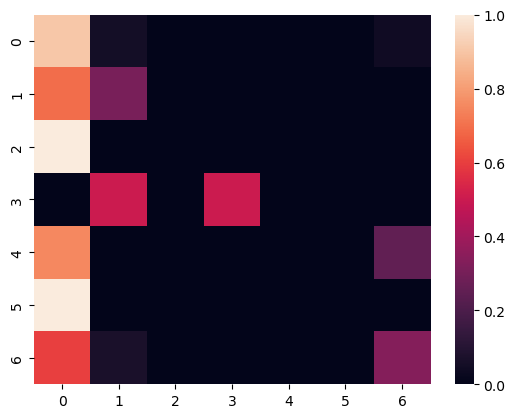

In [156]:
test_preds_dt_pca = decision_tree_pipe_pca.predict(X_test)

confmat_test_dt_pca = confusion_matrix(y_test, test_preds_dt_pca, normalize = 'true')

sb.heatmap(confmat_test_dt_pca)

plt.savefig('confmat_test_dt_pca.png')

Notice in the heatmap confusion matrix visualization shown above that the best decision tree classifier correctly predicts the diagnosis for the majority of instances whose true arrhythmia diagnosis is normal or old anterior myocardial infraction.  However, the best decision tree classifier overpredicts a normal diagnosis when the true diagnosis is coronary artery disease, old inferior myocardial infarction, or sinus tachycardy.  When the actual arrhythmia diagnosis is sinus bradycardy or right bundle branch block, the best decision tree classifier almost always predicts a normal diagnosis.  Additionally, the best decision tree classifier overpredicts a diagnosis of coronary artery disease when the actual diagnosis is an old interior myocardial infarction.  Further observe that the best decision tree classifier overpredicts a diagnosis of old anterior myocardial infarction when the true arrhythmia diagnosis is sinus tachycardy.

# Random Forest with PCA

In this section, we will fit a random forest classifier to the data, perform hyperparameter tuning using both grid search, randomized search, and Bayes search, update the hyperparameters of the random forest classifier to the best values from hyperparameter tuning, examine the important features from the random forest classifier, and evaluate the training and test performance of the best random forest classifier.

To start, we will define a random forest classifier that uses the `gini` criterion by using the `RandomForestClassifier()` function from scikit-learn.  We will then incorporate this random forest classifier into a pipeline that first performs K-nearest neighbors imputation and then fits a random forest classifier.

In [157]:
random_forest_pca = RandomForestClassifier(criterion = 'gini', random_state = 20221031)

random_forest_pipe_pca = Pipeline(steps = [('imputer', imputer_pca), ('scaler', scaler_pca), 
                                           ('pca', pca), ('model', random_forest_pca)])

We will now perform grid search for hyperparameter tuning.  This grid search will consider using $50$, $75$, $100$, and $125$ decision trees in the random forest, using decision trees with a maximum depth between $2$ and $6$ in the random forest, using decision trees with a minimum number of leaf samples of $2$, $4$, $8$, or $16$ in the random forest, and using a maximum number of features of `sqrt` or `log2` in each decision tree in the random forest.  

We then use the `GridSearchCV()` function to set up the grid search procedure.  Notice that we pass the grid search procedure the random forest pipeline, the parameter grid defined below, the stratified 5-fold that we defined previously, and we use classification accuracy as the scoring metric.  We then fit the grid search procedure to the training data.

In [158]:
param_grid_rf_pca = {
    'model__n_estimators': [50, 75, 100, 125],
    'model__max_depth': [2, 3, 4, 5, 6],
    'model__min_samples_leaf': [2, 4, 8, 16],
    'model__max_features': ['sqrt', 'log2']
}

grid_search_rf_pca = GridSearchCV(random_forest_pipe_pca, param_grid = param_grid_rf_pca, cv = skf_pca,
                                  scoring = 'accuracy')

grid_search_rf_pca.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=36,
                                            random_state=20221031)),
                                       ('model',
                                        RandomForestClassifier(random_state=20221031))]),
             param_grid={'model__max_depth': [2, 3, 4, 5, 6],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [2, 4, 8, 16],
                         'model__n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

We will now create a data frame containing the grid search results and display the first $5$ rows.

In [159]:
gs_results_rf_pca = grid_search_results(grid_search_rf_pca)

gs_results_rf_pca.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

gs_results_rf_pca.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          2         sqrt                 2              50  0.612782
1          2         sqrt                 2              75  0.609211
2          2         sqrt                 2             100  0.609211
3          2         sqrt                 2             125  0.605702
4          2         sqrt                 4              50  0.612782

We will now split the data frame of grid search results into two smaller data frames of grid search results based on the value of the `Max Features` hyperparameter to make visualizing these results easier.

In [160]:
gs_rf_pca_sqrt, gs_rf_pca_log2 = split_results(gs_results_rf_pca, 'Max Features')

We will now produce two lineplots of the grid search results and save the resulting images.

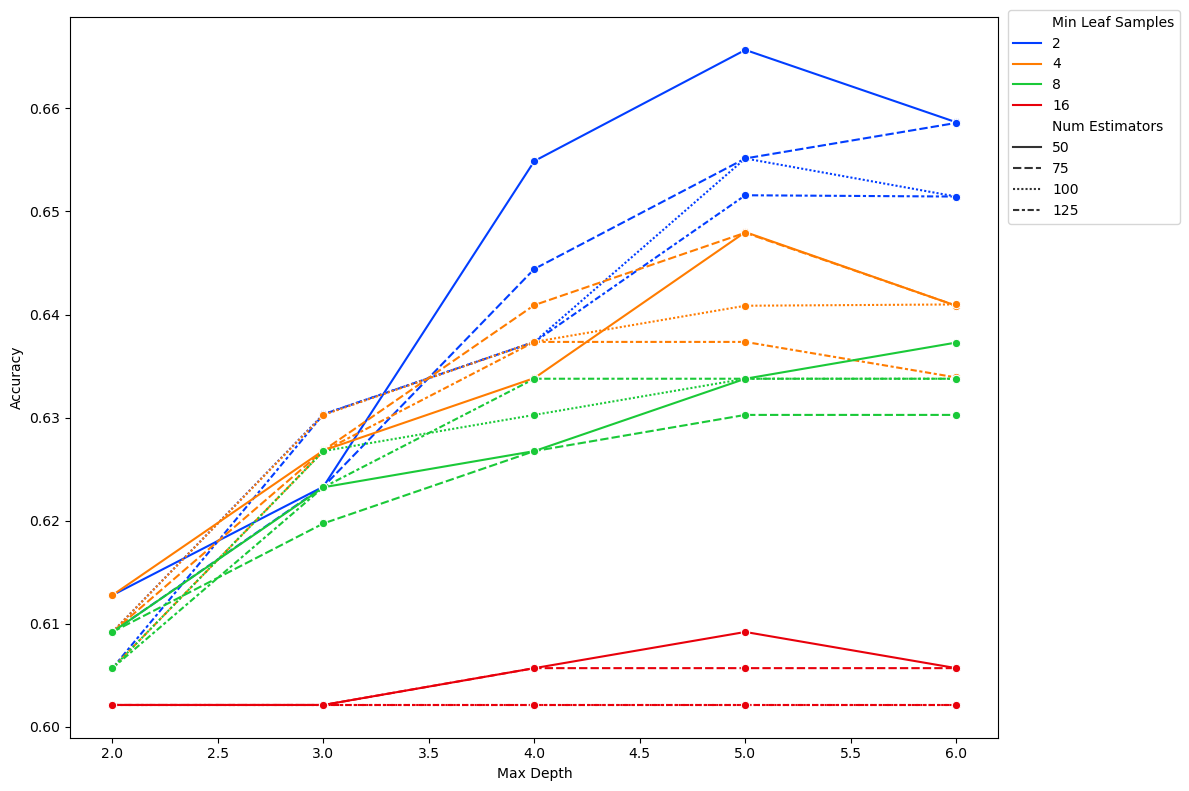

In [161]:
plt.figure(figsize = (12, 8))

gs_rf_pca_plot1 = plot_grid_search(gs_rf_pca_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('grid_search_results_rf_pca_sqrt.png')

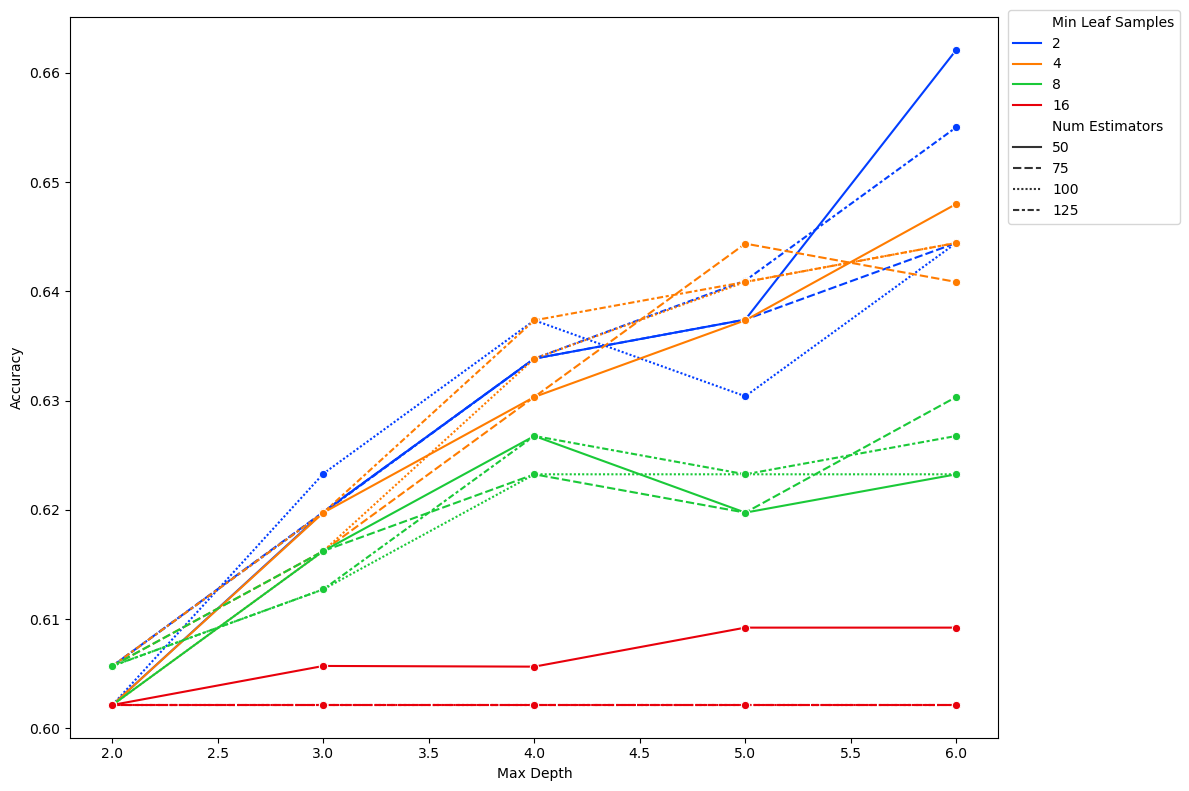

In [162]:
plt.figure(figsize = (12, 8))

gs_rf_pca_plot2 = plot_grid_search(gs_rf_pca_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('grid_search_results_rf_pca_log2.png')

We will now sort the grid search results in order of descending classification accuracy in order to more easily see the best results from the grid search.

In [163]:
gs_results_rf_pca.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
96           5         sqrt                 2              50  0.665664
144          6         log2                 2              50  0.662093
128          6         sqrt                 2              50  0.658647
129          6         sqrt                 2              75  0.658584
97           5         sqrt                 2              75  0.655138
..         ...          ...               ...             ...       ...
126          5         log2                16             100  0.602130
94           4         log2                16             100  0.602130
24           2         log2                 8              50  0.602130
22           2         log2                 4             100  0.602130
159          6         log2                16             125  0.602130

[160 rows x 5 columns]

Now, we will use randomized search in order to further explore the hyperparameter space.  First, we will define a dictionary of probability distributions to place over the hyperparameter values.  We will place a discrete uniform distribution from $50$ to $125$ over the number of estimators hyperparameter.  Similarly, we place a discrete uniform distribution from $2$ to $6$ over the maximum depth of each decision tree in the random forest and we place a discrete uniform distribution from $2$ to $16$ over the number of minimum samples in each leaf node.  Finally, consider values of `sqrt`  and `log2` for the maximum number of features used when fitting each decision tree in the random forest since it is a categorical variable.  

After defining the dictionary of probability distributions over the hyperparameters, we use the `RandomizedSearchCV()` function to set up the randomized search procedure.  Observe that we use the random forest pipeline as the model to use in the randomized search, we set the parameter distributions to the dictionary defined below, we use the stratified 5-folds for cross-validation, we set the number of iterations of randomized search to $100$, and we use the classification accuracy as the scoring metric.  We then fit the randomized search procedure to the training data.

In [164]:
param_dist_rf_pca = {
    'model__n_estimators': stats.randint(50, 125),
    'model__max_depth': stats.randint(2, 6),
    'model__min_samples_leaf': stats.randint(2, 16),
    'model__max_features': ['sqrt', 'log2']
}

random_search_rf_pca = RandomizedSearchCV(random_forest_pipe_pca, param_distributions = param_dist_rf_pca,
                                          cv = skf_pca, n_iter = 100, scoring = 'accuracy', 
                                          random_state = 20221031)

random_search_rf_pca.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('pca',
                                              PCA(n_components=36,
                                                  random_state=20221031)),
                                             ('model',
                                              RandomForestClassifier(random_state=20221031))]),
                   n_iter=100,
                   param_distributions={'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0311540520>,
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f031104b640>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0314527e80>},
                   random_state=20221031, scoring='accuracy')

We will now extract the randomized search results to a data frame and display the first $5$ rows.

In [165]:
rs_results_rf_pca = grid_search_results(random_search_rf_pca)

rs_results_rf_pca.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

rs_results_rf_pca.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          4         sqrt                14              51  0.616228
1          2         log2                14              68  0.602130
2          2         sqrt                 3             104  0.609211
3          3         log2                 9              90  0.612719
4          5         sqrt                 2              63  0.662155

We will now split the data frame of randomized search results into two smaller data frames based on the value of the `Max Features` hyperparameter.  This is done so that we can more easily visualize the randomized search results.

In [166]:
rs_results_rf_pca_sqrt, rs_results_rf_pca_log2 = split_results(rs_results_rf_pca, 'Max Features')

We will now produce two scatterplots to visualize all the randomized search results and save the resulting figures.

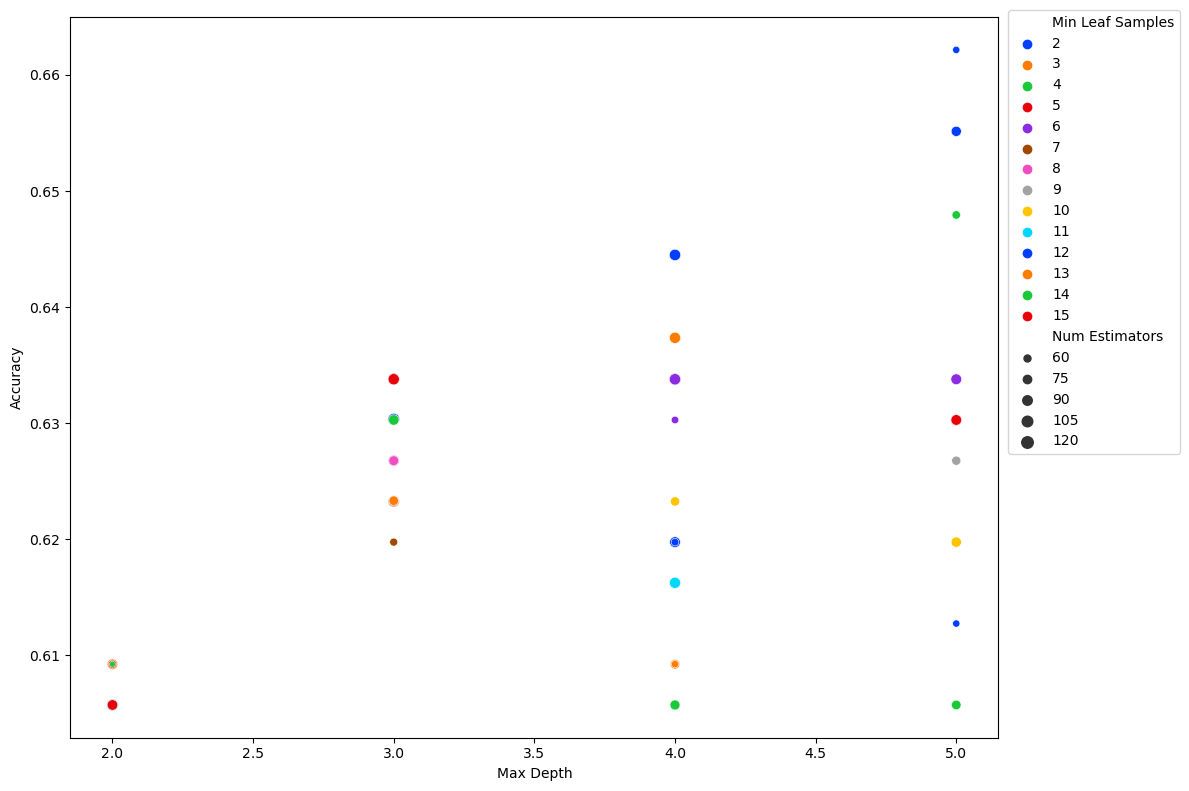

In [167]:
plt.figure(figsize = (12, 8))

rs_rf_pca_plot1 = plot_random_search(rs_results_rf_pca_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('random_search_results_rf_pca_sqrt.png')

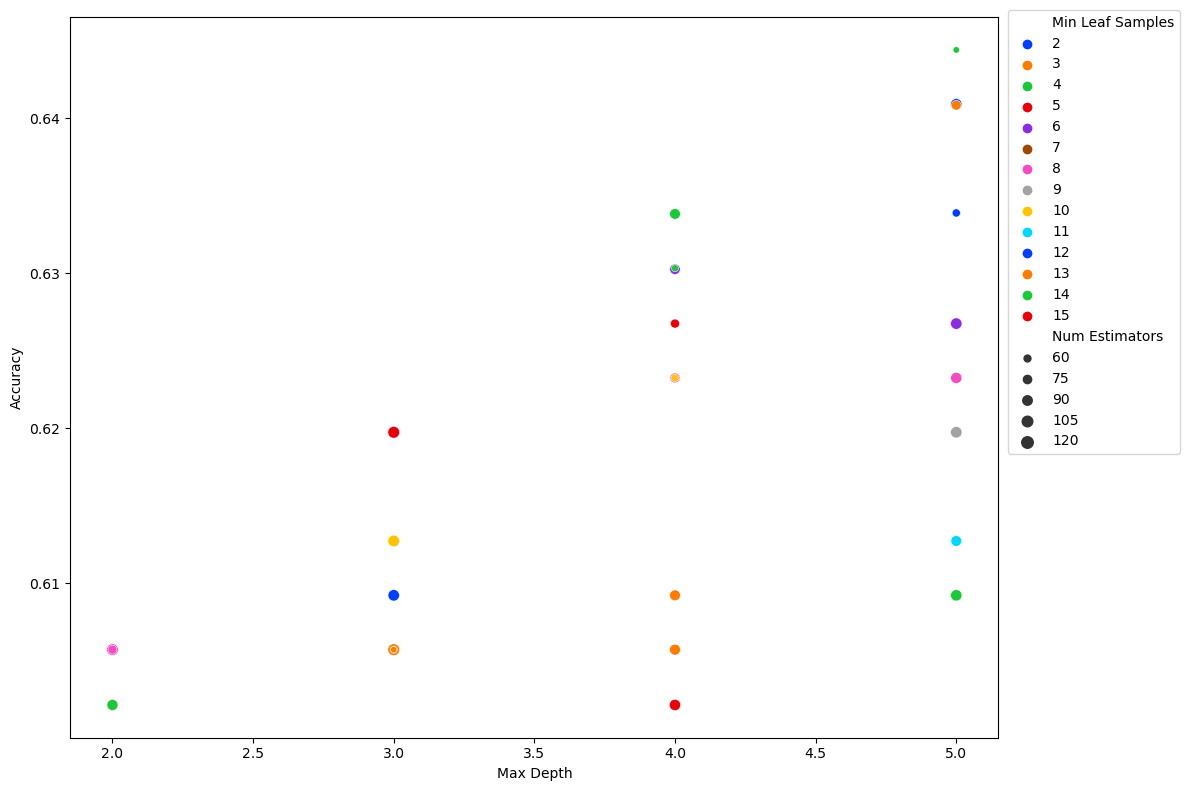

In [168]:
plt.figure(figsize = (12, 8))

rs_rf_pca_plot2 = plot_random_search(rs_results_rf_pca_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('random_search_results_rf_pca_log2.png')

We will now sort the randomized search values in order of descending classification accuracy so that we can see the best results from the randomized search more easily.

In [169]:
rs_results_rf_pca.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
4           5         sqrt                 2              63  0.662155
51          5         sqrt                 2              99  0.655138
76          5         sqrt                 4              76  0.647932
55          4         sqrt                 2             117  0.644486
64          5         log2                 4              56  0.644424
..        ...          ...               ...             ...       ...
78          4         log2                15              96  0.602130
16          2         log2                15              92  0.602130
25          2         log2                15              55  0.602130
53          2         log2                14             111  0.602130
13          4         log2                14             102  0.602130

[100 rows x 5 columns]

We will now use Bayes search to perform further hyperparameter tuning.  Notice that for Bayes search, we define a dictionary containing prior probability distributions over the hyperparameters.  Here, we put a discrete uniform prior distribution from $2$ to $6$ over the max depth, we put a discrete uniform prior distribution from $2$ to $16$ over the minimum number of samples in each leaf node, and we put a discrete uniform prior distribution from $50$ to $125$ over the number of estimators.  We also pick the maximum number of features from `sqrt`, and `log2`.  

Next, we use the `BayesSearchCV()` function to set up the Bayes search procedure.  For Bayes search, we perform $100$ iterations over the hyperparameter distributions using the random forest pipeline from before.  We also use the stratified 5-fold for cross-validation from above and use scoring as the accuracy metric.  We then fit the Bayes search procedure to the training data.

In [58]:
bayes_dist_rf_pca = {
    'model__max_depth': Integer(2, 6),
    'model__min_samples_leaf': Integer(2, 16),
    'model__n_estimators': Integer(50, 125),
    'model__max_features': ['sqrt', 'log2']
}

bayes_search_rf_pca = BayesSearchCV(random_forest_pipe_pca, search_spaces = bayes_dist_rf_pca, cv = skf_pca,
                                    n_iter = 100, scoring = 'accuracy', random_state = 20221031)

bayes_search_rf_pca.fit(X_train, y_train)

/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/megan/anaconda3/envs/ML/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20221031, shuffle=True),
              estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                        ('scaler', StandardScaler()),
                                        ('pca',
                                         PCA(n_components=36,
                                             random_state=20221031)),
                                        ('model',
                                         RandomForestClassifier(random_state=20221031))]),
              n_iter=100, random_state=20221031, scoring='accuracy',
              search_spaces={'model__max_depth': Integer(low=2, high=6, prior='uniform', transform='normalize'),
                             'model__max_features': ['sqrt', 'log2'],
                             'model__min_samples_leaf': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=125, prior='uniform', transform='normalize')})

We will now produce a data frame containing the Bayes search results and display the first $5$ result values.

In [59]:
bayes_results_rf_pca = grid_search_results(bayes_search_rf_pca)

bayes_results_rf_pca.columns = ['Max Depth', 'Max Features', 'Min Leaf Samples', 'Num Estimators', 'Accuracy']

bayes_results_rf_pca.head()

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
0          4         sqrt                14             115  0.605639
1          4         sqrt                 3              69  0.640852
2          5         log2                15              99  0.602130
3          5         log2                 6              57  0.633835
4          4         log2                 7             111  0.623246

We will now split the data frame of Bayes search results into two smaller data frames based on the value of the `Max Features` hyperparameter so that we can better visualize these results.

In [60]:
bayes_results_rf_pca_sqrt, bayes_results_rf_pca_log2 = split_results(bayes_results_rf_pca, 'Max Features')

We will now produce two scatterplots showing the Bayes search results and we will save the resulting images.

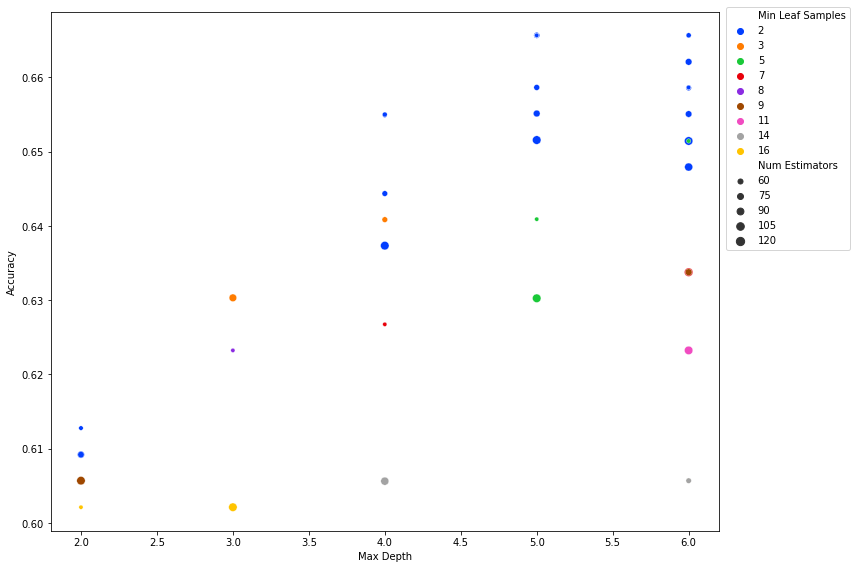

In [61]:
plt.figure(figsize = (12, 8))

bayes_rf_pca_plot1 = plot_random_search(bayes_results_rf_pca_sqrt, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('bayes_search_results_rf_pca_sqrt.png')

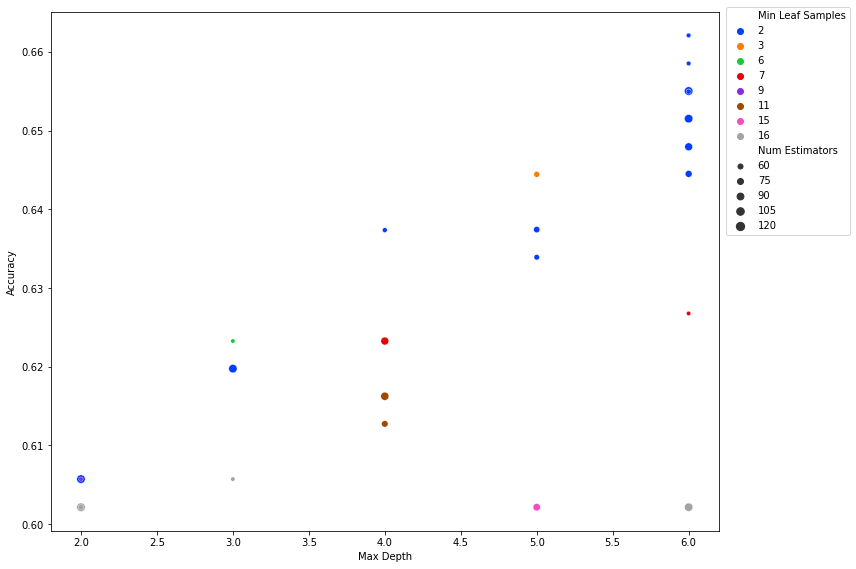

In [62]:
plt.figure(figsize = (12, 8))

bayes_rf_pca_plot2 = plot_random_search(bayes_results_rf_pca_log2, 'Max Depth', 'Min Leaf Samples', 'Num Estimators')

plt.tight_layout()

plt.savefig('bayes_search_results_rf_pca_log2.png')

We will now sort the values in the data frame of Bayes search results in order of descending classification accuracy so that we can see the best results from the Bayes search.

In [63]:
bayes_results_rf_pca.sort_values(by = ['Accuracy'], ascending = False)

Max Depth Max Features  Min Leaf Samples  Num Estimators  Accuracy
65          5         sqrt                 2              68  0.665664
60          5         sqrt                 2              68  0.665664
70          5         sqrt                 2              51  0.665664
72          5         sqrt                 2              69  0.665664
79          5         sqrt                 2              50  0.665664
..        ...          ...               ...             ...       ...
16          2         log2                 2              50  0.602130
77          6         log2                16             120  0.602130
74          2         log2                16              65  0.602130
2           5         log2                15              99  0.602130
17          2         log2                16             123  0.602130

[100 rows x 5 columns]

Notice that we obtain the best cross-validation results when the random forest has a maximum depth of $5$, has a minimum of $2$ samples in each leaf node, has $68$ estimators, and has a `Max Features` value of `sqrt`.  

We will now set the hyperparameter values of the random forest pipeline defined above to match the best values found during hyperparameter tuning.

In [170]:
random_forest_pipe_pca.set_params(**{'model__max_depth': 5, 'model__min_samples_leaf': 2,
                                     'model__max_features': 'sqrt', 'model__n_estimators': 68})

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=36, random_state=20221031)),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=68,
                                        random_state=20221031))])

We will now fit the best random forest pipeline to the training data.

In [171]:
random_forest_pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=36, random_state=20221031)),
                ('model',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        n_estimators=68,
                                        random_state=20221031))])

We will now use the `learning_curve()` function to obtain training and test scores and plot those results in order to determine whether the random forest model is overfitting or underfitting the data.

In [172]:
_, train_scores_rf_pca, test_scores_rf_pca = learning_curve(random_forest_pipe_pca, X_train, y_train,
                                                            scoring = 'accuracy', cv = skf_pca,
                                                            train_sizes = train_fractions, return_times = False)

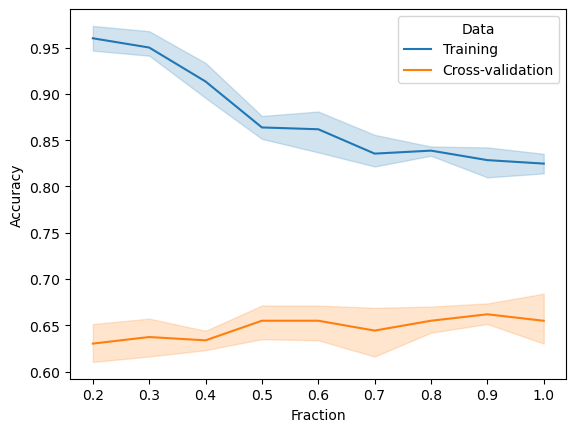

In [173]:
plot_learning_curve(train_fractions, train_scores_rf_pca, test_scores_rf_pca)

plt.savefig('learning_curve_rf_pca.png')

We will now compute and display the training accuracy of the random forest for feature selection with PCA.

In [174]:
train_acc_rf_pca = random_forest_pipe_pca.score(X_train, y_train)

train_acc_rf_pca

0.8133802816901409

Observe that the training accuracy for the random forest fit to the data after feature selection with PCA is $0.8134$, which means that the random forest correctly predicts the arrhythmia diagnosis for $81.34\%$ of the instances in the training set.  

We will now create a heatmap showing the confusion matrix for the predictions for the training instances from the random forest.

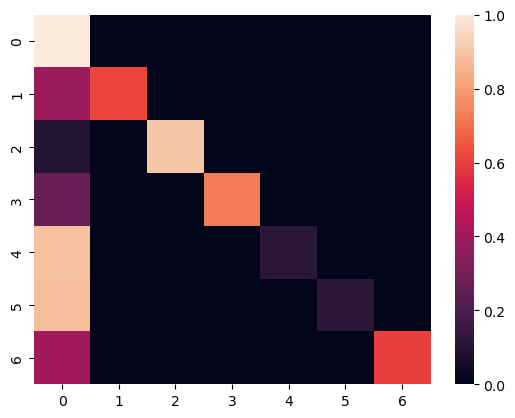

In [175]:
train_preds_rf_pca = random_forest_pipe_pca.predict(X_train)

confmat_train_rf_pca = confusion_matrix(y_train, train_preds_rf_pca, normalize = 'true')

sb.heatmap(confmat_train_rf_pca)

plt.savefig('confmat_train_rf_pca.png')

We will now calculate and display the test accuracy for the random forest that is fit to the data after feature selection with PCA.

In [176]:
test_acc_rf_pca = random_forest_pipe_pca.score(X_test, y_test)

test_acc_rf_pca

0.6097560975609756

Notice that the test accuracy for the random forest model that is fit to the data after feature selection with PCA is $0.6098$, which means that the random forest correctly predicts the arrhythmia diagnosis for $60.98\%$ of the instances in the test set.

Now, we will generate a heatmap showing the confusion matrix for the test predictions from this random forest model.

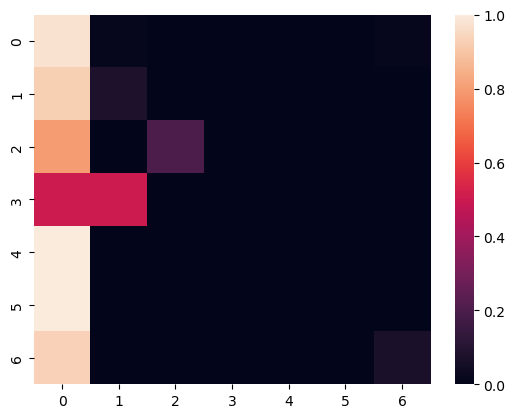

In [177]:
test_preds_rf_pca = random_forest_pipe_pca.predict(X_test)

confmat_test_rf_pca = confusion_matrix(y_test, test_preds_rf_pca, normalize = 'true')

sb.heatmap(confmat_test_rf_pca)

plt.savefig('confmat_test_rf_pca.png')

# K Means Clustering with PCA

We will now perform K-means clustering and evaluate its performance on both the training and test sets.  In order to do so, we start by using the `KMeans()` function to define a K-means clusterer from scikit-learn.  We set the number of clusters for K-means clustering to $7$ since there are $7$ arrhythmia diagnoses in the dataset and we set its random state to `20221031`.  Next, we incorporate the K-means clusterer into a pipeline that first uses K-nearest neighbors to impute the missing values in the dataset, then uses the standard scaler to standardize the values in the dataset, then uses PCA to select the top $36$ principal components, and finally uses the K-means clusterer to perform K-means clustering.

In [178]:
kmeans_pca = KMeans(n_clusters = 7, random_state = 20221031)

kmeans_pipe_pca = Pipeline(steps = [('imputer', imputer_pca), ('scaler', scaler_pca), ('pca', pca), 
                                    ('model', kmeans_pca)])

We will now fit the K-means clustering pipeline to the training data.

In [179]:
kmeans_pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=36, random_state=20221031)),
                ('model', KMeans(n_clusters=7, random_state=20221031))])

In order to find the training accuracy of the K-means clustering pipeline, we will first use the `predict()` method to predict the arrhythmia diagnoses of all the instances in the training set.  Then, we will find the number of times that the predicted arrhythmia diagnosis matched the actual arrhythmia diagnosis for the instances in the training set and divide it by the number of instances in the training set and print the resulting training accuracy.

In [180]:
train_preds_kmeans_pca = kmeans_pipe_pca.predict(X_train) + 1

train_acc_kmeans_pca = (len(np.where(train_preds_kmeans_pca == y_train)[0]))/(len(y_train))

train_acc_kmeans_pca

0.2535211267605634

From the output of the code shown above, we see that the training accuracy for the K-means clustering pipeline is $0.2535$, which means that the K-means clustering pipeline correctly predicted the arrhythmia diagnosis for $25.35\%$ of the instances in the training set.

We will now use the `confusion_matrix()` function to make a confusion matrix from the predicted arrhythmia diagnoses and actual arrhythmia diagnoses for the taining instances, normalized based on the actual arrythmia diagnoses.  Next, we use seaborn to create a heatmap visualization of the confusion matrix and save the visualization to a png file.

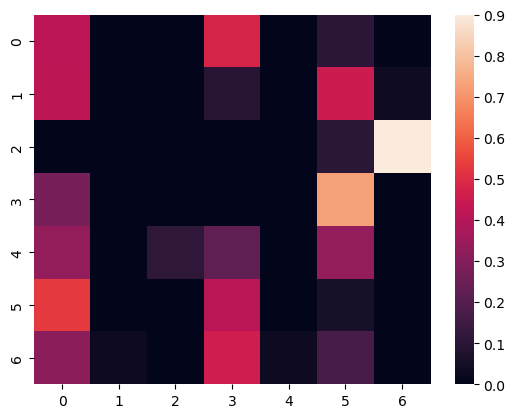

In [181]:
confmat_train_kmeans_pca = confusion_matrix(y_train, train_preds_kmeans_pca, normalize = 'true')

sb.heatmap(confmat_train_kmeans_pca)

plt.savefig('confmat_train_kmeans_pca.png')

Observe in the confusion matrix shown above that the K-means clustering pipeline seems to just randomly predict arrythmia diagnoses and does not appear to have learned any of the signal from the data.

We will now use the `predict()` method on the K-means clustering pipeline to generate predicted arrythmia diagnoses for all the instances in the test set.  As before, we then find the number of times that the predicted arrythmia diagnosis matched the actual arrythmia diagnosis from the test set and divide by the number of instances in the test set to find the test accuracy, which we then display.

In [182]:
test_preds_kmeans_pca = kmeans_pipe_pca.predict(X_test) + 1

test_acc_kmeans_pca = (len(np.where(test_preds_kmeans_pca == y_test)[0]))/(len(y_test))

test_acc_kmeans_pca

0.24390243902439024

Based on the output of the code shown above, we see that the test acuracy of the K-means clustering pipeline is $0.2439$, which means that the K-means clustering pipeline predicted the correct arrhythmia diagnosis for $24.39\%$ of the instances in the test set.

Now, we will create a confusion matrix for the instances in the test set that is normalized based on the actual arrythmia diagnosis.  We then use seaborn to create a heatmap visualization of the confusion matrix and save it to a png file.

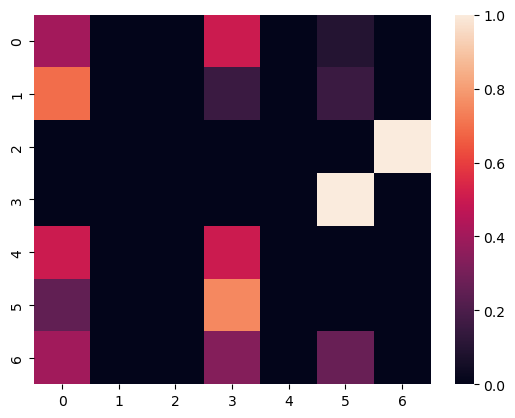

In [183]:
confmat_test_kmeans_pca = confusion_matrix(y_test, test_preds_kmeans_pca, normalize = 'true')

sb.heatmap(confmat_test_kmeans_pca)

plt.savefig('confmat_test_kmeans_pca.png')

# Additional Results

From the confusion matrices for the machine learning models shown above, we see that the decision tree and random forest models tend to overpredict a normal diagnosis.  This is due to a class imbalance since there are many more normal diagnosis instances in both the training and test sets than there are instances of other arrhythmia diagnoses.  We will now examine the number of normal diagnoses predicted by each of the machine learning models that we fit previously.  

This code is used to find the number of normal diagnosis predictions from each machine learning model for the data in the training set and the number of normal diagnosis predictions from each machine learning model for the data in the test set.

In [191]:
train_preds = [len(np.where(train_preds_dt == 1)[0]), len(np.where(train_preds_rf == 1)[0]),
                      len(np.where(train_preds_kmeans == 1)[0]),
                      len(np.where(train_preds_dt_fe == 1)[0]), len(np.where(train_preds_rf_fe == 1)[0]),
                      len(np.where(train_preds_kmeans_fe == 1)[0]),
                      len(np.where(train_preds_dt_pca == 1)[0]), len(np.where(train_preds_rf_pca == 1)[0]),
                      len(np.where(train_preds_kmeans_pca == 1)[0])]

pred_names = ['Decision Tree', 'Random Forest', 'K-means Clustering',
                     'Decision Tree Feature Engineering', 'Random Forest Feature Engineering',
                     'K-means Clustering Feature Engineering', 'Decision Tree Feature Selection',
                     'Random Forest Feature Selection', 'K-means Clustering Feature Selection']
                                                                

test_preds = [len(np.where(test_preds_dt == 1)[0]), len(np.where(test_preds_rf == 1)[0]),
                      len(np.where(test_preds_kmeans == 1)[0]),
                      len(np.where(test_preds_dt_fe == 1)[0]), len(np.where(test_preds_rf_fe == 1)[0]),
                      len(np.where(test_preds_kmeans_fe == 1)[0]),
                      len(np.where(test_preds_dt_pca == 1)[0]), len(np.where(test_preds_rf_pca == 1)[0]),
                      len(np.where(test_preds_kmeans_pca == 1)[0])]                                                            

We will now make dataframes with the name of each machine learning model and its number of normal diagnoses for both the data in the training and test sets.

In [192]:
train_preds_df = pd.DataFrame({'Model': pred_names, 'Number of Normal Diagnoses': train_preds})

test_preds_df = pd.DataFrame({'Model': pred_names, 'Number of Normal Diagnoses': test_preds})

We will now examine the number of normal diagnosis predictions made by each machine learning model on the data in the training set.

In [195]:
train_preds_df

Model  Number of Normal Diagnoses
0                           Decision Tree                         183
1                           Random Forest                         209
2                      K-means Clustering                          87
3       Decision Tree Feature Engineering                         207
4       Random Forest Feature Engineering                         227
5  K-means Clustering Feature Engineering                          62
6         Decision Tree Feature Selection                         219
7         Random Forest Feature Selection                         224
8    K-means Clustering Feature Selection                         110

In order to better visualize these results, we will make a barchart showing the number of normal diagnosis predictions made by each model for the data in the training set.  Each machine learning model is labeled on the x-axis and the number of normal diagnosis predictions are shown on the y-axis.  This figure is then saved to a png file.

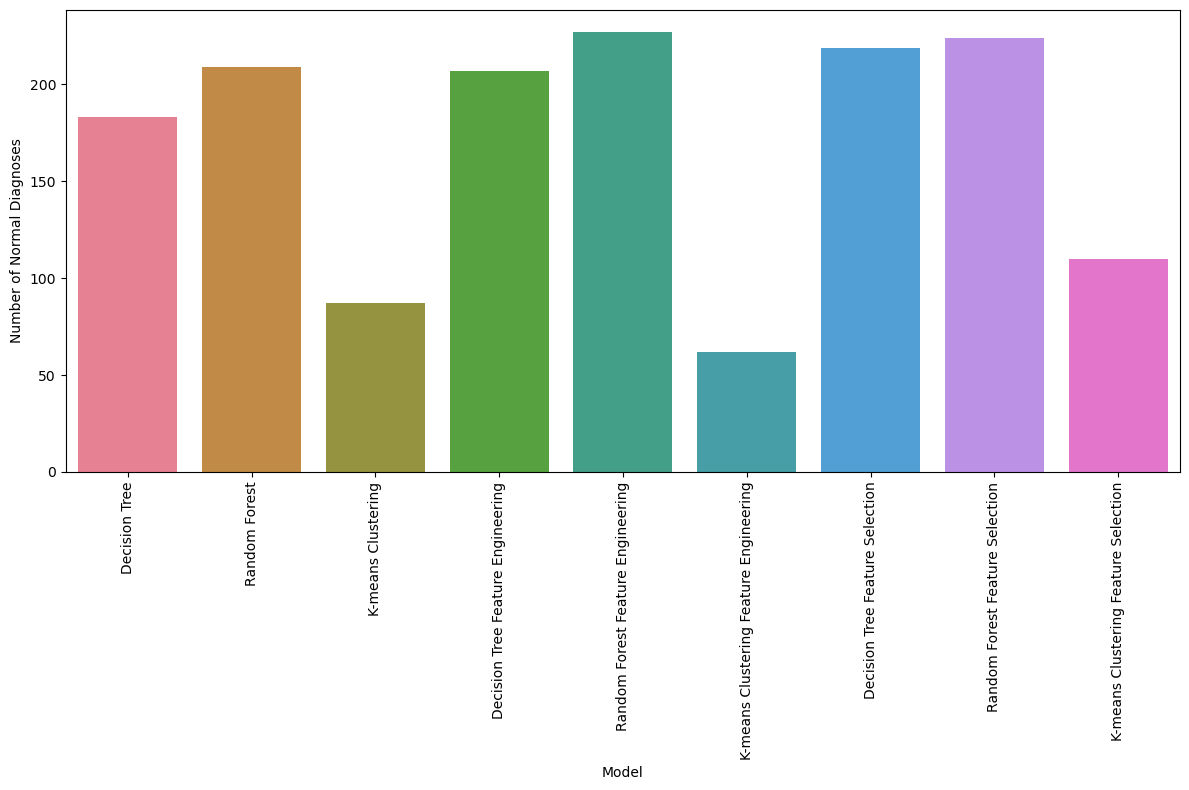

In [205]:
plt.figure(figsize = (12, 8))

splot_train = sb.barplot(data = train_preds_df, x = 'Model', y = 'Number of Normal Diagnoses', palette = 'husl')

plt.xticks(rotation = 90)

plt.tight_layout()

plt.savefig('train_normal_diagnoses.png')

We will now examine the number of normal arrhythmia diagnosis predictions made by each machine learning model on the data in the test set.

In [196]:
test_preds_df

Model  Number of Normal Diagnoses
0                           Decision Tree                          81
1                           Random Forest                          99
2                      K-means Clustering                          41
3       Decision Tree Feature Engineering                          90
4       Random Forest Feature Engineering                         109
5  K-means Clustering Feature Engineering                          27
6         Decision Tree Feature Selection                         101
7         Random Forest Feature Selection                         116
8    K-means Clustering Feature Selection                          49

To better visualize these results, we will make a barchart showing the number of normal diagnosis predictions made by each model for the data in the test set.  Each machine learning model is labeled on the x-axis and the number of normal diagnosis predictions are shown on the y-axis.  This figure is then saved to a png file.

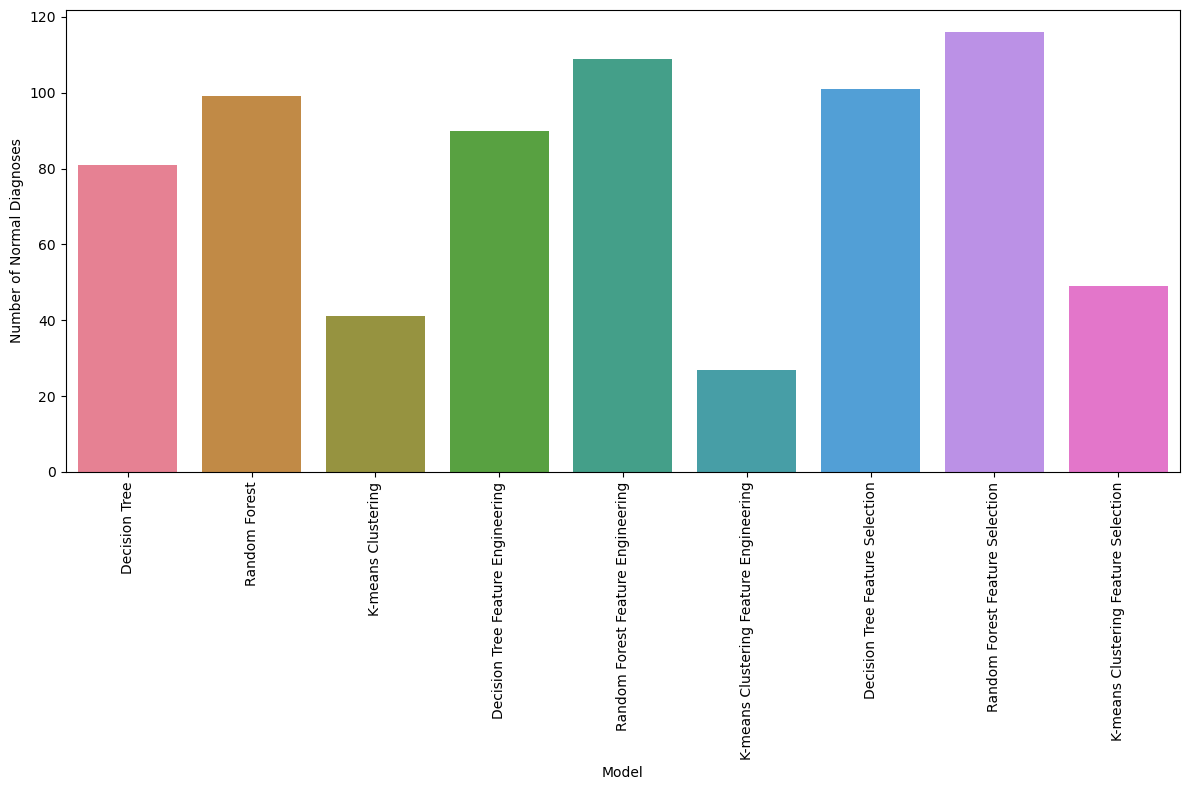

In [203]:
plt.figure(figsize = (12, 8))

splot_test = sb.barplot(data = test_preds_df, x = 'Model', y = 'Number of Normal Diagnoses', palette = 'husl')

plt.xticks(rotation = 90)

plt.tight_layout()

plt.savefig('test_normal_diagnoses.png')